In [16]:
import numpy as np
import pandas as pd
import statistics as ss
import matplotlib.pyplot as plt
from tqdm import tqdm

from torchmetrics import MeanSquaredLogError as msle
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics 
from torch.utils.data import Dataset, DataLoader
import gc

In [17]:
CSV_FILE='data/MICCAI_BraTS_2019_Data_Training/new.csv'
device= torch.device('cuda')
EPOCH = 200
BATCH_SIZE=10
MODEL_PATH = 'log/baseline/regression_pytorch/'
LEARNING_RATE = 0.01


In [5]:
# Load training cvs data into the program.
train=pd.read_csv(CSV_FILE)

# Perform feature reduction to discard any irrelevent data feature, namely 'ResectionStatus'.
#We proceed by discarding columns mentioned above from the dataframe.
train=train.drop(['ResectionStatus'],axis=1)

# drop rows contain NA value from the data 
train = train.dropna(subset=['Survival'])
X= train[['Age']].astype('float')
X=torch.tensor(X.values)
Y= train['Survival'].astype('float')
Y=torch.tensor(Y.values)

In [47]:
class data(Dataset):
    def __init__(self,train):
        self.source =pd.read_csv(train)

     
       
    def __len__(self):
        return len(self.source)
    def __getitem__(self,idx):
        x = self.source.iloc[idx,2]
        
        y= self.source.iloc[idx,3]
       
        return x,y
def getdata(t,batch_size=BATCH_SIZE,shuffle=True,pin_memory=True):
    da=data(t)
    leng = [int(0.7* len(da)),len(da) - int(0.7 * len(da))]
    train,eva = torch.utils.data.random_split(da,leng)
    train=DataLoader(train,batch_size=batch_size,shuffle=shuffle,pin_memory=pin_memory)
    eva=DataLoader(eva,batch_size=batch_size,shuffle=shuffle,pin_memory=pin_memory)
    return train, eva

In [48]:
class model(nn.Module):
    def blk(self):
        block = nn.Sequential(
            nn.Linear(1,8),
            nn.LeakyReLU(),
            nn.Linear(8,32),
            nn.LeakyReLU(),
            nn.Linear(32,32),
            nn.LeakyReLU(),
            nn.Linear(32,8),
            nn.LeakyReLU(),
            nn.Linear(8,1),
        )
        return block
    
    def __init__(self):
        super(model, self).__init__()
        self.b = self.blk()
    def forward(self,x):
        return self.b(x)
    

In [64]:
def training(data,model,opt):
    print("Training in session: ")
    epoch_loss=0.0
    loss_fn = torch.nn.MSELoss().to(device)
    l = len(data.sampler)
    data=tqdm(data)
    model.train()
    for index, batch in enumerate(data):

        # reshape the data and load the data to gpu
        x, y= batch 
        x=x.float().to(device)
        y=y.float().to(device)
        x=x[:,None]
        # training model
        res = model(x)
        res=res.to(device)
        a,b = res.shape
        res=res.reshape(a*b)
        loss = loss_fn(res,y).to(device)
        opt.zero_grad()
        
        loss.backward()
        
        opt.step()
        
     
        
        print("Batch_id: ", index,"Training loss: ", loss.item())
        epoch_loss+=loss.item()

    return epoch_loss/(l/BATCH_SIZE)

In [68]:
def eva(data,model,opt):
    print("Eval in session: ")
    epoch_loss=0.0
    loss_fn = torch.nn.MSELoss().to(device)
    l = len(data.sampler)
    data=tqdm(data)
    model.eval()

    with torch.no_grad():
        for index, batch in enumerate(data):

            # reshape the data and load the data to gpu
            x, y= batch 
            x=x.float().to(device)
            y=y.float().to(device)
            
            x=x[:,None]
        
            res = model(x)
            a,b = res.shape
            res=res.reshape(a*b)
            loss = loss_fn(res,y).to(device)
           
            print("Batch_id: ", index,"Eval loss: ", loss.item())
            epoch_loss+=loss.item()

    return epoch_loss/(l/BATCH_SIZE)
    

In [69]:
def main(t):
    train_data,eval_data = getdata(t)
    BEST_VAL=10000000
    m = model().to(device)
    opt = optim.Adam(m.parameters(), lr=LEARNING_RATE)
    tra=[]
    ev = []
    index=[]
    ind =0
    sc = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,patience=10,factor = 0.5,threshold=0.1,mode = 'min',verbose = True)
    for i in range(0,EPOCH):
        tl = training(train_data,m,opt)
        el= eva(eval_data,m,opt)
        sc.step(el)
        tra.append(tl)
  
        ev.append(el)
        index.append(i)
        print('Epoch ',i,'Training loss: ',tl)
        print('Epoch ',i,'Evaluation loss: ',el)

        if BEST_VAL> el and i > 20:
            torch.save({
            'model_state_dict': m.state_dict(),
            'optim_state_dict': opt.state_dict(),
            'epoch': i,
            'train loss': tl,
            'eval loss': el,
            },MODEL_PATH+'best')
            print("Best Model saved!")
            print("Best Loss value: ", BEST_VAL)
            BEST_VAL=el
            ind = i
    plt.plot(index, tra, label ="Training ")
    plt.plot(index,ev, label = "Validation")
    plt.title("Training and Validation Loss Curve: ")
    plt.xlabel("Epoch:")
    plt.ylabel("Average Loss ")
    plt.legend()
    plt.savefig(MODEL_PATH+ 'Training and Eval Loss plot.png')
    plt.show()
    
   
        
    print("Best epoch: ",ind," and loss value is ", BEST_VAL)    
        

In [70]:
gc.collect()
torch.cuda.empty_cache()

Training in session: 


100%|██████████| 13/13 [00:02<00:00,  5.67it/s]


Batch_id:  0 Training loss:  446894.84375
Batch_id:  1 Training loss:  298634.4375
Batch_id:  2 Training loss:  121000.078125
Batch_id:  3 Training loss:  250388.234375
Batch_id:  4 Training loss:  376743.3125
Batch_id:  5 Training loss:  297224.125
Batch_id:  6 Training loss:  309790.9375
Batch_id:  7 Training loss:  306607.5
Batch_id:  8 Training loss:  178236.28125
Batch_id:  9 Training loss:  388043.125
Batch_id:  10 Training loss:  285251.375
Batch_id:  11 Training loss:  186337.40625
Batch_id:  12 Training loss:  73216.140625
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 461.50it/s]


Batch_id:  0 Eval loss:  115215.3046875
Batch_id:  1 Eval loss:  206380.65625
Batch_id:  2 Eval loss:  307904.46875
Batch_id:  3 Eval loss:  193904.296875
Batch_id:  4 Eval loss:  388390.84375
Batch_id:  5 Eval loss:  500307.3125
Epoch  0 Training loss:  274872.4841308594
Epoch  0 Evaluation loss:  305732.6576450893
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 251.91it/s]


Batch_id:  0 Training loss:  104069.1953125
Batch_id:  1 Training loss:  509059.84375
Batch_id:  2 Training loss:  371852.34375
Batch_id:  3 Training loss:  346405.0625
Batch_id:  4 Training loss:  192076.84375
Batch_id:  5 Training loss:  104489.8046875
Batch_id:  6 Training loss:  203378.40625
Batch_id:  7 Training loss:  35829.6953125
Batch_id:  8 Training loss:  33928.29296875
Batch_id:  9 Training loss:  107530.7421875
Batch_id:  10 Training loss:  60459.32421875
Batch_id:  11 Training loss:  174632.203125
Batch_id:  12 Training loss:  83658.8515625
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 436.38it/s]


Batch_id:  0 Eval loss:  163792.515625
Batch_id:  1 Eval loss:  87428.53125
Batch_id:  2 Eval loss:  179660.125
Batch_id:  3 Eval loss:  87827.0234375
Batch_id:  4 Eval loss:  94181.7109375
Batch_id:  5 Eval loss:  59845.94921875
Epoch  1 Training loss:  181825.82885742188
Epoch  1 Evaluation loss:  120131.40276227679
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 262.29it/s]

Batch_id:  0 Training loss:  177152.34375
Batch_id:  1 Training loss:  95218.7734375
Batch_id:  2 Training loss:  35117.3671875
Batch_id:  3 Training loss:  75942.6484375
Batch_id:  4 Training loss:  247783.78125
Batch_id:  5 Training loss:  184660.609375
Batch_id:  6 Training loss:  89876.9375
Batch_id:  7 Training loss:  182252.640625
Batch_id:  8 Training loss:  179549.9375
Batch_id:  9 Training loss:  48915.34765625
Batch_id:  10 Training loss:  65504.4765625
Batch_id:  11 Training loss:  112270.4609375
Batch_id:  12 Training loss:  80916.484375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 461.55it/s]


Batch_id:  0 Eval loss:  132566.953125
Batch_id:  1 Eval loss:  181819.1875
Batch_id:  2 Eval loss:  199895.421875
Batch_id:  3 Eval loss:  117884.375
Batch_id:  4 Eval loss:  60205.44921875
Batch_id:  5 Eval loss:  94968.1484375
Epoch  2 Training loss:  123059.51629638672
Epoch  2 Evaluation loss:  140596.34556361608
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 270.88it/s]

Batch_id:  0 Training loss:  18980.05859375
Batch_id:  1 Training loss:  118830.0546875
Batch_id:  2 Training loss:  82598.640625
Batch_id:  3 Training loss:  262995.65625
Batch_id:  4 Training loss:  170388.375
Batch_id:  5 Training loss:  246403.453125
Batch_id:  6 Training loss:  94122.5546875
Batch_id:  7 Training loss:  81814.640625
Batch_id:  8 Training loss:  287460.34375
Batch_id:  9 Training loss:  79031.140625
Batch_id:  10 Training loss:  55103.40625
Batch_id:  11 Training loss:  88432.0390625
Batch_id:  12 Training loss:  23262.3671875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 501.10it/s]


Batch_id:  0 Eval loss:  71637.3046875
Batch_id:  1 Eval loss:  97746.515625
Batch_id:  2 Eval loss:  113846.75
Batch_id:  3 Eval loss:  147201.671875
Batch_id:  4 Eval loss:  65078.15234375
Batch_id:  5 Eval loss:  248376.734375
Epoch  3 Training loss:  125736.1508178711
Epoch  3 Evaluation loss:  132836.9873046875
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 279.81it/s]

Batch_id:  0 Training loss:  145706.421875
Batch_id:  1 Training loss:  237565.0
Batch_id:  2 Training loss:  235198.046875
Batch_id:  3 Training loss:  150518.75
Batch_id:  4 Training loss:  89252.7890625
Batch_id:  5 Training loss:  70544.6796875
Batch_id:  6 Training loss:  116786.9140625
Batch_id:  7 Training loss:  128856.890625
Batch_id:  8 Training loss:  57679.28125
Batch_id:  9 Training loss:  192282.515625
Batch_id:  10 Training loss:  88989.96875
Batch_id:  11 Training loss:  95928.3984375
Batch_id:  12 Training loss:  44329.6171875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 524.58it/s]

Batch_id:  0 Eval loss:  256887.859375
Batch_id:  1 Eval loss:  31639.724609375
Batch_id:  2 Eval loss:  85101.0546875
Batch_id:  3 Eval loss:  211528.15625
Batch_id:  4 Eval loss:  190803.234375
Batch_id:  5 Eval loss:  42999.58984375


Epoch  4 Training loss:  129190.56823730469
Epoch  4 Evaluation loss:  146242.78913225446
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 317.02it/s]


Batch_id:  0 Training loss:  246909.671875
Batch_id:  1 Training loss:  29822.837890625
Batch_id:  2 Training loss:  76512.3515625
Batch_id:  3 Training loss:  208193.96875
Batch_id:  4 Training loss:  72543.8046875
Batch_id:  5 Training loss:  231469.796875
Batch_id:  6 Training loss:  37232.78515625
Batch_id:  7 Training loss:  259180.296875
Batch_id:  8 Training loss:  82551.6015625
Batch_id:  9 Training loss:  61182.62109375
Batch_id:  10 Training loss:  215638.828125
Batch_id:  11 Training loss:  168341.078125
Batch_id:  12 Training loss:  38957.49609375
Eval in session: 


  0%|          | 0/6 [00:00<?, ?it/s]

Batch_id:  0 Eval loss:  48336.40234375


100%|██████████| 6/6 [00:00<00:00, 628.02it/s]


Batch_id:  1 Eval loss:  174236.234375
Batch_id:  2 Eval loss:  65355.03125
Batch_id:  3 Eval loss:  103299.5546875
Batch_id:  4 Eval loss:  215115.15625
Batch_id:  5 Eval loss:  86690.640625
Epoch  5 Training loss:  135041.96395874023
Epoch  5 Evaluation loss:  123755.89634486608
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  61743.6640625
Batch_id:  1 Training loss:  317599.71875
Batch_id:  2 Training loss:  144601.796875
Batch_id:  3 Training loss:  91031.9296875
Batch_id:  4 Training loss:  51313.29296875
Batch_id:  5 Training loss:  258083.65625
Batch_id:  6 Training loss:  171797.921875
Batch_id:  7 Training loss:  131079.59375
Batch_id:  8 Training loss:  167332.859375
Batch_id:  9 Training loss:  51906.26171875


100%|██████████| 13/13 [00:00<00:00, 315.57it/s]


Batch_id:  10 Training loss:  78939.0625
Batch_id:  11 Training loss:  170496.453125
Batch_id:  12 Training loss:  22668.96875
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 741.61it/s]

Batch_id:  0 Eval loss:  60860.3515625
Batch_id:  1 Eval loss:  39400.45703125
Batch_id:  2 Eval loss:  71180.2109375
Batch_id:  3 Eval loss:  175408.71875
Batch_id:  4 Eval loss:  220206.75
Batch_id:  5 Eval loss:  275513.40625


Epoch  6 Training loss:  134265.24841308594
Epoch  6 Evaluation loss:  150458.9097377232
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 317.06it/s]

Batch_id:  0 Training loss:  143899.734375
Batch_id:  1 Training loss:  195024.8125
Batch_id:  2 Training loss:  361524.90625
Batch_id:  3 Training loss:  27227.34765625
Batch_id:  4 Training loss:  92723.9609375
Batch_id:  5 Training loss:  110195.8125
Batch_id:  6 Training loss:  30885.443359375
Batch_id:  7 Training loss:  44788.73828125
Batch_id:  8 Training loss:  238237.046875
Batch_id:  9 Training loss:  187040.15625
Batch_id:  10 Training loss:  101618.765625
Batch_id:  11 Training loss:  50816.52734375
Batch_id:  12 Training loss:  104157.9296875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 921.83it/s]


Batch_id:  0 Eval loss:  65252.67578125
Batch_id:  1 Eval loss:  44250.80859375
Batch_id:  2 Eval loss:  318681.4375
Batch_id:  3 Eval loss:  20641.294921875
Batch_id:  4 Eval loss:  88380.3125
Batch_id:  5 Eval loss:  210161.125
Epoch  7 Training loss:  131886.02981567383
Epoch  7 Evaluation loss:  133458.50969587054
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  324344.21875
Batch_id:  1 Training loss:  26190.443359375
Batch_id:  2 Training loss:  129550.3984375
Batch_id:  3 Training loss:  101282.8359375
Batch_id:  4 Training loss:  64639.40234375
Batch_id:  5 Training loss:  130850.7890625
Batch_id:  6 Training loss:  67614.3125
Batch_id:  7 Training loss:  162179.03125
Batch_id:  8 Training loss:  29778.025390625
Batch_id:  9 Training loss:  42902.921875
Batch_id:  10 Training loss:  96083.765625


100%|██████████| 13/13 [00:00<00:00, 130.64it/s]


Batch_id:  11 Training loss:  52759.78125
Batch_id:  12 Training loss:  439356.625
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 333.34it/s]

Batch_id:  0 Eval loss:  179903.21875
Batch_id:  1 Eval loss:  67774.8515625
Batch_id:  2 Eval loss:  140342.6875
Batch_id:  3 Eval loss:  230075.953125
Batch_id:  4 Eval loss:  38144.1875
Batch_id:  5 Eval loss:  62795.32421875


Epoch  8 Training loss:  130275.98052978516
Epoch  8 Evaluation loss:  128399.32547433037
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  89948.1171875
Batch_id:  1 Training loss:  22029.388671875
Batch_id:  2 Training loss:  32516.17578125
Batch_id:  3 Training loss:  385803.0
Batch_id:  4 Training loss:  91031.171875
Batch_id:  5 Training loss:  84616.0546875
Batch_id:  6 Training loss:  145537.234375
Batch_id:  7 Training loss:  155312.796875
Batch_id:  8 Training loss:  21314.796875
Batch_id:  9 Training loss:  80353.6484375
Batch_id:  10 Training loss:  92594.8359375
Batch_id:  11 Training loss:  132090.046875


100%|██████████| 13/13 [00:00<00:00, 168.54it/s]


Batch_id:  12 Training loss:  322571.53125
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 737.09it/s]


Batch_id:  0 Eval loss:  123434.1796875
Batch_id:  1 Eval loss:  182221.859375
Batch_id:  2 Eval loss:  60081.15625
Batch_id:  3 Eval loss:  28489.22265625
Batch_id:  4 Eval loss:  170145.046875
Batch_id:  5 Eval loss:  122699.7109375
Epoch  9 Training loss:  129353.03115844727
Epoch  9 Evaluation loss:  122691.28138950893
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  84028.0546875


100%|██████████| 13/13 [00:00<00:00, 351.36it/s]


Batch_id:  1 Training loss:  132170.890625
Batch_id:  2 Training loss:  84144.1796875
Batch_id:  3 Training loss:  63072.07421875
Batch_id:  4 Training loss:  27683.513671875
Batch_id:  5 Training loss:  51971.7890625
Batch_id:  6 Training loss:  137260.890625
Batch_id:  7 Training loss:  15888.783203125
Batch_id:  8 Training loss:  119955.8359375
Batch_id:  9 Training loss:  270214.71875
Batch_id:  10 Training loss:  177397.265625
Batch_id:  11 Training loss:  153121.359375
Batch_id:  12 Training loss:  385572.1875
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1200.14it/s]


Batch_id:  0 Eval loss:  266974.5
Batch_id:  1 Eval loss:  56214.3828125
Batch_id:  2 Eval loss:  28318.697265625
Batch_id:  3 Eval loss:  77366.3984375
Batch_id:  4 Eval loss:  168859.578125
Batch_id:  5 Eval loss:  183591.171875
Epoch  10 Training loss:  133006.3705444336
Epoch  10 Evaluation loss:  139522.27294921875
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 382.13it/s]

Batch_id:  0 Training loss:  42919.32421875
Batch_id:  1 Training loss:  35167.64453125
Batch_id:  2 Training loss:  194630.71875
Batch_id:  3 Training loss:  30975.0625
Batch_id:  4 Training loss:  58304.68359375
Batch_id:  5 Training loss:  166697.484375
Batch_id:  6 Training loss:  380380.90625
Batch_id:  7 Training loss:  71374.109375
Batch_id:  8 Training loss:  66858.9375
Batch_id:  9 Training loss:  70585.515625
Batch_id:  10 Training loss:  95926.765625
Batch_id:  11 Training loss:  158467.859375
Batch_id:  12 Training loss:  214523.5


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 750.10it/s]


Batch_id:  0 Eval loss:  39309.2109375
Batch_id:  1 Eval loss:  70349.953125
Batch_id:  2 Eval loss:  217291.40625
Batch_id:  3 Eval loss:  60583.26953125
Batch_id:  4 Eval loss:  206386.53125
Batch_id:  5 Eval loss:  62590.51171875
Epoch  11 Training loss:  123969.72747802734
Epoch  11 Evaluation loss:  117234.08621651787
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  70329.7265625


100%|██████████| 13/13 [00:00<00:00, 371.45it/s]

Batch_id:  1 Training loss:  97620.53125
Batch_id:  2 Training loss:  50449.77734375
Batch_id:  3 Training loss:  159136.671875
Batch_id:  4 Training loss:  41457.46875
Batch_id:  5 Training loss:  75276.1796875
Batch_id:  6 Training loss:  32172.39453125
Batch_id:  7 Training loss:  294199.34375
Batch_id:  8 Training loss:  96808.546875
Batch_id:  9 Training loss:  99324.3125
Batch_id:  10 Training loss:  42366.9296875
Batch_id:  11 Training loss:  431534.65625
Batch_id:  12 Training loss:  90818.25


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1200.72it/s]


Batch_id:  0 Eval loss:  167025.125
Batch_id:  1 Eval loss:  52405.24609375
Batch_id:  2 Eval loss:  69348.4921875
Batch_id:  3 Eval loss:  130543.640625
Batch_id:  4 Eval loss:  218378.375
Batch_id:  5 Eval loss:  59496.3125
Epoch 00013: reducing learning rate of group 0 to 5.0000e-03.
Epoch  12 Training loss:  123554.28039550781
Epoch  12 Evaluation loss:  124499.49846540179
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 351.34it/s]

Batch_id:  0 Training loss:  43215.11328125
Batch_id:  1 Training loss:  114458.9296875
Batch_id:  2 Training loss:  163358.796875
Batch_id:  3 Training loss:  45967.0234375
Batch_id:  4 Training loss:  171695.5
Batch_id:  5 Training loss:  250469.828125
Batch_id:  6 Training loss:  66730.484375
Batch_id:  7 Training loss:  33342.15625
Batch_id:  8 Training loss:  179086.734375
Batch_id:  9 Training loss:  43165.04296875
Batch_id:  10 Training loss:  151677.8125
Batch_id:  11 Training loss:  228778.15625
Batch_id:  12 Training loss:  62185.9921875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 856.77it/s]


Batch_id:  0 Eval loss:  45304.0625
Batch_id:  1 Eval loss:  67958.6015625
Batch_id:  2 Eval loss:  74715.9765625
Batch_id:  3 Eval loss:  159019.578125
Batch_id:  4 Eval loss:  156223.703125
Batch_id:  5 Eval loss:  251212.484375
Epoch  13 Training loss:  121416.52893066406
Epoch  13 Evaluation loss:  134720.4296875
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 393.95it/s]

Batch_id:  0 Training loss:  330820.71875
Batch_id:  1 Training loss:  96037.890625
Batch_id:  2 Training loss:  41782.93359375
Batch_id:  3 Training loss:  34624.11328125
Batch_id:  4 Training loss:  49410.55859375
Batch_id:  5 Training loss:  215259.171875
Batch_id:  6 Training loss:  69024.484375
Batch_id:  7 Training loss:  62006.1640625
Batch_id:  8 Training loss:  58308.11328125
Batch_id:  9 Training loss:  157159.0625
Batch_id:  10 Training loss:  193162.203125
Batch_id:  11 Training loss:  66331.0078125
Batch_id:  12 Training loss:  213718.890625


Eval in session: 


  0%|          | 0/6 [00:00<?, ?it/s]

Batch_id:  0 Eval loss:  40400.73046875


100%|██████████| 6/6 [00:00<00:00, 857.09it/s]


Batch_id:  1 Eval loss:  292781.21875
Batch_id:  2 Eval loss:  48093.08203125
Batch_id:  3 Eval loss:  73171.1640625
Batch_id:  4 Eval loss:  149438.984375
Batch_id:  5 Eval loss:  77659.796875
Epoch  14 Training loss:  124034.7900390625
Epoch  14 Evaluation loss:  121704.46010044643
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 349.69it/s]

Batch_id:  0 Training loss:  45518.8828125
Batch_id:  1 Training loss:  80280.578125
Batch_id:  2 Training loss:  131015.7109375
Batch_id:  3 Training loss:  556513.1875
Batch_id:  4 Training loss:  46762.8828125
Batch_id:  5 Training loss:  133990.765625
Batch_id:  6 Training loss:  37960.73046875
Batch_id:  7 Training loss:  96701.859375
Batch_id:  8 Training loss:  147782.71875
Batch_id:  9 Training loss:  126174.4375
Batch_id:  10 Training loss:  53543.6328125
Batch_id:  11 Training loss:  51668.85546875
Batch_id:  12 Training loss:  47841.89453125


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 862.61it/s]


Batch_id:  0 Eval loss:  57858.8203125
Batch_id:  1 Eval loss:  187381.328125
Batch_id:  2 Eval loss:  67520.9140625
Batch_id:  3 Eval loss:  77595.8046875
Batch_id:  4 Eval loss:  159690.765625
Batch_id:  5 Eval loss:  162261.984375
Epoch  15 Training loss:  121543.44818115234
Epoch  15 Evaluation loss:  127198.14592633929
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 381.95it/s]

Batch_id:  0 Training loss:  64055.99609375
Batch_id:  1 Training loss:  62198.15234375
Batch_id:  2 Training loss:  70752.5234375
Batch_id:  3 Training loss:  77144.0
Batch_id:  4 Training loss:  462339.8125
Batch_id:  5 Training loss:  3887.495849609375
Batch_id:  6 Training loss:  76715.7421875
Batch_id:  7 Training loss:  141669.125
Batch_id:  8 Training loss:  82227.4921875
Batch_id:  9 Training loss:  99447.9609375
Batch_id:  10 Training loss:  37835.8515625
Batch_id:  11 Training loss:  225936.03125
Batch_id:  12 Training loss:  185942.046875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 855.14it/s]

Batch_id:  0 Eval loss:  162606.828125
Batch_id:  1 Eval loss:  98836.6875
Batch_id:  2 Eval loss:  167522.375
Batch_id:  3 Eval loss:  97404.3125
Batch_id:  4 Eval loss:  124133.5859375
Batch_id:  5 Eval loss:  17275.857421875


Epoch  16 Training loss:  124230.64298629761
Epoch  16 Evaluation loss:  119246.3654436384
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 384.46it/s]


Batch_id:  0 Training loss:  121242.4921875
Batch_id:  1 Training loss:  161733.859375
Batch_id:  2 Training loss:  250309.734375
Batch_id:  3 Training loss:  54104.0625
Batch_id:  4 Training loss:  108294.6171875
Batch_id:  5 Training loss:  233457.984375
Batch_id:  6 Training loss:  72321.984375
Batch_id:  7 Training loss:  57514.75
Batch_id:  8 Training loss:  99343.578125
Batch_id:  9 Training loss:  85629.5546875
Batch_id:  10 Training loss:  160190.15625
Batch_id:  11 Training loss:  72373.5
Batch_id:  12 Training loss:  120372.546875
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1190.38it/s]

Batch_id:  0 Eval loss:  249343.359375
Batch_id:  1 Eval loss:  196280.375
Batch_id:  2 Eval loss:  44613.67578125
Batch_id:  3 Eval loss:  90124.9765625
Batch_id:  4 Eval loss:  69091.640625
Batch_id:  5 Eval loss:  2215.646728515625


Epoch  17 Training loss:  124756.93908691406
Epoch  17 Evaluation loss:  116369.58465576173
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 369.95it/s]

Batch_id:  0 Training loss:  89155.6875
Batch_id:  1 Training loss:  183123.234375
Batch_id:  2 Training loss:  154569.859375
Batch_id:  3 Training loss:  139051.421875
Batch_id:  4 Training loss:  66018.25
Batch_id:  5 Training loss:  39722.1953125
Batch_id:  6 Training loss:  75681.203125
Batch_id:  7 Training loss:  270951.84375
Batch_id:  8 Training loss:  20086.666015625
Batch_id:  9 Training loss:  42712.51171875
Batch_id:  10 Training loss:  140619.28125
Batch_id:  11 Training loss:  36312.5078125
Batch_id:  12 Training loss:  367822.625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 823.68it/s]

Batch_id:  0 Eval loss:  106691.5
Batch_id:  1 Eval loss:  113170.328125
Batch_id:  2 Eval loss:  208679.015625
Batch_id:  3 Eval loss:  36567.8203125
Batch_id:  4 Eval loss:  176440.734375
Batch_id:  5 Eval loss:  59194.69921875


Epoch  18 Training loss:  127017.75680541992
Epoch  18 Evaluation loss:  125132.87458147322
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 339.91it/s]

Batch_id:  0 Training loss:  31040.068359375
Batch_id:  1 Training loss:  58533.12109375
Batch_id:  2 Training loss:  48786.46875
Batch_id:  3 Training loss:  281302.96875
Batch_id:  4 Training loss:  163077.203125
Batch_id:  5 Training loss:  111333.9921875
Batch_id:  6 Training loss:  96840.8671875
Batch_id:  7 Training loss:  59906.30078125
Batch_id:  8 Training loss:  284699.34375
Batch_id:  9 Training loss:  156047.75
Batch_id:  10 Training loss:  73354.515625
Batch_id:  11 Training loss:  92405.8046875
Batch_id:  12 Training loss:  93635.171875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 857.18it/s]

Batch_id:  0 Eval loss:  23037.9140625
Batch_id:  1 Eval loss:  290785.75
Batch_id:  2 Eval loss:  57342.1328125
Batch_id:  3 Eval loss:  103480.3125
Batch_id:  4 Eval loss:  127281.2421875
Batch_id:  5 Eval loss:  64332.04296875


Epoch  19 Training loss:  121169.02938842773
Epoch  19 Evaluation loss:  118974.89188058037
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 341.92it/s]

Batch_id:  0 Training loss:  34474.48828125
Batch_id:  1 Training loss:  19375.916015625
Batch_id:  2 Training loss:  254335.921875
Batch_id:  3 Training loss:  18990.966796875
Batch_id:  4 Training loss:  207257.484375
Batch_id:  5 Training loss:  174188.6875
Batch_id:  6 Training loss:  50639.46484375
Batch_id:  7 Training loss:  43268.16796875
Batch_id:  8 Training loss:  159378.921875
Batch_id:  9 Training loss:  132042.046875
Batch_id:  10 Training loss:  125282.8359375
Batch_id:  11 Training loss:  148863.25
Batch_id:  12 Training loss:  224332.515625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 599.96it/s]

Batch_id:  0 Eval loss:  171571.921875
Batch_id:  1 Eval loss:  54820.32421875
Batch_id:  2 Eval loss:  227174.546875
Batch_id:  3 Eval loss:  157002.21875
Batch_id:  4 Eval loss:  24477.5703125
Batch_id:  5 Eval loss:  13716.943359375


Epoch  20 Training loss:  124408.6459350586
Epoch  20 Evaluation loss:  115850.62953404018
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 295.46it/s]

Batch_id:  0 Training loss:  219390.859375
Batch_id:  1 Training loss:  13899.0888671875
Batch_id:  2 Training loss:  76459.2734375
Batch_id:  3 Training loss:  194233.703125
Batch_id:  4 Training loss:  69241.7890625
Batch_id:  5 Training loss:  118276.4375
Batch_id:  6 Training loss:  171551.40625
Batch_id:  7 Training loss:  54770.87109375
Batch_id:  8 Training loss:  156869.03125
Batch_id:  9 Training loss:  288678.21875
Batch_id:  10 Training loss:  92954.7265625
Batch_id:  11 Training loss:  61545.64453125
Batch_id:  12 Training loss:  29656.3828125


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 612.90it/s]


Batch_id:  0 Eval loss:  223117.953125
Batch_id:  1 Eval loss:  36695.24609375
Batch_id:  2 Eval loss:  74431.6640625
Batch_id:  3 Eval loss:  83763.7578125
Batch_id:  4 Eval loss:  104581.9296875
Batch_id:  5 Eval loss:  232924.125
Epoch  21 Training loss:  120900.58067321777
Epoch  21 Evaluation loss:  134913.3349609375
Best Model saved!
Best Loss value:  10000000
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  44561.32421875
Batch_id:  1 Training loss:  228150.828125
Batch_id:  2 Training loss:  223887.75
Batch_id:  3 Training loss:  41535.16796875
Batch_id:  4 Training loss:  162980.828125
Batch_id:  5 Training loss:  228911.609375
Batch_id:  6 Training loss:  246755.734375
Batch_id:  7 Training loss:  64458.03125
Batch_id:  8 Training loss:  88975.0
Batch_id:  9 Training loss:  37383.58984375
Batch_id:  10 Training loss:  79660.4609375
Batch_id:  11 Training loss:  64422.57421875


100%|██████████| 13/13 [00:00<00:00, 283.07it/s]


Batch_id:  12 Training loss:  69964.4296875
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 666.71it/s]

Batch_id:  0 Eval loss:  38384.04296875
Batch_id:  1 Eval loss:  144934.578125
Batch_id:  2 Eval loss:  30366.880859375
Batch_id:  3 Eval loss:  293307.71875
Batch_id:  4 Eval loss:  77816.1796875
Batch_id:  5 Eval loss:  95182.0546875


Epoch  22 Training loss:  123566.19750976562
Epoch  22 Evaluation loss:  121427.04554966518
Best Model saved!
Best Loss value:  134913.3349609375
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  43045.4609375
Batch_id:  1 Training loss:  167951.609375
Batch_id:  2 Training loss:  53416.3515625
Batch_id:  3 Training loss:  234170.625
Batch_id:  4 Training loss:  200236.734375
Batch_id:  5 Training loss:  231403.546875
Batch_id:  6 Training loss:  31371.775390625
Batch_id:  7 Training loss:  58299.52734375
Batch_id:  8 Training loss:  260654.109375
Batch_id:  9 Training loss:  30739.009765625
Batch_id:  10 Training loss:  56507.66796875


100%|██████████| 13/13 [00:00<00:00, 254.55it/s]


Batch_id:  11 Training loss:  123485.2421875
Batch_id:  12 Training loss:  55413.9453125
Eval in session: 


  0%|          | 0/6 [00:00<?, ?it/s]

Batch_id:  0 Eval loss:  168304.140625


100%|██████████| 6/6 [00:00<00:00, 545.66it/s]


Batch_id:  1 Eval loss:  201298.421875
Batch_id:  2 Eval loss:  109494.875
Batch_id:  3 Eval loss:  100159.7265625
Batch_id:  4 Eval loss:  77272.265625
Batch_id:  5 Eval loss:  25602.171875
Epoch 00024: reducing learning rate of group 0 to 2.5000e-03.
Epoch  23 Training loss:  120835.5941772461
Epoch  23 Evaluation loss:  121809.21456473214
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 228.08it/s]

Batch_id:  0 Training loss:  178521.8125
Batch_id:  1 Training loss:  30605.25390625
Batch_id:  2 Training loss:  104130.046875
Batch_id:  3 Training loss:  69989.4609375
Batch_id:  4 Training loss:  172268.5
Batch_id:  5 Training loss:  157179.984375
Batch_id:  6 Training loss:  69628.5859375
Batch_id:  7 Training loss:  255782.703125
Batch_id:  8 Training loss:  85415.6328125
Batch_id:  9 Training loss:  38945.4296875
Batch_id:  10 Training loss:  58492.2890625
Batch_id:  11 Training loss:  255403.078125
Batch_id:  12 Training loss:  80107.59375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 428.49it/s]


Batch_id:  0 Eval loss:  156452.421875
Batch_id:  1 Eval loss:  65747.8359375
Batch_id:  2 Eval loss:  192374.15625
Batch_id:  3 Eval loss:  29867.8125
Batch_id:  4 Eval loss:  56455.94921875
Batch_id:  5 Eval loss:  263673.625
Epoch  24 Training loss:  121599.24774169922
Epoch  24 Evaluation loss:  136530.6787109375
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 237.63it/s]

Batch_id:  0 Training loss:  214555.25
Batch_id:  1 Training loss:  27974.333984375
Batch_id:  2 Training loss:  176243.8125
Batch_id:  3 Training loss:  40765.75390625
Batch_id:  4 Training loss:  49131.88671875
Batch_id:  5 Training loss:  290761.03125
Batch_id:  6 Training loss:  31634.099609375
Batch_id:  7 Training loss:  76716.796875
Batch_id:  8 Training loss:  122293.75
Batch_id:  9 Training loss:  68028.3046875
Batch_id:  10 Training loss:  179022.9375
Batch_id:  11 Training loss:  220158.875
Batch_id:  12 Training loss:  49253.0703125


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 545.46it/s]


Batch_id:  0 Eval loss:  70478.3359375
Batch_id:  1 Eval loss:  195255.5
Batch_id:  2 Eval loss:  204938.703125
Batch_id:  3 Eval loss:  99686.5859375
Batch_id:  4 Eval loss:  47753.609375
Batch_id:  5 Eval loss:  47947.0859375
Epoch  25 Training loss:  120823.42987060547
Epoch  25 Evaluation loss:  118939.25362723214
Best Model saved!
Best Loss value:  121427.04554966518
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  57822.80078125
Batch_id:  1 Training loss:  182129.0
Batch_id:  2 Training loss:  119338.515625
Batch_id:  3 Training loss:  334021.09375
Batch_id:  4 Training loss:  203520.0625
Batch_id:  5 Training loss:  156305.46875
Batch_id:  6 Training loss:  36544.13671875
Batch_id:  7 Training loss:  21223.7578125
Batch_id:  8 Training loss:  90436.8671875
Batch_id:  9 Training loss:  65566.0703125


100%|██████████| 13/13 [00:00<00:00, 293.46it/s]

Batch_id:  10 Training loss:  58417.96484375
Batch_id:  11 Training loss:  59106.40234375
Batch_id:  12 Training loss:  186567.171875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 666.73it/s]


Batch_id:  0 Eval loss:  286941.34375
Batch_id:  1 Eval loss:  90518.5078125
Batch_id:  2 Eval loss:  88377.8671875
Batch_id:  3 Eval loss:  34129.7265625
Batch_id:  4 Eval loss:  123396.953125
Batch_id:  5 Eval loss:  42817.234375
Epoch  26 Training loss:  122734.3212890625
Epoch  26 Evaluation loss:  118961.00585937501
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 323.18it/s]

Batch_id:  0 Training loss:  142622.78125
Batch_id:  1 Training loss:  18258.53125
Batch_id:  2 Training loss:  49404.16796875
Batch_id:  3 Training loss:  57498.73046875
Batch_id:  4 Training loss:  70422.0546875
Batch_id:  5 Training loss:  60161.30078125
Batch_id:  6 Training loss:  170448.390625
Batch_id:  7 Training loss:  240934.796875
Batch_id:  8 Training loss:  100138.5234375
Batch_id:  9 Training loss:  363052.8125
Batch_id:  10 Training loss:  62489.8125
Batch_id:  11 Training loss:  164390.546875
Batch_id:  12 Training loss:  47538.375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 750.26it/s]

Batch_id:  0 Eval loss:  174429.65625
Batch_id:  1 Eval loss:  135135.984375
Batch_id:  2 Eval loss:  83640.484375
Batch_id:  3 Eval loss:  32718.248046875
Batch_id:  4 Eval loss:  184254.296875
Batch_id:  5 Eval loss:  62656.6015625


Epoch  27 Training loss:  120887.56439208984
Epoch  27 Evaluation loss:  120149.15562220983
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 265.48it/s]


Batch_id:  0 Training loss:  147392.4375
Batch_id:  1 Training loss:  95824.7421875
Batch_id:  2 Training loss:  164827.578125
Batch_id:  3 Training loss:  104326.8359375
Batch_id:  4 Training loss:  53523.53125
Batch_id:  5 Training loss:  44886.41796875
Batch_id:  6 Training loss:  51761.76171875
Batch_id:  7 Training loss:  127693.3125
Batch_id:  8 Training loss:  258810.53125
Batch_id:  9 Training loss:  168603.328125
Batch_id:  10 Training loss:  109084.4296875
Batch_id:  11 Training loss:  147801.125
Batch_id:  12 Training loss:  90362.609375
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 857.20it/s]

Batch_id:  0 Eval loss:  80139.1796875
Batch_id:  1 Eval loss:  190548.5625
Batch_id:  2 Eval loss:  28859.509765625
Batch_id:  3 Eval loss:  79384.3046875
Batch_id:  4 Eval loss:  181977.859375
Batch_id:  5 Eval loss:  172876.046875


Epoch  28 Training loss:  122257.70629882812
Epoch  28 Evaluation loss:  131033.1183733259
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  47577.66015625
Batch_id:  1 Training loss:  47205.20703125
Batch_id:  2 Training loss:  173499.265625
Batch_id:  3 Training loss:  31723.412109375
Batch_id:  4 Training loss:  83785.5390625
Batch_id:  5 Training loss:  181523.203125
Batch_id:  6 Training loss:  240173.953125
Batch_id:  7 Training loss:  272034.25
Batch_id:  8 Training loss:  113189.5234375


100%|██████████| 13/13 [00:00<00:00, 291.34it/s]


Batch_id:  9 Training loss:  42492.38671875
Batch_id:  10 Training loss:  143295.75
Batch_id:  11 Training loss:  36957.58203125
Batch_id:  12 Training loss:  163944.46875
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 749.56it/s]


Batch_id:  0 Eval loss:  116750.2734375
Batch_id:  1 Eval loss:  60284.75
Batch_id:  2 Eval loss:  54372.75
Batch_id:  3 Eval loss:  323580.53125
Batch_id:  4 Eval loss:  48084.46484375
Batch_id:  5 Eval loss:  63543.57421875
Epoch  29 Training loss:  123234.54696655273
Epoch  29 Evaluation loss:  119038.63281250001
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  103093.890625
Batch_id:  1 Training loss:  126339.7265625
Batch_id:  2 Training loss:  136138.734375
Batch_id:  3 Training loss:  53497.26953125
Batch_id:  4 Training loss:  236245.671875
Batch_id:  5 Training loss:  28073.412109375


100%|██████████| 13/13 [00:00<00:00, 249.80it/s]

Batch_id:  6 Training loss:  203205.40625
Batch_id:  7 Training loss:  133066.609375
Batch_id:  8 Training loss:  197021.484375
Batch_id:  9 Training loss:  54485.16796875
Batch_id:  10 Training loss:  60824.14453125
Batch_id:  11 Training loss:  56625.8515625
Batch_id:  12 Training loss:  183211.375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 545.45it/s]

Batch_id:  0 Eval loss:  76592.421875
Batch_id:  1 Eval loss:  107112.25
Batch_id:  2 Eval loss:  90621.7734375
Batch_id:  3 Eval loss:  183065.703125
Batch_id:  4 Eval loss:  182653.15625
Batch_id:  5 Eval loss:  14745.2451171875


Epoch  30 Training loss:  122799.12063598633
Epoch  30 Evaluation loss:  116926.8838936942
Best Model saved!
Best Loss value:  118939.25362723214
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 241.62it/s]

Batch_id:  0 Training loss:  33412.02734375
Batch_id:  1 Training loss:  57091.90234375
Batch_id:  2 Training loss:  9750.1513671875
Batch_id:  3 Training loss:  152411.484375
Batch_id:  4 Training loss:  52901.28125
Batch_id:  5 Training loss:  75371.0234375
Batch_id:  6 Training loss:  81797.453125
Batch_id:  7 Training loss:  158347.8125
Batch_id:  8 Training loss:  214162.703125
Batch_id:  9 Training loss:  205148.109375
Batch_id:  10 Training loss:  261926.671875
Batch_id:  11 Training loss:  106315.6875
Batch_id:  12 Training loss:  185694.6875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 600.03it/s]


Batch_id:  0 Eval loss:  119861.375
Batch_id:  1 Eval loss:  117133.1171875
Batch_id:  2 Eval loss:  177226.75
Batch_id:  3 Eval loss:  190280.328125
Batch_id:  4 Eval loss:  21165.806640625
Batch_id:  5 Eval loss:  70823.2109375
Epoch  31 Training loss:  124557.10899353027
Epoch  31 Evaluation loss:  124373.31926618304
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  54658.27734375
Batch_id:  1 Training loss:  171402.921875
Batch_id:  2 Training loss:  112589.5234375
Batch_id:  3 Training loss:  266699.03125
Batch_id:  4 Training loss:  126154.8125
Batch_id:  5 Training loss:  42045.51953125
Batch_id:  6 Training loss:  69096.9609375
Batch_id:  7 Training loss:  33343.38671875
Batch_id:  8 Training loss:  200717.921875


100%|██████████| 13/13 [00:00<00:00, 239.56it/s]

Batch_id:  9 Training loss:  241382.65625
Batch_id:  10 Training loss:  112595.328125
Batch_id:  11 Training loss:  19564.634765625
Batch_id:  12 Training loss:  104434.2734375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 705.48it/s]

Batch_id:  0 Eval loss:  178605.515625
Batch_id:  1 Eval loss:  77937.1015625
Batch_id:  2 Eval loss:  232977.171875
Batch_id:  3 Eval loss:  71559.1640625
Batch_id:  4 Eval loss:  30414.451171875
Batch_id:  5 Eval loss:  87226.78125


Epoch  32 Training loss:  121459.78500366211
Epoch  32 Evaluation loss:  121200.03313337054
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 325.00it/s]

Batch_id:  0 Training loss:  146140.546875
Batch_id:  1 Training loss:  99850.5703125
Batch_id:  2 Training loss:  50886.625
Batch_id:  3 Training loss:  210731.703125
Batch_id:  4 Training loss:  164963.578125
Batch_id:  5 Training loss:  48043.65625
Batch_id:  6 Training loss:  209192.09375
Batch_id:  7 Training loss:  14165.7939453125
Batch_id:  8 Training loss:  32892.44140625
Batch_id:  9 Training loss:  438731.15625
Batch_id:  10 Training loss:  55402.9140625
Batch_id:  11 Training loss:  35772.515625
Batch_id:  12 Training loss:  45951.578125


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 856.85it/s]

Batch_id:  0 Eval loss:  169797.234375
Batch_id:  1 Eval loss:  105097.890625
Batch_id:  2 Eval loss:  46614.37890625
Batch_id:  3 Eval loss:  158866.859375
Batch_id:  4 Eval loss:  64995.44921875
Batch_id:  5 Eval loss:  159263.75


Epoch  33 Training loss:  121306.65412902832
Epoch  33 Evaluation loss:  125827.77901785714
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 317.04it/s]

Batch_id:  0 Training loss:  40185.80859375
Batch_id:  1 Training loss:  189697.03125
Batch_id:  2 Training loss:  177975.421875
Batch_id:  3 Training loss:  10399.9912109375
Batch_id:  4 Training loss:  361381.1875
Batch_id:  5 Training loss:  69222.296875
Batch_id:  6 Training loss:  28964.826171875
Batch_id:  7 Training loss:  264677.96875
Batch_id:  8 Training loss:  135776.78125
Batch_id:  9 Training loss:  59088.9375
Batch_id:  10 Training loss:  27150.541015625
Batch_id:  11 Training loss:  65363.14453125
Batch_id:  12 Training loss:  124845.71875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 737.52it/s]


Batch_id:  0 Eval loss:  29464.228515625
Batch_id:  1 Eval loss:  63564.30078125
Batch_id:  2 Eval loss:  43126.96875
Batch_id:  3 Eval loss:  84451.8984375
Batch_id:  4 Eval loss:  277093.28125
Batch_id:  5 Eval loss:  255018.421875
Epoch 00035: reducing learning rate of group 0 to 1.2500e-03.
Epoch  34 Training loss:  121463.2543182373
Epoch  34 Evaluation loss:  134414.12493024554
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  56305.6640625
Batch_id:  1 Training loss:  226204.296875
Batch_id:  2 Training loss:  102842.0859375
Batch_id:  3 Training loss:  28691.244140625
Batch_id:  4 Training loss:  60603.24609375
Batch_id:  5 Training loss:  90991.8984375
Batch_id:  6 Training loss:  57786.83984375
Batch_id:  7 Training loss:  161510.484375
Batch_id:  8 Training loss:  185838.796875
Batch_id:  9 Training loss:  198496.046875
Batch_id:  10 Training loss:  267041.8125


100%|██████████| 13/13 [00:00<00:00, 289.12it/s]


Batch_id:  11 Training loss:  28109.09765625
Batch_id:  12 Training loss:  84993.296875
Eval in session: 


  0%|          | 0/6 [00:00<?, ?it/s]

Batch_id:  0 Eval loss:  190597.25


100%|██████████| 6/6 [00:00<00:00, 500.00it/s]


Batch_id:  1 Eval loss:  47230.734375
Batch_id:  2 Eval loss:  189162.296875
Batch_id:  3 Eval loss:  64679.01171875
Batch_id:  4 Eval loss:  47122.09765625
Batch_id:  5 Eval loss:  197306.09375
Epoch  35 Training loss:  121048.03207397461
Epoch  35 Evaluation loss:  131445.97935267858
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  241663.078125
Batch_id:  1 Training loss:  236333.859375
Batch_id:  2 Training loss:  336333.8125
Batch_id:  3 Training loss:  42801.578125
Batch_id:  4 Training loss:  42584.3671875
Batch_id:  5 Training loss:  76348.9140625
Batch_id:  6 Training loss:  83934.5546875
Batch_id:  7 Training loss:  54335.96875
Batch_id:  8 Training loss:  239540.75
Batch_id:  9 Training loss:  78236.1015625
Batch_id:  10 Training loss:  27432.64453125


100%|██████████| 13/13 [00:00<00:00, 283.42it/s]


Batch_id:  11 Training loss:  42915.37109375
Batch_id:  12 Training loss:  40058.3203125
Eval in session: 


  0%|          | 0/6 [00:00<?, ?it/s]

Batch_id:  0 Eval loss:  203844.09375


100%|██████████| 6/6 [00:00<00:00, 600.06it/s]


Batch_id:  1 Eval loss:  119391.8984375
Batch_id:  2 Eval loss:  63374.08203125
Batch_id:  3 Eval loss:  44503.09765625
Batch_id:  4 Eval loss:  193615.484375
Batch_id:  5 Eval loss:  42966.25
Epoch  36 Training loss:  120509.32189941406
Epoch  36 Evaluation loss:  119231.23325892858
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  55627.27734375


100%|██████████| 13/13 [00:00<00:00, 282.04it/s]


Batch_id:  1 Training loss:  206530.84375
Batch_id:  2 Training loss:  40941.09375
Batch_id:  3 Training loss:  127609.328125
Batch_id:  4 Training loss:  38672.99609375
Batch_id:  5 Training loss:  300608.90625
Batch_id:  6 Training loss:  84887.2265625
Batch_id:  7 Training loss:  36162.49609375
Batch_id:  8 Training loss:  45039.40234375
Batch_id:  9 Training loss:  276953.0625
Batch_id:  10 Training loss:  165706.4375
Batch_id:  11 Training loss:  68846.6796875
Batch_id:  12 Training loss:  104239.140625
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 857.18it/s]

Batch_id:  0 Eval loss:  66402.8515625
Batch_id:  1 Eval loss:  262463.65625
Batch_id:  2 Eval loss:  58060.3828125
Batch_id:  3 Eval loss:  61124.05859375
Batch_id:  4 Eval loss:  169368.828125
Batch_id:  5 Eval loss:  59104.0546875


Epoch  37 Training loss:  121236.31958007812
Epoch  37 Evaluation loss:  120807.82714843751
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 285.26it/s]

Batch_id:  0 Training loss:  179283.640625
Batch_id:  1 Training loss:  73575.9140625
Batch_id:  2 Training loss:  200456.140625
Batch_id:  3 Training loss:  162675.546875
Batch_id:  4 Training loss:  58268.23828125
Batch_id:  5 Training loss:  15854.8193359375
Batch_id:  6 Training loss:  107001.1015625
Batch_id:  7 Training loss:  271211.09375
Batch_id:  8 Training loss:  37459.71484375
Batch_id:  9 Training loss:  61319.8828125
Batch_id:  10 Training loss:  51503.51171875
Batch_id:  11 Training loss:  258160.453125
Batch_id:  12 Training loss:  68401.9375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 750.03it/s]

Batch_id:  0 Eval loss:  57284.875
Batch_id:  1 Eval loss:  168230.109375
Batch_id:  2 Eval loss:  32596.732421875
Batch_id:  3 Eval loss:  72566.546875
Batch_id:  4 Eval loss:  61993.3203125
Batch_id:  5 Eval loss:  425950.84375


Epoch  38 Training loss:  120716.56211853027
Epoch  38 Evaluation loss:  146182.5763811384
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 301.25it/s]

Batch_id:  0 Training loss:  191699.015625
Batch_id:  1 Training loss:  59532.99609375
Batch_id:  2 Training loss:  262532.5
Batch_id:  3 Training loss:  130960.578125
Batch_id:  4 Training loss:  151232.671875
Batch_id:  5 Training loss:  99647.703125
Batch_id:  6 Training loss:  74595.3515625
Batch_id:  7 Training loss:  33546.24609375
Batch_id:  8 Training loss:  223709.484375
Batch_id:  9 Training loss:  126752.3125
Batch_id:  10 Training loss:  72662.078125
Batch_id:  11 Training loss:  49401.88671875
Batch_id:  12 Training loss:  68185.234375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 922.23it/s]


Batch_id:  0 Eval loss:  201938.234375
Batch_id:  1 Eval loss:  192933.109375
Batch_id:  2 Eval loss:  55592.9375
Batch_id:  3 Eval loss:  30740.53125
Batch_id:  4 Eval loss:  70757.453125
Batch_id:  5 Eval loss:  161274.34375
Epoch  39 Training loss:  120660.78582763672
Epoch  39 Evaluation loss:  127363.68024553572
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  44162.42578125
Batch_id:  1 Training loss:  196328.03125
Batch_id:  2 Training loss:  148471.046875
Batch_id:  3 Training loss:  62343.08984375
Batch_id:  4 Training loss:  202638.59375
Batch_id:  5 Training loss:  78491.6171875
Batch_id:  6 Training loss:  92314.1171875
Batch_id:  7 Training loss:  227828.046875
Batch_id:  8 Training loss:  56003.0
Batch_id:  9 Training loss:  57533.05078125


100%|██████████| 13/13 [00:00<00:00, 263.04it/s]


Batch_id:  10 Training loss:  88918.1875
Batch_id:  11 Training loss:  57378.58203125
Batch_id:  12 Training loss:  274220.4375
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 857.03it/s]


Batch_id:  0 Eval loss:  166119.703125
Batch_id:  1 Eval loss:  56078.7890625
Batch_id:  2 Eval loss:  174895.75
Batch_id:  3 Eval loss:  53176.6640625
Batch_id:  4 Eval loss:  115263.625
Batch_id:  5 Eval loss:  140064.8125
Epoch  40 Training loss:  123955.48645019531
Epoch  40 Evaluation loss:  125999.88281250001
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 312.98it/s]

Batch_id:  0 Training loss:  129316.0390625
Batch_id:  1 Training loss:  132439.65625
Batch_id:  2 Training loss:  97994.0390625
Batch_id:  3 Training loss:  86012.4296875
Batch_id:  4 Training loss:  49358.796875
Batch_id:  5 Training loss:  154144.15625
Batch_id:  6 Training loss:  277792.25
Batch_id:  7 Training loss:  79033.578125
Batch_id:  8 Training loss:  46820.81640625
Batch_id:  9 Training loss:  241701.234375
Batch_id:  10 Training loss:  61417.8125
Batch_id:  11 Training loss:  136802.21875
Batch_id:  12 Training loss:  46825.703125


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 856.80it/s]


Batch_id:  0 Eval loss:  257898.109375
Batch_id:  1 Eval loss:  56474.4140625
Batch_id:  2 Eval loss:  71234.953125
Batch_id:  3 Eval loss:  167577.359375
Batch_id:  4 Eval loss:  82952.421875
Batch_id:  5 Eval loss:  23245.80078125
Epoch  41 Training loss:  120285.8383178711
Epoch  41 Evaluation loss:  117746.97474888393
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  178560.421875


100%|██████████| 13/13 [00:00<00:00, 269.49it/s]

Batch_id:  1 Training loss:  36570.1796875
Batch_id:  2 Training loss:  100997.328125
Batch_id:  3 Training loss:  26476.994140625
Batch_id:  4 Training loss:  85189.4609375
Batch_id:  5 Training loss:  32100.380859375
Batch_id:  6 Training loss:  174396.703125
Batch_id:  7 Training loss:  347466.5
Batch_id:  8 Training loss:  144244.625
Batch_id:  9 Training loss:  94253.8984375
Batch_id:  10 Training loss:  196844.125
Batch_id:  11 Training loss:  62787.3125
Batch_id:  12 Training loss:  63927.234375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 545.41it/s]


Batch_id:  0 Eval loss:  37797.05078125
Batch_id:  1 Eval loss:  303334.90625
Batch_id:  2 Eval loss:  42632.2109375
Batch_id:  3 Eval loss:  121394.0546875
Batch_id:  4 Eval loss:  138544.28125
Batch_id:  5 Eval loss:  9307.0556640625
Epoch  42 Training loss:  120610.55969238281
Epoch  42 Evaluation loss:  116608.8499232701
Best Model saved!
Best Loss value:  116926.8838936942
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 285.54it/s]

Batch_id:  0 Training loss:  510055.59375
Batch_id:  1 Training loss:  42978.88671875
Batch_id:  2 Training loss:  102803.9453125
Batch_id:  3 Training loss:  130517.078125
Batch_id:  4 Training loss:  50535.58203125
Batch_id:  5 Training loss:  27337.693359375
Batch_id:  6 Training loss:  76095.1953125
Batch_id:  7 Training loss:  25563.67578125
Batch_id:  8 Training loss:  29025.560546875
Batch_id:  9 Training loss:  156681.8125
Batch_id:  10 Training loss:  111358.1484375
Batch_id:  11 Training loss:  113133.2734375
Batch_id:  12 Training loss:  195637.640625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 749.83it/s]


Batch_id:  0 Eval loss:  74848.1015625
Batch_id:  1 Eval loss:  26031.6875
Batch_id:  2 Eval loss:  51773.74609375
Batch_id:  3 Eval loss:  165481.109375
Batch_id:  4 Eval loss:  205512.296875
Batch_id:  5 Eval loss:  209176.984375
Epoch  43 Training loss:  122790.94421386719
Epoch  43 Evaluation loss:  130861.41531808037
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 245.26it/s]

Batch_id:  0 Training loss:  95565.1796875
Batch_id:  1 Training loss:  117820.0390625
Batch_id:  2 Training loss:  159998.71875
Batch_id:  3 Training loss:  41076.01171875
Batch_id:  4 Training loss:  46356.9296875
Batch_id:  5 Training loss:  51869.98828125
Batch_id:  6 Training loss:  215696.0
Batch_id:  7 Training loss:  26767.662109375
Batch_id:  8 Training loss:  187551.75
Batch_id:  9 Training loss:  31612.326171875
Batch_id:  10 Training loss:  295689.59375
Batch_id:  11 Training loss:  135972.59375
Batch_id:  12 Training loss:  155382.921875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 629.55it/s]

Batch_id:  0 Eval loss:  208744.28125
Batch_id:  1 Eval loss:  61065.24609375
Batch_id:  2 Eval loss:  47186.62109375
Batch_id:  3 Eval loss:  19939.818359375
Batch_id:  4 Eval loss:  269549.25
Batch_id:  5 Eval loss:  76417.65625


Epoch  44 Training loss:  121981.22772216797
Epoch  44 Evaluation loss:  121946.9416155134
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 309.53it/s]

Batch_id:  0 Training loss:  231558.671875
Batch_id:  1 Training loss:  36162.90234375
Batch_id:  2 Training loss:  47155.96875
Batch_id:  3 Training loss:  7634.16015625
Batch_id:  4 Training loss:  53254.17578125
Batch_id:  5 Training loss:  130947.6796875
Batch_id:  6 Training loss:  305511.3125
Batch_id:  7 Training loss:  43911.6640625
Batch_id:  8 Training loss:  65945.4375
Batch_id:  9 Training loss:  71741.7890625
Batch_id:  10 Training loss:  329638.09375
Batch_id:  11 Training loss:  143762.46875
Batch_id:  12 Training loss:  81292.40625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 749.92it/s]


Batch_id:  0 Eval loss:  80194.8359375
Batch_id:  1 Eval loss:  152403.984375
Batch_id:  2 Eval loss:  52544.42578125
Batch_id:  3 Eval loss:  129163.9296875
Batch_id:  4 Eval loss:  189682.6875
Batch_id:  5 Eval loss:  70006.671875
Epoch 00046: reducing learning rate of group 0 to 6.2500e-04.
Epoch  45 Training loss:  120977.8695678711
Epoch  45 Evaluation loss:  120356.52413504464
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  137135.046875


100%|██████████| 13/13 [00:00<00:00, 287.88it/s]


Batch_id:  1 Training loss:  241077.65625
Batch_id:  2 Training loss:  29969.029296875
Batch_id:  3 Training loss:  22072.029296875
Batch_id:  4 Training loss:  448467.5
Batch_id:  5 Training loss:  50549.75
Batch_id:  6 Training loss:  106764.9765625
Batch_id:  7 Training loss:  76971.6015625
Batch_id:  8 Training loss:  36283.4453125
Batch_id:  9 Training loss:  62308.33203125
Batch_id:  10 Training loss:  74029.5
Batch_id:  11 Training loss:  82789.3359375
Batch_id:  12 Training loss:  201176.625
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 749.83it/s]

Batch_id:  0 Eval loss:  40915.90625
Batch_id:  1 Eval loss:  130194.125
Batch_id:  2 Eval loss:  211811.421875
Batch_id:  3 Eval loss:  173854.203125
Batch_id:  4 Eval loss:  73533.8125
Batch_id:  5 Eval loss:  29803.02734375


Epoch  46 Training loss:  122624.59594726562
Epoch  46 Evaluation loss:  117877.23144531251
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  47228.7265625
Batch_id:  1 Training loss:  73106.4609375
Batch_id:  2 Training loss:  26588.359375
Batch_id:  3 Training loss:  97306.265625
Batch_id:  4 Training loss:  163954.890625
Batch_id:  5 Training loss:  285387.21875
Batch_id:  6 Training loss:  149972.53125
Batch_id:  7 Training loss:  129911.078125
Batch_id:  8 Training loss:  161007.4375
Batch_id:  9 Training loss:  41842.6484375
Batch_id:  10 Training loss:  42474.3984375
Batch_id:  11 Training loss:  265131.09375


100%|██████████| 13/13 [00:00<00:00, 295.47it/s]


Batch_id:  12 Training loss:  56634.140625
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 666.59it/s]

Batch_id:  0 Eval loss:  48992.875
Batch_id:  1 Eval loss:  150999.109375
Batch_id:  2 Eval loss:  82956.1015625
Batch_id:  3 Eval loss:  175473.75
Batch_id:  4 Eval loss:  151217.171875
Batch_id:  5 Eval loss:  61842.28125


Epoch  47 Training loss:  120355.09765625
Epoch  47 Evaluation loss:  119907.37304687501
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 305.77it/s]

Batch_id:  0 Training loss:  187134.421875
Batch_id:  1 Training loss:  99346.28125
Batch_id:  2 Training loss:  301933.28125
Batch_id:  3 Training loss:  89932.2265625
Batch_id:  4 Training loss:  86171.9140625
Batch_id:  5 Training loss:  25647.09375
Batch_id:  6 Training loss:  12112.5224609375
Batch_id:  7 Training loss:  174256.8125
Batch_id:  8 Training loss:  270287.4375
Batch_id:  9 Training loss:  96291.734375
Batch_id:  10 Training loss:  95468.1796875
Batch_id:  11 Training loss:  44475.8671875
Batch_id:  12 Training loss:  57696.83203125


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 856.97it/s]


Batch_id:  0 Eval loss:  82519.8359375
Batch_id:  1 Eval loss:  44073.29296875
Batch_id:  2 Eval loss:  104305.4921875
Batch_id:  3 Eval loss:  39308.0390625
Batch_id:  4 Eval loss:  330222.3125
Batch_id:  5 Eval loss:  79105.8046875
Epoch  48 Training loss:  120371.45347595215
Epoch  48 Evaluation loss:  121345.49595424108
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  161711.09375
Batch_id:  1 Training loss:  305339.84375
Batch_id:  2 Training loss:  108832.6015625
Batch_id:  3 Training loss:  250055.25
Batch_id:  4 Training loss:  29426.193359375
Batch_id:  5 Training loss:  95472.96875
Batch_id:  6 Training loss:  120289.6640625
Batch_id:  7 Training loss:  57127.0703125
Batch_id:  8 Training loss:  47483.3515625
Batch_id:  9 Training loss:  44429.98828125


100%|██████████| 13/13 [00:00<00:00, 282.60it/s]


Batch_id:  10 Training loss:  53585.55078125
Batch_id:  11 Training loss:  191958.015625
Batch_id:  12 Training loss:  80673.1953125
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 666.17it/s]

Batch_id:  0 Eval loss:  75740.2734375
Batch_id:  1 Eval loss:  147770.328125
Batch_id:  2 Eval loss:  63317.57421875
Batch_id:  3 Eval loss:  19379.583984375
Batch_id:  4 Eval loss:  165994.484375
Batch_id:  5 Eval loss:  291315.4375


Epoch  49 Training loss:  120811.31149291992
Epoch  49 Evaluation loss:  136342.44315011162
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  134917.578125
Batch_id:  1 Training loss:  107108.875
Batch_id:  2 Training loss:  54814.1328125
Batch_id:  3 Training loss:  157590.953125
Batch_id:  4 Training loss:  25981.572265625
Batch_id:  5 Training loss:  70221.6640625
Batch_id:  6 Training loss:  204776.515625
Batch_id:  7 Training loss:  43163.7890625
Batch_id:  8 Training loss:  87863.5859375
Batch_id:  9 Training loss:  165183.59375
Batch_id:  10 Training loss:  179983.921875
Batch_id:  11 Training loss:  273918.0


100%|██████████| 13/13 [00:00<00:00, 279.24it/s]


Batch_id:  12 Training loss:  30081.2421875
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 750.14it/s]

Batch_id:  0 Eval loss:  243394.78125
Batch_id:  1 Eval loss:  170589.078125
Batch_id:  2 Eval loss:  59431.1953125
Batch_id:  3 Eval loss:  100873.1796875
Batch_id:  4 Eval loss:  51234.109375
Batch_id:  5 Eval loss:  41466.1875


Epoch  50 Training loss:  119969.17373657227
Epoch  50 Evaluation loss:  119105.09486607143
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 300.87it/s]

Batch_id:  0 Training loss:  195001.109375
Batch_id:  1 Training loss:  48046.89453125
Batch_id:  2 Training loss:  288483.59375
Batch_id:  3 Training loss:  138041.59375
Batch_id:  4 Training loss:  84951.4765625
Batch_id:  5 Training loss:  209392.59375
Batch_id:  6 Training loss:  30310.568359375
Batch_id:  7 Training loss:  241325.625
Batch_id:  8 Training loss:  59282.37109375
Batch_id:  9 Training loss:  50198.6484375
Batch_id:  10 Training loss:  50931.84375
Batch_id:  11 Training loss:  102305.75
Batch_id:  12 Training loss:  39683.2265625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 798.43it/s]


Batch_id:  0 Eval loss:  191842.546875
Batch_id:  1 Eval loss:  18736.98828125
Batch_id:  2 Eval loss:  139724.40625
Batch_id:  3 Eval loss:  70034.8203125
Batch_id:  4 Eval loss:  207949.453125
Batch_id:  5 Eval loss:  34214.46875
Epoch  51 Training loss:  120152.75741577148
Epoch  51 Evaluation loss:  118304.05064174108
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  85547.0625


100%|██████████| 13/13 [00:00<00:00, 258.04it/s]

Batch_id:  1 Training loss:  177700.796875
Batch_id:  2 Training loss:  54335.73046875
Batch_id:  3 Training loss:  154511.984375
Batch_id:  4 Training loss:  126563.453125
Batch_id:  5 Training loss:  205046.9375
Batch_id:  6 Training loss:  75692.953125
Batch_id:  7 Training loss:  38200.53125
Batch_id:  8 Training loss:  37928.0390625
Batch_id:  9 Training loss:  9922.451171875
Batch_id:  10 Training loss:  263155.15625
Batch_id:  11 Training loss:  91830.6640625
Batch_id:  12 Training loss:  259907.625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 599.89it/s]


Batch_id:  0 Eval loss:  155175.34375
Batch_id:  1 Eval loss:  42509.1328125
Batch_id:  2 Eval loss:  179174.609375
Batch_id:  3 Eval loss:  168128.265625
Batch_id:  4 Eval loss:  73666.328125
Batch_id:  5 Eval loss:  52776.125
Epoch  52 Training loss:  123464.32693481445
Epoch  52 Evaluation loss:  119898.17940848214
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  40121.5859375


100%|██████████| 13/13 [00:00<00:00, 260.18it/s]

Batch_id:  1 Training loss:  80445.578125
Batch_id:  2 Training loss:  146628.984375
Batch_id:  3 Training loss:  147418.0
Batch_id:  4 Training loss:  58166.88671875
Batch_id:  5 Training loss:  73774.3984375
Batch_id:  6 Training loss:  31312.181640625
Batch_id:  7 Training loss:  199924.609375
Batch_id:  8 Training loss:  269593.9375
Batch_id:  9 Training loss:  48202.76171875
Batch_id:  10 Training loss:  62794.6953125
Batch_id:  11 Training loss:  357756.46875
Batch_id:  12 Training loss:  16769.03515625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 750.21it/s]


Batch_id:  0 Eval loss:  102791.5859375
Batch_id:  1 Eval loss:  247113.28125
Batch_id:  2 Eval loss:  168379.65625
Batch_id:  3 Eval loss:  45036.05859375
Batch_id:  4 Eval loss:  20327.92578125
Batch_id:  5 Eval loss:  114468.1484375
Epoch  53 Training loss:  119758.52523803711
Epoch  53 Evaluation loss:  124663.68861607143
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  115567.7265625


100%|██████████| 13/13 [00:00<00:00, 276.60it/s]


Batch_id:  1 Training loss:  123004.640625
Batch_id:  2 Training loss:  172248.046875
Batch_id:  3 Training loss:  244487.125
Batch_id:  4 Training loss:  37269.39453125
Batch_id:  5 Training loss:  211437.984375
Batch_id:  6 Training loss:  55729.45703125
Batch_id:  7 Training loss:  31531.966796875
Batch_id:  8 Training loss:  263030.25
Batch_id:  9 Training loss:  37191.33203125
Batch_id:  10 Training loss:  46702.16796875
Batch_id:  11 Training loss:  38607.44921875
Batch_id:  12 Training loss:  192280.40625
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 545.21it/s]


Batch_id:  0 Eval loss:  195823.609375
Batch_id:  1 Eval loss:  69956.328125
Batch_id:  2 Eval loss:  61294.21484375
Batch_id:  3 Eval loss:  133910.25
Batch_id:  4 Eval loss:  162978.984375
Batch_id:  5 Eval loss:  40993.1484375
Epoch  54 Training loss:  122584.99588012695
Epoch  54 Evaluation loss:  118742.23842075893
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  61404.0


100%|██████████| 13/13 [00:00<00:00, 281.18it/s]


Batch_id:  1 Training loss:  46934.296875
Batch_id:  2 Training loss:  69915.6953125
Batch_id:  3 Training loss:  179108.953125
Batch_id:  4 Training loss:  282945.8125
Batch_id:  5 Training loss:  282580.625
Batch_id:  6 Training loss:  49304.359375
Batch_id:  7 Training loss:  38501.77734375
Batch_id:  8 Training loss:  84156.1875
Batch_id:  9 Training loss:  106392.7109375
Batch_id:  10 Training loss:  144689.390625
Batch_id:  11 Training loss:  84345.828125
Batch_id:  12 Training loss:  124999.0078125
Eval in session: 


  0%|          | 0/6 [00:00<?, ?it/s]

Batch_id:  0 Eval loss:  52807.0390625


100%|██████████| 6/6 [00:00<00:00, 750.01it/s]


Batch_id:  1 Eval loss:  173884.25
Batch_id:  2 Eval loss:  45288.6953125
Batch_id:  3 Eval loss:  27270.05078125
Batch_id:  4 Eval loss:  157934.375
Batch_id:  5 Eval loss:  315259.03125
Epoch  55 Training loss:  121506.1441040039
Epoch  55 Evaluation loss:  137936.32882254466
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  54923.76171875
Batch_id:  1 Training loss:  128067.6171875
Batch_id:  2 Training loss:  183829.828125
Batch_id:  3 Training loss:  198837.578125
Batch_id:  4 Training loss:  133854.484375
Batch_id:  5 Training loss:  222624.859375
Batch_id:  6 Training loss:  45695.62109375
Batch_id:  7 Training loss:  52443.80078125
Batch_id:  8 Training loss:  53800.5703125
Batch_id:  9 Training loss:  43193.0078125
Batch_id:  10 Training loss:  191672.828125


100%|██████████| 13/13 [00:00<00:00, 286.10it/s]


Batch_id:  11 Training loss:  106297.0625
Batch_id:  12 Training loss:  142919.921875
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 998.80it/s]

Batch_id:  0 Eval loss:  114196.140625
Batch_id:  1 Eval loss:  200704.90625
Batch_id:  2 Eval loss:  51531.23828125
Batch_id:  3 Eval loss:  187907.25
Batch_id:  4 Eval loss:  40700.35546875
Batch_id:  5 Eval loss:  91628.5625


Epoch 00057: reducing learning rate of group 0 to 3.1250e-04.
Epoch  56 Training loss:  121731.32354736328
Epoch  56 Evaluation loss:  122619.36662946429
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  196835.59375
Batch_id:  1 Training loss:  43797.80078125
Batch_id:  2 Training loss:  56599.42578125
Batch_id:  3 Training loss:  94888.4765625
Batch_id:  4 Training loss:  51818.3125
Batch_id:  5 Training loss:  164093.609375
Batch_id:  6 Training loss:  25793.763671875
Batch_id:  7 Training loss:  298725.96875
Batch_id:  8 Training loss:  53211.95703125
Batch_id:  9 Training loss:  166501.796875
Batch_id:  10 Training loss:  114459.640625
Batch_id:  11 Training loss:  229385.125


100%|██████████| 13/13 [00:00<00:00, 268.34it/s]


Batch_id:  12 Training loss:  40261.33203125
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 857.18it/s]


Batch_id:  0 Eval loss:  202137.984375
Batch_id:  1 Eval loss:  63149.42578125
Batch_id:  2 Eval loss:  55512.7890625
Batch_id:  3 Eval loss:  61905.0
Batch_id:  4 Eval loss:  24922.658203125
Batch_id:  5 Eval loss:  401735.46875
Epoch  57 Training loss:  120029.12521362305
Epoch  57 Evaluation loss:  144529.16538783483
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 296.36it/s]

Batch_id:  0 Training loss:  90648.1875
Batch_id:  1 Training loss:  70900.2265625
Batch_id:  2 Training loss:  33288.20703125
Batch_id:  3 Training loss:  162496.984375
Batch_id:  4 Training loss:  110935.7890625
Batch_id:  5 Training loss:  261551.828125
Batch_id:  6 Training loss:  84442.71875
Batch_id:  7 Training loss:  74660.453125
Batch_id:  8 Training loss:  54974.40234375
Batch_id:  9 Training loss:  229873.15625
Batch_id:  10 Training loss:  168419.359375
Batch_id:  11 Training loss:  93743.4765625
Batch_id:  12 Training loss:  115247.265625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 857.18it/s]


Batch_id:  0 Eval loss:  184375.890625
Batch_id:  1 Eval loss:  108143.0234375
Batch_id:  2 Eval loss:  92616.4140625
Batch_id:  3 Eval loss:  185327.984375
Batch_id:  4 Eval loss:  57778.58203125
Batch_id:  5 Eval loss:  34633.03125
Epoch  58 Training loss:  121186.09802246094
Epoch  58 Evaluation loss:  118370.52246093751
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  38443.07421875
Batch_id:  1 Training loss:  77595.0546875
Batch_id:  2 Training loss:  39122.45703125
Batch_id:  3 Training loss:  40913.8203125
Batch_id:  4 Training loss:  79436.8671875
Batch_id:  5 Training loss:  63139.9453125
Batch_id:  6 Training loss:  255148.296875
Batch_id:  7 Training loss:  92672.6796875
Batch_id:  8 Training loss:  260094.796875
Batch_id:  9 Training loss:  126486.625
Batch_id:  10 Training loss:  106878.7421875
Batch_id:  11 Training loss:  139616.625


100%|██████████| 13/13 [00:00<00:00, 307.97it/s]


Batch_id:  12 Training loss:  262030.3125
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 857.12it/s]


Batch_id:  0 Eval loss:  179471.328125
Batch_id:  1 Eval loss:  146758.859375
Batch_id:  2 Eval loss:  217101.90625
Batch_id:  3 Eval loss:  36937.24609375
Batch_id:  4 Eval loss:  60261.74609375
Batch_id:  5 Eval loss:  15761.359375
Epoch  59 Training loss:  123560.88256835938
Epoch  59 Evaluation loss:  117195.07952008929
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  54057.86328125


100%|██████████| 13/13 [00:00<00:00, 298.51it/s]

Batch_id:  1 Training loss:  108652.1640625
Batch_id:  2 Training loss:  261904.375
Batch_id:  3 Training loss:  206567.578125
Batch_id:  4 Training loss:  32884.8984375
Batch_id:  5 Training loss:  221269.484375
Batch_id:  6 Training loss:  73522.953125
Batch_id:  7 Training loss:  140437.4375
Batch_id:  8 Training loss:  44173.43359375
Batch_id:  9 Training loss:  227175.0
Batch_id:  10 Training loss:  41758.51171875
Batch_id:  11 Training loss:  93739.3671875
Batch_id:  12 Training loss:  26833.43359375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 857.06it/s]


Batch_id:  0 Eval loss:  180784.171875
Batch_id:  1 Eval loss:  37982.34375
Batch_id:  2 Eval loss:  131898.046875
Batch_id:  3 Eval loss:  47239.65234375
Batch_id:  4 Eval loss:  98614.7109375
Batch_id:  5 Eval loss:  253791.625
Epoch  60 Training loss:  119763.7890625
Epoch  60 Evaluation loss:  133984.0269252232
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 324.99it/s]

Batch_id:  0 Training loss:  21003.75390625
Batch_id:  1 Training loss:  59421.02734375
Batch_id:  2 Training loss:  255333.796875
Batch_id:  3 Training loss:  186592.703125
Batch_id:  4 Training loss:  39942.73046875
Batch_id:  5 Training loss:  203597.609375
Batch_id:  6 Training loss:  212088.625
Batch_id:  7 Training loss:  60349.11328125
Batch_id:  8 Training loss:  46835.76171875
Batch_id:  9 Training loss:  155657.171875
Batch_id:  10 Training loss:  34829.33203125
Batch_id:  11 Training loss:  74216.5234375
Batch_id:  12 Training loss:  222556.140625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 999.87it/s]


Batch_id:  0 Eval loss:  158439.671875
Batch_id:  1 Eval loss:  194861.84375
Batch_id:  2 Eval loss:  200785.4375
Batch_id:  3 Eval loss:  43362.9375
Batch_id:  4 Eval loss:  31387.44140625
Batch_id:  5 Eval loss:  32016.138671875
Epoch  61 Training loss:  122845.64758300781
Epoch  61 Evaluation loss:  118009.54833984376
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  235545.046875
Batch_id:  1 Training loss:  142664.578125
Batch_id:  2 Training loss:  106120.828125
Batch_id:  3 Training loss:  224868.921875
Batch_id:  4 Training loss:  66121.234375
Batch_id:  5 Training loss:  58368.49609375
Batch_id:  6 Training loss:  204654.75
Batch_id:  7 Training loss:  16111.2177734375
Batch_id:  8 Training loss:  114687.8671875
Batch_id:  9 Training loss:  195113.71875
Batch_id:  10 Training loss:  40623.19140625
Batch_id:  11 Training loss:  68980.1171875


100%|██████████| 13/13 [00:00<00:00, 324.01it/s]


Batch_id:  12 Training loss:  69621.859375
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 857.03it/s]


Batch_id:  0 Eval loss:  41339.6328125
Batch_id:  1 Eval loss:  38985.95703125
Batch_id:  2 Eval loss:  180329.421875
Batch_id:  3 Eval loss:  242299.53125
Batch_id:  4 Eval loss:  45823.390625
Batch_id:  5 Eval loss:  162591.84375
Epoch  62 Training loss:  120584.51774597168
Epoch  62 Evaluation loss:  127030.31738281251
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 317.09it/s]

Batch_id:  0 Training loss:  88631.8671875
Batch_id:  1 Training loss:  26265.05078125
Batch_id:  2 Training loss:  244216.984375
Batch_id:  3 Training loss:  165993.421875
Batch_id:  4 Training loss:  32604.599609375
Batch_id:  5 Training loss:  254049.703125
Batch_id:  6 Training loss:  245234.65625
Batch_id:  7 Training loss:  59723.58984375
Batch_id:  8 Training loss:  97712.265625
Batch_id:  9 Training loss:  124020.640625
Batch_id:  10 Training loss:  57616.1875
Batch_id:  11 Training loss:  65529.6328125
Batch_id:  12 Training loss:  84213.203125


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 749.96it/s]


Batch_id:  0 Eval loss:  67751.8359375
Batch_id:  1 Eval loss:  37134.1015625
Batch_id:  2 Eval loss:  21504.71875
Batch_id:  3 Eval loss:  394683.8125
Batch_id:  4 Eval loss:  93763.6484375
Batch_id:  5 Eval loss:  55661.29296875
Epoch  63 Training loss:  120766.54708862305
Epoch  63 Evaluation loss:  119732.03752790179
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  58397.55078125
Batch_id:  1 Training loss:  159838.0625
Batch_id:  2 Training loss:  61808.6640625
Batch_id:  3 Training loss:  83691.7734375
Batch_id:  4 Training loss:  228235.921875
Batch_id:  5 Training loss:  110062.0546875
Batch_id:  6 Training loss:  59662.19921875
Batch_id:  7 Training loss:  39258.51171875
Batch_id:  8 Training loss:  85449.6171875
Batch_id:  9 Training loss:  141440.15625
Batch_id:  10 Training loss:  231732.984375
Batch_id:  11 Training loss:  50493.05859375


100%|██████████| 13/13 [00:00<00:00, 286.50it/s]


Batch_id:  12 Training loss:  272409.71875
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 857.50it/s]


Batch_id:  0 Eval loss:  184502.65625
Batch_id:  1 Eval loss:  36203.25390625
Batch_id:  2 Eval loss:  89056.1875
Batch_id:  3 Eval loss:  136894.875
Batch_id:  4 Eval loss:  147760.421875
Batch_id:  5 Eval loss:  88871.9296875
Epoch  64 Training loss:  123631.27136230469
Epoch  64 Evaluation loss:  122015.95075334822
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 307.02it/s]

Batch_id:  0 Training loss:  88499.2734375
Batch_id:  1 Training loss:  19777.73828125
Batch_id:  2 Training loss:  172016.984375
Batch_id:  3 Training loss:  20888.33203125
Batch_id:  4 Training loss:  44677.94921875
Batch_id:  5 Training loss:  291950.90625
Batch_id:  6 Training loss:  141106.890625
Batch_id:  7 Training loss:  180032.359375
Batch_id:  8 Training loss:  48518.9140625
Batch_id:  9 Training loss:  26658.169921875
Batch_id:  10 Training loss:  317921.1875
Batch_id:  11 Training loss:  100923.9765625
Batch_id:  12 Training loss:  93340.2109375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 749.81it/s]


Batch_id:  0 Eval loss:  70324.6953125
Batch_id:  1 Eval loss:  159124.15625
Batch_id:  2 Eval loss:  105629.5625
Batch_id:  3 Eval loss:  40593.49609375
Batch_id:  4 Eval loss:  246103.703125
Batch_id:  5 Eval loss:  43114.8828125
Epoch  65 Training loss:  120805.69473266602
Epoch  65 Evaluation loss:  118730.44573102679
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  153358.625
Batch_id:  1 Training loss:  159878.40625
Batch_id:  2 Training loss:  144062.796875
Batch_id:  3 Training loss:  94017.8984375
Batch_id:  4 Training loss:  299925.6875
Batch_id:  5 Training loss:  111628.6875
Batch_id:  6 Training loss:  74329.71875
Batch_id:  7 Training loss:  11830.4716796875
Batch_id:  8 Training loss:  162863.875
Batch_id:  9 Training loss:  54922.43359375
Batch_id:  10 Training loss:  60508.01171875
Batch_id:  11 Training loss:  169158.234375


100%|██████████| 13/13 [00:00<00:00, 304.22it/s]


Batch_id:  12 Training loss:  39668.73828125
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 750.12it/s]


Batch_id:  0 Eval loss:  68102.8828125
Batch_id:  1 Eval loss:  55601.83984375
Batch_id:  2 Eval loss:  33613.41796875
Batch_id:  3 Eval loss:  122558.0625
Batch_id:  4 Eval loss:  314920.0
Batch_id:  5 Eval loss:  86372.4609375
Epoch  66 Training loss:  120011.99882507324
Epoch  66 Evaluation loss:  121637.26143973214
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  94258.015625


100%|██████████| 13/13 [00:00<00:00, 288.85it/s]

Batch_id:  1 Training loss:  178950.296875
Batch_id:  2 Training loss:  313612.75
Batch_id:  3 Training loss:  114929.8125
Batch_id:  4 Training loss:  86568.9453125
Batch_id:  5 Training loss:  55310.6875
Batch_id:  6 Training loss:  48000.08203125
Batch_id:  7 Training loss:  258239.171875
Batch_id:  8 Training loss:  128766.703125
Batch_id:  9 Training loss:  67570.1953125
Batch_id:  10 Training loss:  55189.69921875
Batch_id:  11 Training loss:  45822.12109375
Batch_id:  12 Training loss:  101131.0625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 746.30it/s]


Batch_id:  0 Eval loss:  49251.30078125
Batch_id:  1 Eval loss:  26657.888671875
Batch_id:  2 Eval loss:  41016.44921875
Batch_id:  3 Eval loss:  219178.953125
Batch_id:  4 Eval loss:  117792.6015625
Batch_id:  5 Eval loss:  320758.1875
Epoch 00068: reducing learning rate of group 0 to 1.5625e-04.
Epoch  67 Training loss:  120964.8080444336
Epoch  67 Evaluation loss:  138331.3180106027
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  164936.421875
Batch_id:  1 Training loss:  191516.15625
Batch_id:  2 Training loss:  40455.8828125
Batch_id:  3 Training loss:  58284.94921875
Batch_id:  4 Training loss:  74092.6875
Batch_id:  5 Training loss:  119840.015625
Batch_id:  6 Training loss:  290128.25
Batch_id:  7 Training loss:  147952.96875
Batch_id:  8 Training loss:  45122.17578125
Batch_id:  9 Training loss:  67585.8515625
Batch_id:  10 Training loss:  165237.71875


100%|██████████| 13/13 [00:00<00:00, 282.61it/s]


Batch_id:  11 Training loss:  41240.95703125
Batch_id:  12 Training loss:  151370.71875
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 749.96it/s]

Batch_id:  0 Eval loss:  67379.0546875
Batch_id:  1 Eval loss:  49579.0234375
Batch_id:  2 Eval loss:  90118.4296875
Batch_id:  3 Eval loss:  160565.5
Batch_id:  4 Eval loss:  244272.0
Batch_id:  5 Eval loss:  58493.2890625


Epoch  68 Training loss:  121700.37139892578
Epoch  68 Evaluation loss:  119715.58872767858
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 323.50it/s]

Batch_id:  0 Training loss:  152438.109375
Batch_id:  1 Training loss:  29847.638671875
Batch_id:  2 Training loss:  55755.71875
Batch_id:  3 Training loss:  99726.4296875
Batch_id:  4 Training loss:  240933.28125
Batch_id:  5 Training loss:  245847.046875
Batch_id:  6 Training loss:  52047.34375
Batch_id:  7 Training loss:  63259.59375
Batch_id:  8 Training loss:  98780.90625
Batch_id:  9 Training loss:  99464.140625
Batch_id:  10 Training loss:  204487.9375
Batch_id:  11 Training loss:  164816.359375
Batch_id:  12 Training loss:  25195.9765625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 857.00it/s]


Batch_id:  0 Eval loss:  291556.4375
Batch_id:  1 Eval loss:  19215.927734375
Batch_id:  2 Eval loss:  212417.984375
Batch_id:  3 Eval loss:  55997.42578125
Batch_id:  4 Eval loss:  18339.169921875
Batch_id:  5 Eval loss:  82737.1171875
Epoch  69 Training loss:  119734.41268920898
Epoch  69 Evaluation loss:  121475.72544642858
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  110493.4765625
Batch_id:  1 Training loss:  137096.328125
Batch_id:  2 Training loss:  95480.6640625
Batch_id:  3 Training loss:  218042.453125
Batch_id:  4 Training loss:  105567.3984375
Batch_id:  5 Training loss:  61636.98828125
Batch_id:  6 Training loss:  65129.34375
Batch_id:  7 Training loss:  64084.23828125
Batch_id:  8 Training loss:  153809.609375
Batch_id:  9 Training loss:  6908.859375


100%|██████████| 13/13 [00:00<00:00, 276.60it/s]


Batch_id:  10 Training loss:  73707.1171875
Batch_id:  11 Training loss:  46375.0078125
Batch_id:  12 Training loss:  486463.375
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 857.15it/s]

Batch_id:  0 Eval loss:  41105.54296875
Batch_id:  1 Eval loss:  43870.04296875
Batch_id:  2 Eval loss:  11605.1044921875
Batch_id:  3 Eval loss:  106750.7421875
Batch_id:  4 Eval loss:  319144.3125
Batch_id:  5 Eval loss:  208430.84375


Epoch  70 Training loss:  126937.09838867188
Epoch  70 Evaluation loss:  130519.0337262835
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  66395.4609375
Batch_id:  1 Training loss:  113273.2109375
Batch_id:  2 Training loss:  48764.1640625
Batch_id:  3 Training loss:  95583.8125
Batch_id:  4 Training loss:  204371.4375
Batch_id:  5 Training loss:  407492.125
Batch_id:  6 Training loss:  139266.0625
Batch_id:  7 Training loss:  67025.7421875
Batch_id:  8 Training loss:  48375.36328125
Batch_id:  9 Training loss:  72985.15625
Batch_id:  10 Training loss:  49551.94140625


100%|██████████| 13/13 [00:00<00:00, 275.56it/s]


Batch_id:  11 Training loss:  71802.7109375
Batch_id:  12 Training loss:  179616.546875
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 999.99it/s]


Batch_id:  0 Eval loss:  43829.140625
Batch_id:  1 Eval loss:  182170.109375
Batch_id:  2 Eval loss:  33728.0078125
Batch_id:  3 Eval loss:  220814.03125
Batch_id:  4 Eval loss:  83803.890625
Batch_id:  5 Eval loss:  137341.875
Epoch  71 Training loss:  122226.85424804688
Epoch  71 Evaluation loss:  125301.25976562501
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  43710.44140625
Batch_id:  1 Training loss:  113978.2734375
Batch_id:  2 Training loss:  228859.453125
Batch_id:  3 Training loss:  45580.2109375
Batch_id:  4 Training loss:  67981.125
Batch_id:  5 Training loss:  39896.65234375
Batch_id:  6 Training loss:  264568.875
Batch_id:  7 Training loss:  86956.5859375
Batch_id:  8 Training loss:  179279.046875
Batch_id:  9 Training loss:  238404.453125
Batch_id:  10 Training loss:  41492.05859375
Batch_id:  11 Training loss:  37139.71875


100%|██████████| 13/13 [00:00<00:00, 274.83it/s]


Batch_id:  12 Training loss:  174720.65625
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 999.04it/s]


Batch_id:  0 Eval loss:  170987.65625
Batch_id:  1 Eval loss:  44863.28125
Batch_id:  2 Eval loss:  167195.671875
Batch_id:  3 Eval loss:  52446.13671875
Batch_id:  4 Eval loss:  69731.375
Batch_id:  5 Eval loss:  237392.75
Epoch  72 Training loss:  122075.58990478516
Epoch  72 Evaluation loss:  132610.15555245537
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  117133.625
Batch_id:  1 Training loss:  28663.044921875
Batch_id:  2 Training loss:  80271.2421875
Batch_id:  3 Training loss:  66777.2890625
Batch_id:  4 Training loss:  211137.625


100%|██████████| 13/13 [00:00<00:00, 305.34it/s]


Batch_id:  5 Training loss:  75230.71875
Batch_id:  6 Training loss:  205283.171875
Batch_id:  7 Training loss:  149004.859375
Batch_id:  8 Training loss:  173556.171875
Batch_id:  9 Training loss:  53244.0390625
Batch_id:  10 Training loss:  22855.541015625
Batch_id:  11 Training loss:  24617.59375
Batch_id:  12 Training loss:  399726.1875
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1000.07it/s]

Batch_id:  0 Eval loss:  253591.78125
Batch_id:  1 Eval loss:  18757.361328125
Batch_id:  2 Eval loss:  180689.5
Batch_id:  3 Eval loss:  31533.97265625
Batch_id:  4 Eval loss:  92227.765625
Batch_id:  5 Eval loss:  118774.15625


Epoch  73 Training loss:  125586.02416992188
Epoch  73 Evaluation loss:  124209.73876953126
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  59735.16796875
Batch_id:  1 Training loss:  140228.15625
Batch_id:  2 Training loss:  92163.640625
Batch_id:  3 Training loss:  60236.17578125
Batch_id:  4 Training loss:  77243.3125
Batch_id:  5 Training loss:  351553.0625
Batch_id:  6 Training loss:  45859.61328125
Batch_id:  7 Training loss:  262349.78125
Batch_id:  8 Training loss:  60065.30078125
Batch_id:  9 Training loss:  287130.75
Batch_id:  10 Training loss:  25761.375
Batch_id:  11 Training loss:  48778.24609375


100%|██████████| 13/13 [00:00<00:00, 288.27it/s]


Batch_id:  12 Training loss:  20384.83984375
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1000.03it/s]


Batch_id:  0 Eval loss:  38784.1015625
Batch_id:  1 Eval loss:  161628.078125
Batch_id:  2 Eval loss:  15281.2783203125
Batch_id:  3 Eval loss:  288747.59375
Batch_id:  4 Eval loss:  77135.1796875
Batch_id:  5 Eval loss:  110396.25
Epoch  74 Training loss:  119647.61108398438
Epoch  74 Evaluation loss:  123566.51454380581
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  67829.015625


100%|██████████| 13/13 [00:00<00:00, 276.55it/s]

Batch_id:  1 Training loss:  63919.61328125
Batch_id:  2 Training loss:  111834.8046875
Batch_id:  3 Training loss:  14336.4580078125
Batch_id:  4 Training loss:  178870.484375
Batch_id:  5 Training loss:  57977.19921875
Batch_id:  6 Training loss:  199806.859375
Batch_id:  7 Training loss:  342628.34375
Batch_id:  8 Training loss:  56949.07421875
Batch_id:  9 Training loss:  255156.921875
Batch_id:  10 Training loss:  11094.0205078125
Batch_id:  11 Training loss:  21511.146484375
Batch_id:  12 Training loss:  182956.8125


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 667.95it/s]


Batch_id:  0 Eval loss:  203442.078125
Batch_id:  1 Eval loss:  44894.890625
Batch_id:  2 Eval loss:  104953.7109375
Batch_id:  3 Eval loss:  162714.15625
Batch_id:  4 Eval loss:  126198.4609375
Batch_id:  5 Eval loss:  10520.2880859375
Epoch  75 Training loss:  122255.52764892578
Epoch  75 Evaluation loss:  116557.78302873885
Best Model saved!
Best Loss value:  116608.8499232701
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  70295.8984375


100%|██████████| 13/13 [00:00<00:00, 285.59it/s]

Batch_id:  1 Training loss:  79540.0859375
Batch_id:  2 Training loss:  42983.4140625
Batch_id:  3 Training loss:  79303.078125
Batch_id:  4 Training loss:  196497.625
Batch_id:  5 Training loss:  74915.9765625
Batch_id:  6 Training loss:  103958.890625
Batch_id:  7 Training loss:  75607.375
Batch_id:  8 Training loss:  269929.65625
Batch_id:  9 Training loss:  125328.3359375
Batch_id:  10 Training loss:  44649.98828125
Batch_id:  11 Training loss:  322193.5
Batch_id:  12 Training loss:  52653.53515625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 856.97it/s]

Batch_id:  0 Eval loss:  132151.703125
Batch_id:  1 Eval loss:  56763.03125
Batch_id:  2 Eval loss:  89056.453125
Batch_id:  3 Eval loss:  166413.390625
Batch_id:  4 Eval loss:  73273.484375
Batch_id:  5 Eval loss:  217651.96875


Epoch  76 Training loss:  120145.10620117188
Epoch  76 Evaluation loss:  131305.3627232143
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  43215.6015625
Batch_id:  1 Training loss:  48904.22265625
Batch_id:  2 Training loss:  159212.671875
Batch_id:  3 Training loss:  187574.109375
Batch_id:  4 Training loss:  52422.73046875
Batch_id:  5 Training loss:  240022.40625
Batch_id:  6 Training loss:  118832.875
Batch_id:  7 Training loss:  173348.46875
Batch_id:  8 Training loss:  78158.7734375
Batch_id:  9 Training loss:  65544.8359375
Batch_id:  10 Training loss:  244672.203125


100%|██████████| 13/13 [00:00<00:00, 269.56it/s]


Batch_id:  11 Training loss:  81269.140625
Batch_id:  12 Training loss:  44042.37109375
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 856.94it/s]


Batch_id:  0 Eval loss:  147462.046875
Batch_id:  1 Eval loss:  114797.8515625
Batch_id:  2 Eval loss:  31491.26953125
Batch_id:  3 Eval loss:  80244.6640625
Batch_id:  4 Eval loss:  199640.09375
Batch_id:  5 Eval loss:  121656.15625
Epoch  77 Training loss:  120095.34454345703
Epoch  77 Evaluation loss:  124159.30036272322
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 305.65it/s]

Batch_id:  0 Training loss:  157142.546875
Batch_id:  1 Training loss:  98462.015625
Batch_id:  2 Training loss:  70747.0546875
Batch_id:  3 Training loss:  48061.17578125
Batch_id:  4 Training loss:  186874.1875
Batch_id:  5 Training loss:  175363.703125
Batch_id:  6 Training loss:  92051.3359375
Batch_id:  7 Training loss:  57416.15625
Batch_id:  8 Training loss:  42427.30859375
Batch_id:  9 Training loss:  172704.671875
Batch_id:  10 Training loss:  147506.234375
Batch_id:  11 Training loss:  256027.625
Batch_id:  12 Training loss:  28479.08984375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 857.15it/s]


Batch_id:  0 Eval loss:  282393.09375
Batch_id:  1 Eval loss:  109832.5625
Batch_id:  2 Eval loss:  102012.4140625
Batch_id:  3 Eval loss:  48958.09765625
Batch_id:  4 Eval loss:  73764.8359375
Batch_id:  5 Eval loss:  50373.94921875
Epoch 00079: reducing learning rate of group 0 to 7.8125e-05.
Epoch  78 Training loss:  119786.1801147461
Epoch  78 Evaluation loss:  119166.95591517858
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  182392.0625
Batch_id:  1 Training loss:  73741.796875
Batch_id:  2 Training loss:  64623.25
Batch_id:  3 Training loss:  114374.203125
Batch_id:  4 Training loss:  35935.6953125
Batch_id:  5 Training loss:  214400.828125
Batch_id:  6 Training loss:  41587.53515625
Batch_id:  7 Training loss:  153166.40625
Batch_id:  8 Training loss:  37800.30078125
Batch_id:  9 Training loss:  202383.53125


100%|██████████| 13/13 [00:00<00:00, 302.34it/s]


Batch_id:  10 Training loss:  67685.2734375
Batch_id:  11 Training loss:  99506.5234375
Batch_id:  12 Training loss:  299653.5
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 856.65it/s]


Batch_id:  0 Eval loss:  48542.8828125
Batch_id:  1 Eval loss:  141858.703125
Batch_id:  2 Eval loss:  75350.09375
Batch_id:  3 Eval loss:  12489.0654296875
Batch_id:  4 Eval loss:  49762.01953125
Batch_id:  5 Eval loss:  532444.9375
Epoch  79 Training loss:  124003.97705078125
Epoch  79 Evaluation loss:  153651.37538364957
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 311.66it/s]

Batch_id:  0 Training loss:  68953.8515625
Batch_id:  1 Training loss:  30316.216796875
Batch_id:  2 Training loss:  261945.125
Batch_id:  3 Training loss:  127374.6015625
Batch_id:  4 Training loss:  52099.19921875
Batch_id:  5 Training loss:  258061.40625
Batch_id:  6 Training loss:  40454.12109375
Batch_id:  7 Training loss:  321866.0625
Batch_id:  8 Training loss:  88618.875
Batch_id:  9 Training loss:  65346.28125
Batch_id:  10 Training loss:  94645.4921875
Batch_id:  11 Training loss:  87159.96875
Batch_id:  12 Training loss:  38015.953125


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 857.26it/s]


Batch_id:  0 Eval loss:  44342.7890625
Batch_id:  1 Eval loss:  272150.875
Batch_id:  2 Eval loss:  48688.84375
Batch_id:  3 Eval loss:  212783.953125
Batch_id:  4 Eval loss:  23715.732421875
Batch_id:  5 Eval loss:  76017.3515625
Epoch  80 Training loss:  119910.71517944336
Epoch  80 Evaluation loss:  121017.77587890626
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  95779.3671875
Batch_id:  1 Training loss:  173864.359375
Batch_id:  2 Training loss:  57509.2890625
Batch_id:  3 Training loss:  63577.3203125
Batch_id:  4 Training loss:  38985.3828125
Batch_id:  5 Training loss:  188561.921875
Batch_id:  6 Training loss:  87619.6796875
Batch_id:  7 Training loss:  129457.0390625
Batch_id:  8 Training loss:  115210.078125
Batch_id:  9 Training loss:  132860.46875


100%|██████████| 13/13 [00:00<00:00, 289.45it/s]


Batch_id:  10 Training loss:  155110.984375
Batch_id:  11 Training loss:  238191.609375
Batch_id:  12 Training loss:  63617.2265625
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 745.92it/s]

Batch_id:  0 Eval loss:  219915.0
Batch_id:  1 Eval loss:  36196.12109375
Batch_id:  2 Eval loss:  274457.1875
Batch_id:  3 Eval loss:  33866.73046875
Batch_id:  4 Eval loss:  60859.6015625
Batch_id:  5 Eval loss:  37337.66015625


Epoch  81 Training loss:  120339.43176269531
Epoch  81 Evaluation loss:  118327.19656808037
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  18618.509765625
Batch_id:  1 Training loss:  42420.45703125
Batch_id:  2 Training loss:  70033.84375
Batch_id:  3 Training loss:  24755.609375
Batch_id:  4 Training loss:  142309.078125
Batch_id:  5 Training loss:  283030.59375
Batch_id:  6 Training loss:  136980.90625
Batch_id:  7 Training loss:  99530.5703125
Batch_id:  8 Training loss:  57823.20703125
Batch_id:  9 Training loss:  53354.05078125
Batch_id:  10 Training loss:  174595.625


100%|██████████| 13/13 [00:00<00:00, 278.41it/s]

Batch_id:  11 Training loss:  265156.25
Batch_id:  12 Training loss:  198374.46875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 749.96it/s]


Batch_id:  0 Eval loss:  129092.125
Batch_id:  1 Eval loss:  25944.9765625
Batch_id:  2 Eval loss:  43219.80859375
Batch_id:  3 Eval loss:  96830.9375
Batch_id:  4 Eval loss:  198930.28125
Batch_id:  5 Eval loss:  255805.40625
Epoch  82 Training loss:  122420.56015014648
Epoch  82 Evaluation loss:  133897.05984933037
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 317.06it/s]

Batch_id:  0 Training loss:  154491.421875
Batch_id:  1 Training loss:  44408.44140625
Batch_id:  2 Training loss:  190359.328125
Batch_id:  3 Training loss:  77721.9921875
Batch_id:  4 Training loss:  146609.0
Batch_id:  5 Training loss:  77469.2265625
Batch_id:  6 Training loss:  168289.515625
Batch_id:  7 Training loss:  107002.6796875
Batch_id:  8 Training loss:  162634.0
Batch_id:  9 Training loss:  66575.640625
Batch_id:  10 Training loss:  25281.158203125
Batch_id:  11 Training loss:  249964.453125
Batch_id:  12 Training loss:  70561.7265625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 749.96it/s]

Batch_id:  0 Eval loss:  78209.2265625
Batch_id:  1 Eval loss:  148778.140625
Batch_id:  2 Eval loss:  75682.6171875
Batch_id:  3 Eval loss:  103480.1875
Batch_id:  4 Eval loss:  218470.578125
Batch_id:  5 Eval loss:  38047.08203125


Epoch  83 Training loss:  120419.4206237793
Epoch  83 Evaluation loss:  118333.54143415179
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  27838.544921875
Batch_id:  1 Training loss:  167712.0
Batch_id:  2 Training loss:  49182.48046875
Batch_id:  3 Training loss:  447619.21875
Batch_id:  4 Training loss:  203306.703125
Batch_id:  5 Training loss:  37117.5234375
Batch_id:  6 Training loss:  195112.171875
Batch_id:  7 Training loss:  62077.21484375
Batch_id:  8 Training loss:  24873.923828125
Batch_id:  9 Training loss:  37851.07421875
Batch_id:  10 Training loss:  84426.8125


100%|██████████| 13/13 [00:00<00:00, 317.08it/s]

Batch_id:  11 Training loss:  171094.34375
Batch_id:  12 Training loss:  23922.37109375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 856.83it/s]


Batch_id:  0 Eval loss:  107262.9375
Batch_id:  1 Eval loss:  36824.57421875
Batch_id:  2 Eval loss:  55257.27734375
Batch_id:  3 Eval loss:  38603.91015625
Batch_id:  4 Eval loss:  178708.765625
Batch_id:  5 Eval loss:  384538.375
Epoch  84 Training loss:  119697.99865722656
Epoch  84 Evaluation loss:  143070.68568638395
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  141392.359375


100%|██████████| 13/13 [00:00<00:00, 312.25it/s]

Batch_id:  1 Training loss:  220837.109375
Batch_id:  2 Training loss:  52937.6953125
Batch_id:  3 Training loss:  252586.859375
Batch_id:  4 Training loss:  118192.703125
Batch_id:  5 Training loss:  42012.3515625
Batch_id:  6 Training loss:  149247.34375
Batch_id:  7 Training loss:  49247.73046875
Batch_id:  8 Training loss:  58296.40234375
Batch_id:  9 Training loss:  200286.296875
Batch_id:  10 Training loss:  50598.90625
Batch_id:  11 Training loss:  72052.140625
Batch_id:  12 Training loss:  149445.5


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 999.91it/s]

Batch_id:  0 Eval loss:  133451.234375
Batch_id:  1 Eval loss:  165610.34375
Batch_id:  2 Eval loss:  53061.6953125
Batch_id:  3 Eval loss:  223031.546875
Batch_id:  4 Eval loss:  16464.919921875
Batch_id:  5 Eval loss:  93126.296875


Epoch  85 Training loss:  121651.04675292969
Epoch  85 Evaluation loss:  122276.07805524554
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  144284.8125
Batch_id:  1 Training loss:  158613.953125
Batch_id:  2 Training loss:  84329.8359375
Batch_id:  3 Training loss:  53927.21484375
Batch_id:  4 Training loss:  75832.7109375
Batch_id:  5 Training loss:  274067.34375
Batch_id:  6 Training loss:  60130.16796875
Batch_id:  7 Training loss:  75010.515625
Batch_id:  8 Training loss:  96233.7109375


100%|██████████| 13/13 [00:00<00:00, 250.01it/s]


Batch_id:  9 Training loss:  92389.0
Batch_id:  10 Training loss:  223625.171875
Batch_id:  11 Training loss:  170222.484375
Batch_id:  12 Training loss:  23373.83203125
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 545.35it/s]

Batch_id:  0 Eval loss:  75934.96875
Batch_id:  1 Eval loss:  207965.359375
Batch_id:  2 Eval loss:  35773.86328125
Batch_id:  3 Eval loss:  47070.85546875
Batch_id:  4 Eval loss:  110005.4296875
Batch_id:  5 Eval loss:  284189.1875


Epoch  86 Training loss:  119690.68389892578
Epoch  86 Evaluation loss:  135882.08286830358
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  174926.71875
Batch_id:  1 Training loss:  62453.55859375
Batch_id:  2 Training loss:  82593.7421875
Batch_id:  3 Training loss:  59449.0625
Batch_id:  4 Training loss:  250509.234375
Batch_id:  5 Training loss:  185280.09375
Batch_id:  6 Training loss:  80948.421875
Batch_id:  7 Training loss:  175377.65625
Batch_id:  8 Training loss:  99768.625
Batch_id:  9 Training loss:  191637.609375
Batch_id:  10 Training loss:  51663.33984375
Batch_id:  11 Training loss:  78212.125


100%|██████████| 13/13 [00:00<00:00, 238.41it/s]

Batch_id:  12 Training loss:  42963.33984375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 667.02it/s]


Batch_id:  0 Eval loss:  58601.625
Batch_id:  1 Eval loss:  56527.33203125
Batch_id:  2 Eval loss:  318250.25
Batch_id:  3 Eval loss:  141953.78125
Batch_id:  4 Eval loss:  35083.9609375
Batch_id:  5 Eval loss:  61588.23046875
Epoch  87 Training loss:  119983.08807373047
Epoch  87 Evaluation loss:  120000.92494419643
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 295.45it/s]

Batch_id:  0 Training loss:  144994.296875
Batch_id:  1 Training loss:  104327.3203125
Batch_id:  2 Training loss:  78923.4609375
Batch_id:  3 Training loss:  95126.640625
Batch_id:  4 Training loss:  302922.96875
Batch_id:  5 Training loss:  6721.375
Batch_id:  6 Training loss:  66178.96875
Batch_id:  7 Training loss:  73432.5859375
Batch_id:  8 Training loss:  49350.10546875
Batch_id:  9 Training loss:  72015.6015625
Batch_id:  10 Training loss:  387759.09375
Batch_id:  11 Training loss:  103457.6796875
Batch_id:  12 Training loss:  52563.5


Eval in session: 


  0%|          | 0/6 [00:00<?, ?it/s]

Batch_id:  0 Eval loss:  131229.65625


100%|██████████| 6/6 [00:00<00:00, 630.53it/s]


Batch_id:  1 Eval loss:  48126.53515625
Batch_id:  2 Eval loss:  49370.27734375
Batch_id:  3 Eval loss:  94655.0859375
Batch_id:  4 Eval loss:  184404.796875
Batch_id:  5 Eval loss:  232363.234375
Epoch  88 Training loss:  120138.56231689453
Epoch  88 Evaluation loss:  132169.5689174107
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 309.53it/s]

Batch_id:  0 Training loss:  93332.9765625
Batch_id:  1 Training loss:  216039.453125
Batch_id:  2 Training loss:  86813.1875
Batch_id:  3 Training loss:  156562.296875
Batch_id:  4 Training loss:  41271.52734375
Batch_id:  5 Training loss:  68729.015625
Batch_id:  6 Training loss:  239139.296875
Batch_id:  7 Training loss:  166974.203125
Batch_id:  8 Training loss:  118142.1015625
Batch_id:  9 Training loss:  39899.44140625
Batch_id:  10 Training loss:  66242.8359375
Batch_id:  11 Training loss:  57012.36328125
Batch_id:  12 Training loss:  221384.34375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 728.94it/s]


Batch_id:  0 Eval loss:  184258.671875
Batch_id:  1 Eval loss:  56059.52734375
Batch_id:  2 Eval loss:  187344.984375
Batch_id:  3 Eval loss:  30944.099609375
Batch_id:  4 Eval loss:  157232.359375
Batch_id:  5 Eval loss:  52455.9921875
Epoch 00090: reducing learning rate of group 0 to 3.9063e-05.
Epoch  89 Training loss:  122776.8002319336
Epoch  89 Evaluation loss:  119338.50620814733
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 313.08it/s]


Batch_id:  0 Training loss:  55265.8125
Batch_id:  1 Training loss:  246242.671875
Batch_id:  2 Training loss:  238382.796875
Batch_id:  3 Training loss:  133117.078125
Batch_id:  4 Training loss:  147649.296875
Batch_id:  5 Training loss:  34225.8046875
Batch_id:  6 Training loss:  42442.85546875
Batch_id:  7 Training loss:  154508.21875
Batch_id:  8 Training loss:  144803.890625
Batch_id:  9 Training loss:  140001.796875
Batch_id:  10 Training loss:  41923.41796875
Batch_id:  11 Training loss:  69723.2421875
Batch_id:  12 Training loss:  98576.453125
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 666.70it/s]


Batch_id:  0 Eval loss:  106850.5
Batch_id:  1 Eval loss:  89306.6015625
Batch_id:  2 Eval loss:  162832.421875
Batch_id:  3 Eval loss:  25785.115234375
Batch_id:  4 Eval loss:  208357.0
Batch_id:  5 Eval loss:  90305.4296875
Epoch  90 Training loss:  120848.69812011719
Epoch  90 Evaluation loss:  122042.33363560268
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  37534.3515625
Batch_id:  1 Training loss:  116418.6015625
Batch_id:  2 Training loss:  214186.359375
Batch_id:  3 Training loss:  30206.76953125
Batch_id:  4 Training loss:  98536.9375
Batch_id:  5 Training loss:  214742.078125
Batch_id:  6 Training loss:  75079.0703125
Batch_id:  7 Training loss:  382677.3125
Batch_id:  8 Training loss:  119615.4375


100%|██████████| 13/13 [00:00<00:00, 288.33it/s]


Batch_id:  9 Training loss:  106883.2734375
Batch_id:  10 Training loss:  58454.52734375
Batch_id:  11 Training loss:  46876.36328125
Batch_id:  12 Training loss:  32432.09375
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 857.06it/s]

Batch_id:  0 Eval loss:  188055.9375
Batch_id:  1 Eval loss:  70757.078125
Batch_id:  2 Eval loss:  134890.578125
Batch_id:  3 Eval loss:  62569.5625
Batch_id:  4 Eval loss:  54814.7890625
Batch_id:  5 Eval loss:  227012.375


Epoch  91 Training loss:  119815.87310791016
Epoch  91 Evaluation loss:  131803.62862723216
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  71586.0859375
Batch_id:  1 Training loss:  110928.5234375
Batch_id:  2 Training loss:  63471.21875
Batch_id:  3 Training loss:  165162.453125
Batch_id:  4 Training loss:  77415.203125
Batch_id:  5 Training loss:  81336.7421875
Batch_id:  6 Training loss:  302464.4375
Batch_id:  7 Training loss:  65885.6796875
Batch_id:  8 Training loss:  26889.318359375
Batch_id:  9 Training loss:  123150.390625
Batch_id:  10 Training loss:  315946.84375


100%|██████████| 13/13 [00:00<00:00, 291.92it/s]


Batch_id:  11 Training loss:  29496.271484375
Batch_id:  12 Training loss:  116798.59375
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 750.03it/s]


Batch_id:  0 Eval loss:  175838.984375
Batch_id:  1 Eval loss:  50693.28125
Batch_id:  2 Eval loss:  72080.3671875
Batch_id:  3 Eval loss:  133295.515625
Batch_id:  4 Eval loss:  70244.5546875
Batch_id:  5 Eval loss:  242095.1875
Epoch  92 Training loss:  121135.29388427734
Epoch  92 Evaluation loss:  132901.40904017858
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  149861.171875


100%|██████████| 13/13 [00:00<00:00, 309.35it/s]

Batch_id:  1 Training loss:  6247.01123046875
Batch_id:  2 Training loss:  179518.953125
Batch_id:  3 Training loss:  99371.4921875
Batch_id:  4 Training loss:  301830.5
Batch_id:  5 Training loss:  39036.98046875
Batch_id:  6 Training loss:  357928.84375
Batch_id:  7 Training loss:  33236.35546875
Batch_id:  8 Training loss:  50970.79296875
Batch_id:  9 Training loss:  98406.0546875
Batch_id:  10 Training loss:  32776.1875
Batch_id:  11 Training loss:  142654.296875
Batch_id:  12 Training loss:  44156.77734375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1000.43it/s]


Batch_id:  0 Eval loss:  47547.94921875
Batch_id:  1 Eval loss:  62125.8515625
Batch_id:  2 Eval loss:  93296.9453125
Batch_id:  3 Eval loss:  168871.171875
Batch_id:  4 Eval loss:  262006.078125
Batch_id:  5 Eval loss:  22441.87890625
Epoch  93 Training loss:  119999.64199066162
Epoch  93 Evaluation loss:  117194.62053571429
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  54554.23828125
Batch_id:  1 Training loss:  221541.296875
Batch_id:  2 Training loss:  79373.8828125
Batch_id:  3 Training loss:  252776.453125
Batch_id:  4 Training loss:  23205.439453125
Batch_id:  5 Training loss:  51066.06640625
Batch_id:  6 Training loss:  139806.46875
Batch_id:  7 Training loss:  111900.2734375
Batch_id:  8 Training loss:  74558.7265625
Batch_id:  9 Training loss:  166797.421875
Batch_id:  10 Training loss:  41954.44921875
Batch_id:  11 Training loss:  171739.484375
Batch_id:  12 Training loss:  172360.515625


100%|██████████| 13/13 [00:00<00:00, 319.86it/s]


Eval in session: 


  0%|          | 0/6 [00:00<?, ?it/s]

Batch_id:  0 Eval loss:  137070.484375


100%|██████████| 6/6 [00:00<00:00, 666.84it/s]


Batch_id:  1 Eval loss:  206654.140625
Batch_id:  2 Eval loss:  39674.9453125
Batch_id:  3 Eval loss:  165434.609375
Batch_id:  4 Eval loss:  63639.80078125
Batch_id:  5 Eval loss:  58307.9375
Epoch  94 Training loss:  122002.71224975586
Epoch  94 Evaluation loss:  119782.48535156251
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  402433.40625
Batch_id:  1 Training loss:  37258.27734375
Batch_id:  2 Training loss:  199122.6875
Batch_id:  3 Training loss:  155374.609375
Batch_id:  4 Training loss:  61191.0390625
Batch_id:  5 Training loss:  200773.859375
Batch_id:  6 Training loss:  56940.39453125
Batch_id:  7 Training loss:  58014.36328125
Batch_id:  8 Training loss:  75888.328125


100%|██████████| 13/13 [00:00<00:00, 279.19it/s]


Batch_id:  9 Training loss:  111220.4765625
Batch_id:  10 Training loss:  61477.63671875
Batch_id:  11 Training loss:  11405.1083984375
Batch_id:  12 Training loss:  120139.453125
Eval in session: 


  0%|          | 0/6 [00:00<?, ?it/s]

Batch_id:  0 Eval loss:  189452.484375


100%|██████████| 6/6 [00:00<00:00, 479.72it/s]


Batch_id:  1 Eval loss:  58669.51171875
Batch_id:  2 Eval loss:  156016.3125
Batch_id:  3 Eval loss:  35086.625
Batch_id:  4 Eval loss:  164681.109375
Batch_id:  5 Eval loss:  72563.53125
Epoch  95 Training loss:  121190.59684753418
Epoch  95 Evaluation loss:  120798.13825334822
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  255002.703125
Batch_id:  1 Training loss:  97123.8671875
Batch_id:  2 Training loss:  126356.1015625
Batch_id:  3 Training loss:  19609.568359375
Batch_id:  4 Training loss:  70914.7734375
Batch_id:  5 Training loss:  70769.1015625
Batch_id:  6 Training loss:  84759.578125
Batch_id:  7 Training loss:  230385.359375
Batch_id:  8 Training loss:  68552.109375
Batch_id:  9 Training loss:  310333.71875


100%|██████████| 13/13 [00:00<00:00, 232.15it/s]

Batch_id:  10 Training loss:  70277.9609375
Batch_id:  11 Training loss:  47795.15234375
Batch_id:  12 Training loss:  94239.5859375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 499.92it/s]

Batch_id:  0 Eval loss:  75013.7734375
Batch_id:  1 Eval loss:  161714.359375
Batch_id:  2 Eval loss:  146917.828125
Batch_id:  3 Eval loss:  119003.1015625
Batch_id:  4 Eval loss:  99330.3984375
Batch_id:  5 Eval loss:  75508.1875


Epoch  96 Training loss:  120790.59219360352
Epoch  96 Evaluation loss:  120979.93722098214
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 285.53it/s]

Batch_id:  0 Training loss:  197225.53125
Batch_id:  1 Training loss:  310003.0
Batch_id:  2 Training loss:  93136.40625
Batch_id:  3 Training loss:  140881.59375
Batch_id:  4 Training loss:  70948.9609375
Batch_id:  5 Training loss:  45244.83984375
Batch_id:  6 Training loss:  32878.578125
Batch_id:  7 Training loss:  53376.02734375
Batch_id:  8 Training loss:  66801.75
Batch_id:  9 Training loss:  130218.828125
Batch_id:  10 Training loss:  45740.36328125
Batch_id:  11 Training loss:  281212.46875
Batch_id:  12 Training loss:  74270.65625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 666.43it/s]


Batch_id:  0 Eval loss:  186945.234375
Batch_id:  1 Eval loss:  30850.17578125
Batch_id:  2 Eval loss:  103177.15625
Batch_id:  3 Eval loss:  121354.0234375
Batch_id:  4 Eval loss:  197319.203125
Batch_id:  5 Eval loss:  12956.357421875
Epoch  97 Training loss:  120463.98468017578
Epoch  97 Evaluation loss:  116536.09828404018
Best Model saved!
Best Loss value:  116557.78302873885
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  388037.34375
Batch_id:  1 Training loss:  76121.4140625
Batch_id:  2 Training loss:  50196.48828125
Batch_id:  3 Training loss:  62917.52734375
Batch_id:  4 Training loss:  122969.125
Batch_id:  5 Training loss:  21802.251953125
Batch_id:  6 Training loss:  334595.0
Batch_id:  7 Training loss:  97973.8125
Batch_id:  8 Training loss:  44191.26171875
Batch_id:  9 Training loss:  31648.193359375


100%|██████████| 13/13 [00:00<00:00, 279.99it/s]

Batch_id:  10 Training loss:  122889.0859375
Batch_id:  11 Training loss:  141009.34375
Batch_id:  12 Training loss:  41005.3203125


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 999.95it/s]


Batch_id:  0 Eval loss:  132031.0
Batch_id:  1 Eval loss:  26442.369140625
Batch_id:  2 Eval loss:  52897.86328125
Batch_id:  3 Eval loss:  266476.34375
Batch_id:  4 Eval loss:  116719.328125
Batch_id:  5 Eval loss:  88217.8125
Epoch  98 Training loss:  119949.7006225586
Epoch  98 Evaluation loss:  121925.84228515626
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 320.69it/s]

Batch_id:  0 Training loss:  197240.015625
Batch_id:  1 Training loss:  177924.65625
Batch_id:  2 Training loss:  64735.83984375
Batch_id:  3 Training loss:  50815.40625
Batch_id:  4 Training loss:  279186.21875
Batch_id:  5 Training loss:  36723.0625
Batch_id:  6 Training loss:  126557.625
Batch_id:  7 Training loss:  270844.9375
Batch_id:  8 Training loss:  110430.125
Batch_id:  9 Training loss:  36305.09375
Batch_id:  10 Training loss:  47725.83203125
Batch_id:  11 Training loss:  74912.7578125
Batch_id:  12 Training loss:  67143.5546875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 666.77it/s]

Batch_id:  0 Eval loss:  36575.05859375
Batch_id:  1 Eval loss:  134555.25
Batch_id:  2 Eval loss:  278953.34375
Batch_id:  3 Eval loss:  86993.9375
Batch_id:  4 Eval loss:  86909.3359375
Batch_id:  5 Eval loss:  39197.9609375


Epoch  99 Training loss:  120355.087890625
Epoch  99 Evaluation loss:  118425.87262834822
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  84104.4140625
Batch_id:  1 Training loss:  239435.28125
Batch_id:  2 Training loss:  233704.75
Batch_id:  3 Training loss:  109082.328125
Batch_id:  4 Training loss:  67448.125
Batch_id:  5 Training loss:  181260.578125
Batch_id:  6 Training loss:  47082.36328125
Batch_id:  7 Training loss:  278530.34375
Batch_id:  8 Training loss:  114965.703125
Batch_id:  9 Training loss:  46200.95703125
Batch_id:  10 Training loss:  39570.08984375


100%|██████████| 13/13 [00:00<00:00, 317.01it/s]


Batch_id:  11 Training loss:  43886.734375
Batch_id:  12 Training loss:  52321.3515625
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 857.88it/s]


Batch_id:  0 Eval loss:  179860.734375
Batch_id:  1 Eval loss:  53674.2265625
Batch_id:  2 Eval loss:  145227.875
Batch_id:  3 Eval loss:  64112.09375
Batch_id:  4 Eval loss:  188313.296875
Batch_id:  5 Eval loss:  27139.06640625
Epoch 00101: reducing learning rate of group 0 to 1.9531e-05.
Epoch  100 Training loss:  120124.4546508789
Epoch  100 Evaluation loss:  117558.44517299108
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  68604.390625
Batch_id:  1 Training loss:  115762.3046875
Batch_id:  2 Training loss:  93091.8515625
Batch_id:  3 Training loss:  49487.60546875
Batch_id:  4 Training loss:  162725.125
Batch_id:  5 Training loss:  189983.75
Batch_id:  6 Training loss:  241898.046875
Batch_id:  7 Training loss:  66015.0390625
Batch_id:  8 Training loss:  70840.9453125
Batch_id:  9 Training loss:  37001.5703125
Batch_id:  10 Training loss:  332487.09375
Batch_id:  11 Training loss:  62332.6640625


100%|██████████| 13/13 [00:00<00:00, 262.53it/s]


Batch_id:  12 Training loss:  46072.25
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 545.49it/s]


Batch_id:  0 Eval loss:  84290.1875
Batch_id:  1 Eval loss:  161515.515625
Batch_id:  2 Eval loss:  191272.546875
Batch_id:  3 Eval loss:  125685.875
Batch_id:  4 Eval loss:  22275.310546875
Batch_id:  5 Eval loss:  104201.109375
Epoch  101 Training loss:  120023.64349365234
Epoch  101 Evaluation loss:  123078.66873604912
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  123249.4921875
Batch_id:  1 Training loss:  158750.546875
Batch_id:  2 Training loss:  145412.71875
Batch_id:  3 Training loss:  64162.87109375
Batch_id:  4 Training loss:  128645.0
Batch_id:  5 Training loss:  45886.4140625
Batch_id:  6 Training loss:  128779.6171875
Batch_id:  7 Training loss:  41439.5390625
Batch_id:  8 Training loss:  173186.21875
Batch_id:  9 Training loss:  162700.25


100%|██████████| 13/13 [00:00<00:00, 238.42it/s]

Batch_id:  10 Training loss:  259232.125
Batch_id:  11 Training loss:  49300.69921875
Batch_id:  12 Training loss:  57939.69921875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 500.08it/s]

Batch_id:  0 Eval loss:  36675.27734375
Batch_id:  1 Eval loss:  106708.125
Batch_id:  2 Eval loss:  169965.34375
Batch_id:  3 Eval loss:  41445.7890625
Batch_id:  4 Eval loss:  270959.625
Batch_id:  5 Eval loss:  36384.671875


Epoch  102 Training loss:  120209.78057861328
Epoch  102 Evaluation loss:  118239.07714843751
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 268.45it/s]

Batch_id:  0 Training loss:  70761.5546875
Batch_id:  1 Training loss:  109380.7890625
Batch_id:  2 Training loss:  207525.046875
Batch_id:  3 Training loss:  60163.6328125
Batch_id:  4 Training loss:  60323.9765625
Batch_id:  5 Training loss:  60953.15234375
Batch_id:  6 Training loss:  3795.486083984375
Batch_id:  7 Training loss:  107846.6640625
Batch_id:  8 Training loss:  242375.203125
Batch_id:  9 Training loss:  85093.5625
Batch_id:  10 Training loss:  203122.1875
Batch_id:  11 Training loss:  244922.40625
Batch_id:  12 Training loss:  88514.609375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 749.74it/s]

Batch_id:  0 Eval loss:  127735.6796875
Batch_id:  1 Eval loss:  56001.23046875
Batch_id:  2 Eval loss:  61527.2890625
Batch_id:  3 Eval loss:  148961.171875
Batch_id:  4 Eval loss:  105954.953125
Batch_id:  5 Eval loss:  245598.28125


Epoch  103 Training loss:  120685.80244064331
Epoch  103 Evaluation loss:  133174.7509765625
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 298.76it/s]

Batch_id:  0 Training loss:  174949.921875
Batch_id:  1 Training loss:  29340.849609375
Batch_id:  2 Training loss:  143734.796875
Batch_id:  3 Training loss:  246786.171875
Batch_id:  4 Training loss:  61024.20703125
Batch_id:  5 Training loss:  122666.6796875
Batch_id:  6 Training loss:  96358.984375
Batch_id:  7 Training loss:  223672.90625
Batch_id:  8 Training loss:  102019.609375
Batch_id:  9 Training loss:  50190.96484375
Batch_id:  10 Training loss:  64975.875
Batch_id:  11 Training loss:  141374.359375
Batch_id:  12 Training loss:  87508.1640625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 856.80it/s]


Batch_id:  0 Eval loss:  41812.8515625
Batch_id:  1 Eval loss:  181888.546875
Batch_id:  2 Eval loss:  83156.5
Batch_id:  3 Eval loss:  111359.4921875
Batch_id:  4 Eval loss:  70536.9921875
Batch_id:  5 Eval loss:  264604.6875
Epoch  104 Training loss:  120672.14767456055
Epoch  104 Evaluation loss:  134528.40541294645
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  111741.4765625


100%|██████████| 13/13 [00:00<00:00, 318.78it/s]

Batch_id:  1 Training loss:  103636.7109375
Batch_id:  2 Training loss:  52373.02734375
Batch_id:  3 Training loss:  170433.34375
Batch_id:  4 Training loss:  25923.625
Batch_id:  5 Training loss:  63257.6875
Batch_id:  6 Training loss:  84070.1328125
Batch_id:  7 Training loss:  39993.05859375
Batch_id:  8 Training loss:  144659.84375
Batch_id:  9 Training loss:  189856.5625
Batch_id:  10 Training loss:  99151.84375
Batch_id:  11 Training loss:  81219.7890625
Batch_id:  12 Training loss:  451000.25


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 596.91it/s]

Batch_id:  0 Eval loss:  167523.625
Batch_id:  1 Eval loss:  89003.140625
Batch_id:  2 Eval loss:  101618.296875
Batch_id:  3 Eval loss:  66226.5390625
Batch_id:  4 Eval loss:  80993.921875
Batch_id:  5 Eval loss:  237171.78125


Epoch  105 Training loss:  126352.91809082031
Epoch  105 Evaluation loss:  132595.947265625
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  48769.36328125
Batch_id:  1 Training loss:  148646.90625
Batch_id:  2 Training loss:  45039.2109375
Batch_id:  3 Training loss:  60547.2890625
Batch_id:  4 Training loss:  35834.21484375
Batch_id:  5 Training loss:  48592.39453125
Batch_id:  6 Training loss:  327380.9375
Batch_id:  7 Training loss:  68600.453125


100%|██████████| 13/13 [00:00<00:00, 263.59it/s]


Batch_id:  8 Training loss:  102289.7109375
Batch_id:  9 Training loss:  196504.484375
Batch_id:  10 Training loss:  131704.859375
Batch_id:  11 Training loss:  297400.3125
Batch_id:  12 Training loss:  19713.767578125
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 857.44it/s]

Batch_id:  0 Eval loss:  96410.046875
Batch_id:  1 Eval loss:  99909.5546875
Batch_id:  2 Eval loss:  61009.0
Batch_id:  3 Eval loss:  60414.40234375
Batch_id:  4 Eval loss:  302532.96875
Batch_id:  5 Eval loss:  45693.1796875


Epoch  106 Training loss:  119611.24252319336
Epoch  106 Evaluation loss:  118923.06291852679
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  269165.84375
Batch_id:  1 Training loss:  54723.05078125
Batch_id:  2 Training loss:  270136.46875
Batch_id:  3 Training loss:  140539.984375
Batch_id:  4 Training loss:  31679.650390625
Batch_id:  5 Training loss:  126497.1796875
Batch_id:  6 Training loss:  214180.359375
Batch_id:  7 Training loss:  8412.671875
Batch_id:  8 Training loss:  34632.69921875
Batch_id:  9 Training loss:  73322.5546875
Batch_id:  10 Training loss:  217748.109375


100%|██████████| 13/13 [00:00<00:00, 289.96it/s]


Batch_id:  11 Training loss:  47109.15234375
Batch_id:  12 Training loss:  48822.8515625
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1000.51it/s]


Batch_id:  0 Eval loss:  49469.16015625
Batch_id:  1 Eval loss:  46272.59375
Batch_id:  2 Eval loss:  52334.0078125
Batch_id:  3 Eval loss:  138060.234375
Batch_id:  4 Eval loss:  196639.28125
Batch_id:  5 Eval loss:  274555.09375
Epoch  107 Training loss:  120075.82626342773
Epoch  107 Evaluation loss:  135237.56626674108
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  167016.390625
Batch_id:  1 Training loss:  69093.46875
Batch_id:  2 Training loss:  53818.3125
Batch_id:  3 Training loss:  334804.875
Batch_id:  4 Training loss:  105438.9765625
Batch_id:  5 Training loss:  53817.75
Batch_id:  6 Training loss:  202061.984375
Batch_id:  7 Training loss:  46064.953125
Batch_id:  8 Training loss:  208720.671875
Batch_id:  9 Training loss:  59746.76171875


100%|██████████| 13/13 [00:00<00:00, 220.34it/s]

Batch_id:  10 Training loss:  141238.71875
Batch_id:  11 Training loss:  41324.97265625
Batch_id:  12 Training loss:  54881.5078125


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 522.81it/s]

Batch_id:  0 Eval loss:  185216.90625
Batch_id:  1 Eval loss:  40167.90625
Batch_id:  2 Eval loss:  156382.8125
Batch_id:  3 Eval loss:  168917.625
Batch_id:  4 Eval loss:  39016.5625
Batch_id:  5 Eval loss:  96351.546875


Epoch  108 Training loss:  120158.54248046875
Epoch  108 Evaluation loss:  122509.52845982143
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  383557.375
Batch_id:  1 Training loss:  151274.046875
Batch_id:  2 Training loss:  35605.26171875
Batch_id:  3 Training loss:  230097.875
Batch_id:  4 Training loss:  88694.21875
Batch_id:  5 Training loss:  76596.4609375
Batch_id:  6 Training loss:  73349.4296875
Batch_id:  7 Training loss:  66038.640625
Batch_id:  8 Training loss:  33467.96875
Batch_id:  9 Training loss:  112782.6171875
Batch_id:  10 Training loss:  92551.6484375


100%|██████████| 13/13 [00:00<00:00, 252.31it/s]

Batch_id:  11 Training loss:  157778.484375
Batch_id:  12 Training loss:  31555.537109375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 749.85it/s]


Batch_id:  0 Eval loss:  52432.9765625
Batch_id:  1 Eval loss:  167065.828125
Batch_id:  2 Eval loss:  39617.4453125
Batch_id:  3 Eval loss:  190147.796875
Batch_id:  4 Eval loss:  153805.796875
Batch_id:  5 Eval loss:  74110.1484375
Epoch  109 Training loss:  119792.93472290039
Epoch  109 Evaluation loss:  120924.99860491072
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 305.56it/s]

Batch_id:  0 Training loss:  252616.546875
Batch_id:  1 Training loss:  86859.53125
Batch_id:  2 Training loss:  137478.015625
Batch_id:  3 Training loss:  84528.4296875
Batch_id:  4 Training loss:  50507.41796875
Batch_id:  5 Training loss:  83877.78125
Batch_id:  6 Training loss:  205108.0
Batch_id:  7 Training loss:  87195.8671875
Batch_id:  8 Training loss:  61557.3125
Batch_id:  9 Training loss:  77226.1015625
Batch_id:  10 Training loss:  39323.8046875
Batch_id:  11 Training loss:  207655.40625
Batch_id:  12 Training loss:  191403.140625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 545.39it/s]

Batch_id:  0 Eval loss:  96396.125
Batch_id:  1 Eval loss:  56351.85546875
Batch_id:  2 Eval loss:  244988.875
Batch_id:  3 Eval loss:  56920.73828125
Batch_id:  4 Eval loss:  164032.734375
Batch_id:  5 Eval loss:  48262.04296875


Epoch  110 Training loss:  122291.9808959961
Epoch  110 Evaluation loss:  119098.63769531251
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 322.07it/s]

Batch_id:  0 Training loss:  355523.78125
Batch_id:  1 Training loss:  16922.357421875
Batch_id:  2 Training loss:  91151.203125
Batch_id:  3 Training loss:  81657.8046875
Batch_id:  4 Training loss:  48311.9765625
Batch_id:  5 Training loss:  33426.8046875
Batch_id:  6 Training loss:  65694.1640625
Batch_id:  7 Training loss:  110238.5
Batch_id:  8 Training loss:  137648.5
Batch_id:  9 Training loss:  155340.609375
Batch_id:  10 Training loss:  93647.7109375
Batch_id:  11 Training loss:  316450.84375
Batch_id:  12 Training loss:  26327.30078125


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 750.19it/s]


Batch_id:  0 Eval loss:  171004.53125
Batch_id:  1 Eval loss:  136767.28125
Batch_id:  2 Eval loss:  50485.5
Batch_id:  3 Eval loss:  76289.328125
Batch_id:  4 Eval loss:  59092.0390625
Batch_id:  5 Eval loss:  256673.484375
Epoch 00112: reducing learning rate of group 0 to 9.7656e-06.
Epoch  111 Training loss:  119714.18411254883
Epoch  111 Evaluation loss:  133984.3150111607
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  187671.234375


100%|██████████| 13/13 [00:00<00:00, 321.95it/s]

Batch_id:  1 Training loss:  43512.88671875
Batch_id:  2 Training loss:  233557.0
Batch_id:  3 Training loss:  48587.1953125
Batch_id:  4 Training loss:  53027.74609375
Batch_id:  5 Training loss:  28841.17578125
Batch_id:  6 Training loss:  65568.3671875
Batch_id:  7 Training loss:  52279.12890625
Batch_id:  8 Training loss:  39834.05078125
Batch_id:  9 Training loss:  262512.96875
Batch_id:  10 Training loss:  95283.0234375
Batch_id:  11 Training loss:  213401.046875
Batch_id:  12 Training loss:  253795.71875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 857.15it/s]

Batch_id:  0 Eval loss:  66949.9609375
Batch_id:  1 Eval loss:  168396.171875
Batch_id:  2 Eval loss:  39696.17578125
Batch_id:  3 Eval loss:  271149.09375
Batch_id:  4 Eval loss:  66554.078125
Batch_id:  5 Eval loss:  58259.453125


Epoch  112 Training loss:  123271.2142944336
Epoch  112 Evaluation loss:  119822.30957031251
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  53070.41796875
Batch_id:  1 Training loss:  72128.2578125
Batch_id:  2 Training loss:  49939.3203125
Batch_id:  3 Training loss:  159757.328125
Batch_id:  4 Training loss:  180331.78125
Batch_id:  5 Training loss:  77919.8203125
Batch_id:  6 Training loss:  170888.171875
Batch_id:  7 Training loss:  116422.3984375
Batch_id:  8 Training loss:  40670.62109375
Batch_id:  9 Training loss:  20488.625
Batch_id:  10 Training loss:  184144.09375
Batch_id:  11 Training loss:  60538.88671875


100%|██████████| 13/13 [00:00<00:00, 302.33it/s]


Batch_id:  12 Training loss:  425918.4375
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 856.83it/s]


Batch_id:  0 Eval loss:  170913.75
Batch_id:  1 Eval loss:  13606.2470703125
Batch_id:  2 Eval loss:  170979.140625
Batch_id:  3 Eval loss:  46310.48046875
Batch_id:  4 Eval loss:  203912.53125
Batch_id:  5 Eval loss:  69936.234375
Epoch  113 Training loss:  125954.54376220703
Epoch  113 Evaluation loss:  120653.28281947545
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  75644.4453125
Batch_id:  1 Training loss:  75215.1796875
Batch_id:  2 Training loss:  195697.296875
Batch_id:  3 Training loss:  47197.05859375
Batch_id:  4 Training loss:  58697.98828125
Batch_id:  5 Training loss:  57940.16796875
Batch_id:  6 Training loss:  79428.640625
Batch_id:  7 Training loss:  415682.0
Batch_id:  8 Training loss:  333853.90625
Batch_id:  9 Training loss:  42898.73828125


100%|██████████| 13/13 [00:00<00:00, 227.48it/s]


Batch_id:  10 Training loss:  34257.19921875
Batch_id:  11 Training loss:  62013.875
Batch_id:  12 Training loss:  60644.2109375
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 600.03it/s]

Batch_id:  0 Eval loss:  82407.078125
Batch_id:  1 Eval loss:  146772.828125
Batch_id:  2 Eval loss:  189209.625
Batch_id:  3 Eval loss:  176176.234375
Batch_id:  4 Eval loss:  50298.72265625
Batch_id:  5 Eval loss:  4646.66650390625


Epoch  114 Training loss:  120247.7114868164
Epoch  114 Evaluation loss:  115984.13478306362
Best Model saved!
Best Loss value:  116536.09828404018
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  220089.421875
Batch_id:  1 Training loss:  65335.76171875
Batch_id:  2 Training loss:  135947.484375
Batch_id:  3 Training loss:  159925.234375
Batch_id:  4 Training loss:  190437.21875
Batch_id:  5 Training loss:  104594.015625
Batch_id:  6 Training loss:  60202.375


100%|██████████| 13/13 [00:00<00:00, 241.61it/s]

Batch_id:  7 Training loss:  57215.66796875
Batch_id:  8 Training loss:  93112.6640625
Batch_id:  9 Training loss:  32110.00390625
Batch_id:  10 Training loss:  49149.98828125
Batch_id:  11 Training loss:  322697.6875
Batch_id:  12 Training loss:  45330.7578125


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 599.97it/s]


Batch_id:  0 Eval loss:  151696.0625
Batch_id:  1 Eval loss:  175421.96875
Batch_id:  2 Eval loss:  40529.85546875
Batch_id:  3 Eval loss:  190850.265625
Batch_id:  4 Eval loss:  76141.1171875
Batch_id:  5 Eval loss:  21578.2734375
Epoch  115 Training loss:  120011.58447265625
Epoch  115 Evaluation loss:  117181.70410156251
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 317.10it/s]

Batch_id:  0 Training loss:  276180.84375
Batch_id:  1 Training loss:  167520.234375
Batch_id:  2 Training loss:  46849.046875
Batch_id:  3 Training loss:  47154.08984375
Batch_id:  4 Training loss:  45735.0703125
Batch_id:  5 Training loss:  244713.859375
Batch_id:  6 Training loss:  57637.4765625
Batch_id:  7 Training loss:  80887.1953125
Batch_id:  8 Training loss:  116323.8125
Batch_id:  9 Training loss:  169012.203125
Batch_id:  10 Training loss:  76136.6328125
Batch_id:  11 Training loss:  172874.5
Batch_id:  12 Training loss:  32521.57421875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 666.56it/s]


Batch_id:  0 Eval loss:  291406.59375
Batch_id:  1 Eval loss:  41264.32421875
Batch_id:  2 Eval loss:  182862.140625
Batch_id:  3 Eval loss:  46847.46875
Batch_id:  4 Eval loss:  30616.197265625
Batch_id:  5 Eval loss:  91043.53125
Epoch  116 Training loss:  119808.32336425781
Epoch  116 Evaluation loss:  122150.04568917412
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 309.29it/s]

Batch_id:  0 Training loss:  56718.875
Batch_id:  1 Training loss:  86769.671875
Batch_id:  2 Training loss:  184005.421875
Batch_id:  3 Training loss:  35780.66796875
Batch_id:  4 Training loss:  53063.9375
Batch_id:  5 Training loss:  287368.09375
Batch_id:  6 Training loss:  31188.326171875
Batch_id:  7 Training loss:  157562.125
Batch_id:  8 Training loss:  37272.0390625
Batch_id:  9 Training loss:  29178.09765625
Batch_id:  10 Training loss:  288816.5
Batch_id:  11 Training loss:  193242.046875
Batch_id:  12 Training loss:  107626.390625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 857.00it/s]


Batch_id:  0 Eval loss:  156230.984375
Batch_id:  1 Eval loss:  164154.484375
Batch_id:  2 Eval loss:  158772.671875
Batch_id:  3 Eval loss:  102239.8203125
Batch_id:  4 Eval loss:  27662.58203125
Batch_id:  5 Eval loss:  64337.02734375
Epoch  117 Training loss:  120983.76510620117
Epoch  117 Evaluation loss:  120249.56612723214
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  73490.4296875
Batch_id:  1 Training loss:  143117.484375
Batch_id:  2 Training loss:  98121.4765625
Batch_id:  3 Training loss:  41922.8203125
Batch_id:  4 Training loss:  120676.7265625
Batch_id:  5 Training loss:  407008.75
Batch_id:  6 Training loss:  42223.01171875
Batch_id:  7 Training loss:  103901.453125
Batch_id:  8 Training loss:  80168.4296875


100%|██████████| 13/13 [00:00<00:00, 300.70it/s]

Batch_id:  9 Training loss:  56469.33203125
Batch_id:  10 Training loss:  92591.6171875
Batch_id:  11 Training loss:  68953.1484375
Batch_id:  12 Training loss:  247974.015625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 857.00it/s]


Batch_id:  0 Eval loss:  133906.171875
Batch_id:  1 Eval loss:  108671.1875
Batch_id:  2 Eval loss:  67625.6640625
Batch_id:  3 Eval loss:  37802.6875
Batch_id:  4 Eval loss:  152805.84375
Batch_id:  5 Eval loss:  244700.09375
Epoch  118 Training loss:  123173.33557128906
Epoch  118 Evaluation loss:  133127.080078125
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  16627.025390625
Batch_id:  1 Training loss:  92132.8671875
Batch_id:  2 Training loss:  125769.3671875
Batch_id:  3 Training loss:  12174.580078125
Batch_id:  4 Training loss:  190298.296875
Batch_id:  5 Training loss:  124676.015625
Batch_id:  6 Training loss:  39948.8671875
Batch_id:  7 Training loss:  37271.67578125
Batch_id:  8 Training loss:  143581.90625
Batch_id:  9 Training loss:  249977.484375
Batch_id:  10 Training loss:  307913.59375
Batch_id:  11 Training loss:  116517.0859375


100%|██████████| 13/13 [00:00<00:00, 310.50it/s]


Batch_id:  12 Training loss:  87687.0625
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 861.08it/s]


Batch_id:  0 Eval loss:  135833.984375
Batch_id:  1 Eval loss:  162180.546875
Batch_id:  2 Eval loss:  44606.16796875
Batch_id:  3 Eval loss:  100805.7578125
Batch_id:  4 Eval loss:  54412.85546875
Batch_id:  5 Eval loss:  249632.46875
Epoch  119 Training loss:  120669.98657226562
Epoch  119 Evaluation loss:  133477.10379464287
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 324.79it/s]

Batch_id:  0 Training loss:  36983.27734375
Batch_id:  1 Training loss:  205300.375
Batch_id:  2 Training loss:  20929.91015625
Batch_id:  3 Training loss:  286184.15625
Batch_id:  4 Training loss:  36369.1015625
Batch_id:  5 Training loss:  71182.1875
Batch_id:  6 Training loss:  77109.4609375
Batch_id:  7 Training loss:  312123.96875
Batch_id:  8 Training loss:  37976.1015625
Batch_id:  9 Training loss:  218718.78125
Batch_id:  10 Training loss:  150179.28125
Batch_id:  11 Training loss:  60499.26171875
Batch_id:  12 Training loss:  16857.119140625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 730.71it/s]


Batch_id:  0 Eval loss:  153623.0
Batch_id:  1 Eval loss:  77001.3984375
Batch_id:  2 Eval loss:  197940.90625
Batch_id:  3 Eval loss:  39786.42578125
Batch_id:  4 Eval loss:  169879.765625
Batch_id:  5 Eval loss:  15614.4013671875
Epoch  120 Training loss:  119563.51425170898
Epoch  120 Evaluation loss:  116758.19597516741
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  342225.40625
Batch_id:  1 Training loss:  156941.15625
Batch_id:  2 Training loss:  87738.5859375
Batch_id:  3 Training loss:  224970.625
Batch_id:  4 Training loss:  146340.046875
Batch_id:  5 Training loss:  43217.3203125
Batch_id:  6 Training loss:  70194.28125
Batch_id:  7 Training loss:  51910.33984375
Batch_id:  8 Training loss:  28771.45703125
Batch_id:  9 Training loss:  63798.82421875
Batch_id:  10 Training loss:  10499.4013671875


100%|██████████| 13/13 [00:00<00:00, 285.64it/s]


Batch_id:  11 Training loss:  253987.296875
Batch_id:  12 Training loss:  58051.921875
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 854.82it/s]


Batch_id:  0 Eval loss:  37169.43359375
Batch_id:  1 Eval loss:  18639.607421875
Batch_id:  2 Eval loss:  176364.734375
Batch_id:  3 Eval loss:  52956.74609375
Batch_id:  4 Eval loss:  333245.34375
Batch_id:  5 Eval loss:  48668.953125
Epoch  121 Training loss:  120206.77055358887
Epoch  121 Evaluation loss:  119115.14613560268
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 296.66it/s]

Batch_id:  0 Training loss:  60327.19921875
Batch_id:  1 Training loss:  50989.01953125
Batch_id:  2 Training loss:  63497.80078125
Batch_id:  3 Training loss:  64056.69921875
Batch_id:  4 Training loss:  77826.546875
Batch_id:  5 Training loss:  170309.359375
Batch_id:  6 Training loss:  176358.75
Batch_id:  7 Training loss:  51175.89453125
Batch_id:  8 Training loss:  241008.953125
Batch_id:  9 Training loss:  115234.8515625
Batch_id:  10 Training loss:  153642.703125
Batch_id:  11 Training loss:  143556.4375
Batch_id:  12 Training loss:  198824.671875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 684.39it/s]

Batch_id:  0 Eval loss:  108456.25
Batch_id:  1 Eval loss:  96386.7265625
Batch_id:  2 Eval loss:  30400.853515625
Batch_id:  3 Eval loss:  166824.125
Batch_id:  4 Eval loss:  102715.2734375
Batch_id:  5 Eval loss:  238070.734375


Epoch 00123: reducing learning rate of group 0 to 4.8828e-06.
Epoch  122 Training loss:  122406.94427490234
Epoch  122 Evaluation loss:  132652.4933733259
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  29461.560546875
Batch_id:  1 Training loss:  81092.2421875
Batch_id:  2 Training loss:  224269.984375
Batch_id:  3 Training loss:  75396.2265625
Batch_id:  4 Training loss:  67390.796875
Batch_id:  5 Training loss:  116020.0546875
Batch_id:  6 Training loss:  110968.3046875
Batch_id:  7 Training loss:  487360.90625
Batch_id:  8 Training loss:  68525.703125


100%|██████████| 13/13 [00:00<00:00, 287.20it/s]


Batch_id:  9 Training loss:  115610.25
Batch_id:  10 Training loss:  67387.3046875
Batch_id:  11 Training loss:  56677.58203125
Batch_id:  12 Training loss:  33577.67578125
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 855.28it/s]


Batch_id:  0 Eval loss:  12387.8642578125
Batch_id:  1 Eval loss:  298199.90625
Batch_id:  2 Eval loss:  67370.5625
Batch_id:  3 Eval loss:  92501.9609375
Batch_id:  4 Eval loss:  121805.4140625
Batch_id:  5 Eval loss:  92229.796875
Epoch  123 Training loss:  119823.32748413086
Epoch  123 Evaluation loss:  122231.3401576451
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  259492.296875
Batch_id:  1 Training loss:  91265.0
Batch_id:  2 Training loss:  54064.8203125
Batch_id:  3 Training loss:  90357.0390625
Batch_id:  4 Training loss:  133036.375
Batch_id:  5 Training loss:  181313.578125
Batch_id:  6 Training loss:  56789.9375
Batch_id:  7 Training loss:  68545.0703125
Batch_id:  8 Training loss:  141459.96875
Batch_id:  9 Training loss:  136748.859375
Batch_id:  10 Training loss:  27948.138671875
Batch_id:  11 Training loss:  67259.9765625


100%|██████████| 13/13 [00:00<00:00, 298.38it/s]


Batch_id:  12 Training loss:  273423.78125
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 986.70it/s]

Batch_id:  0 Eval loss:  59863.58984375
Batch_id:  1 Eval loss:  80053.296875
Batch_id:  2 Eval loss:  67044.7265625
Batch_id:  3 Eval loss:  297254.25
Batch_id:  4 Eval loss:  100761.7890625
Batch_id:  5 Eval loss:  71069.1484375


Epoch  124 Training loss:  123570.69076538086
Epoch  124 Evaluation loss:  120722.64299665179
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 268.35it/s]

Batch_id:  0 Training loss:  33752.6328125
Batch_id:  1 Training loss:  121160.6875
Batch_id:  2 Training loss:  42174.71875
Batch_id:  3 Training loss:  61306.59375
Batch_id:  4 Training loss:  85337.7734375
Batch_id:  5 Training loss:  126752.8671875
Batch_id:  6 Training loss:  117018.25
Batch_id:  7 Training loss:  71062.9140625
Batch_id:  8 Training loss:  169466.421875
Batch_id:  9 Training loss:  356598.5625
Batch_id:  10 Training loss:  55034.80859375
Batch_id:  11 Training loss:  232797.03125
Batch_id:  12 Training loss:  68196.3828125


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 857.15it/s]

Batch_id:  0 Eval loss:  110719.1640625
Batch_id:  1 Eval loss:  70301.4765625
Batch_id:  2 Eval loss:  34329.69140625
Batch_id:  3 Eval loss:  49279.77734375
Batch_id:  4 Eval loss:  239390.0
Batch_id:  5 Eval loss:  239326.625


Epoch  125 Training loss:  120364.0347290039
Epoch  125 Evaluation loss:  132740.48828125
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  271801.21875
Batch_id:  1 Training loss:  62511.46484375
Batch_id:  2 Training loss:  168436.484375
Batch_id:  3 Training loss:  57906.42578125
Batch_id:  4 Training loss:  125235.1015625
Batch_id:  5 Training loss:  21014.60546875
Batch_id:  6 Training loss:  42341.125
Batch_id:  7 Training loss:  72211.2890625
Batch_id:  8 Training loss:  192056.875
Batch_id:  9 Training loss:  32968.7578125
Batch_id:  10 Training loss:  166607.859375
Batch_id:  11 Training loss:  159752.421875


100%|██████████| 13/13 [00:00<00:00, 328.54it/s]


Batch_id:  12 Training loss:  192711.03125
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 936.26it/s]

Batch_id:  0 Eval loss:  42864.95703125
Batch_id:  1 Eval loss:  34032.09765625
Batch_id:  2 Eval loss:  199206.734375
Batch_id:  3 Eval loss:  194224.71875
Batch_id:  4 Eval loss:  162403.484375
Batch_id:  5 Eval loss:  24801.1484375


Epoch  126 Training loss:  122308.95782470703
Epoch  126 Evaluation loss:  117416.63225446429
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  73782.5546875
Batch_id:  1 Training loss:  148645.640625
Batch_id:  2 Training loss:  38183.296875
Batch_id:  3 Training loss:  69005.9140625
Batch_id:  4 Training loss:  94326.9375
Batch_id:  5 Training loss:  133244.53125
Batch_id:  6 Training loss:  267061.46875
Batch_id:  7 Training loss:  68408.8828125
Batch_id:  8 Training loss:  275137.78125
Batch_id:  9 Training loss:  78264.1796875
Batch_id:  10 Training loss:  63750.33984375
Batch_id:  11 Training loss:  149690.75


100%|██████████| 13/13 [00:00<00:00, 337.26it/s]


Batch_id:  12 Training loss:  84397.921875
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 996.31it/s]


Batch_id:  0 Eval loss:  195018.4375
Batch_id:  1 Eval loss:  158217.125
Batch_id:  2 Eval loss:  43144.9375
Batch_id:  3 Eval loss:  80003.984375
Batch_id:  4 Eval loss:  145689.265625
Batch_id:  5 Eval loss:  42576.87109375
Epoch  127 Training loss:  120617.20306396484
Epoch  127 Evaluation loss:  118687.61090959822
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  425065.3125
Batch_id:  1 Training loss:  72305.0
Batch_id:  2 Training loss:  200613.3125
Batch_id:  3 Training loss:  152524.09375
Batch_id:  4 Training loss:  100132.0546875
Batch_id:  5 Training loss:  65116.125
Batch_id:  6 Training loss:  35566.828125
Batch_id:  7 Training loss:  39111.57421875
Batch_id:  8 Training loss:  55665.375
Batch_id:  9 Training loss:  36218.71484375
Batch_id:  10 Training loss:  261235.375
Batch_id:  11 Training loss:  58121.48828125


100%|██████████| 13/13 [00:00<00:00, 357.48it/s]


Batch_id:  12 Training loss:  31690.515625
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 666.93it/s]


Batch_id:  0 Eval loss:  43129.08203125
Batch_id:  1 Eval loss:  106269.2734375
Batch_id:  2 Eval loss:  30914.51953125
Batch_id:  3 Eval loss:  295299.59375
Batch_id:  4 Eval loss:  70706.4609375
Batch_id:  5 Eval loss:  168832.625
Epoch  128 Training loss:  119794.2007446289
Epoch  128 Evaluation loss:  127705.63476562501
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 333.20it/s]

Batch_id:  0 Training loss:  268981.03125
Batch_id:  1 Training loss:  61010.09375
Batch_id:  2 Training loss:  23610.716796875
Batch_id:  3 Training loss:  39717.03515625
Batch_id:  4 Training loss:  37586.38671875
Batch_id:  5 Training loss:  229673.078125
Batch_id:  6 Training loss:  66113.3046875
Batch_id:  7 Training loss:  335208.75
Batch_id:  8 Training loss:  46202.0390625
Batch_id:  9 Training loss:  50107.2890625
Batch_id:  10 Training loss:  67707.2421875
Batch_id:  11 Training loss:  218079.5
Batch_id:  12 Training loss:  103773.171875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1200.03it/s]


Batch_id:  0 Eval loss:  42518.9765625
Batch_id:  1 Eval loss:  73828.7265625
Batch_id:  2 Eval loss:  112907.703125
Batch_id:  3 Eval loss:  285908.25
Batch_id:  4 Eval loss:  74949.5234375
Batch_id:  5 Eval loss:  95849.671875
Epoch  129 Training loss:  120919.50302124023
Epoch  129 Evaluation loss:  122493.36635044643
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 355.58it/s]

Batch_id:  0 Training loss:  188825.4375
Batch_id:  1 Training loss:  241255.796875
Batch_id:  2 Training loss:  17451.275390625
Batch_id:  3 Training loss:  154035.09375
Batch_id:  4 Training loss:  114724.3046875
Batch_id:  5 Training loss:  92827.3671875
Batch_id:  6 Training loss:  199983.703125
Batch_id:  7 Training loss:  81018.890625
Batch_id:  8 Training loss:  38286.89453125
Batch_id:  9 Training loss:  55765.11328125
Batch_id:  10 Training loss:  75138.734375
Batch_id:  11 Training loss:  134721.078125
Batch_id:  12 Training loss:  166226.0625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1003.26it/s]


Batch_id:  0 Eval loss:  34129.3046875
Batch_id:  1 Eval loss:  38233.1640625
Batch_id:  2 Eval loss:  201026.96875
Batch_id:  3 Eval loss:  171456.296875
Batch_id:  4 Eval loss:  180374.40625
Batch_id:  5 Eval loss:  37336.5546875
Epoch  130 Training loss:  121895.29312133789
Epoch  130 Evaluation loss:  118313.69559151787
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 341.96it/s]

Batch_id:  0 Training loss:  194013.15625
Batch_id:  1 Training loss:  49473.13671875
Batch_id:  2 Training loss:  55855.5625
Batch_id:  3 Training loss:  200026.9375
Batch_id:  4 Training loss:  55387.24609375
Batch_id:  5 Training loss:  339864.625
Batch_id:  6 Training loss:  38559.41015625
Batch_id:  7 Training loss:  266397.75
Batch_id:  8 Training loss:  77208.78125
Batch_id:  9 Training loss:  71154.4921875
Batch_id:  10 Training loss:  21031.6171875
Batch_id:  11 Training loss:  133964.40625
Batch_id:  12 Training loss:  30108.34765625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 855.22it/s]


Batch_id:  0 Eval loss:  35024.69921875
Batch_id:  1 Eval loss:  100435.3359375
Batch_id:  2 Eval loss:  51975.88671875
Batch_id:  3 Eval loss:  219383.875
Batch_id:  4 Eval loss:  188610.578125
Batch_id:  5 Eval loss:  87008.765625
Epoch  131 Training loss:  119769.17724609375
Epoch  131 Evaluation loss:  121864.13225446429
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 346.13it/s]

Batch_id:  0 Training loss:  31194.494140625
Batch_id:  1 Training loss:  55570.90234375
Batch_id:  2 Training loss:  29864.138671875
Batch_id:  3 Training loss:  155119.890625
Batch_id:  4 Training loss:  247475.40625
Batch_id:  5 Training loss:  54173.875
Batch_id:  6 Training loss:  162055.953125
Batch_id:  7 Training loss:  155103.484375
Batch_id:  8 Training loss:  63189.8515625
Batch_id:  9 Training loss:  76414.5234375
Batch_id:  10 Training loss:  247710.453125
Batch_id:  11 Training loss:  103546.1640625
Batch_id:  12 Training loss:  181990.203125


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 666.70it/s]


Batch_id:  0 Eval loss:  59469.27734375
Batch_id:  1 Eval loss:  206195.546875
Batch_id:  2 Eval loss:  152266.484375
Batch_id:  3 Eval loss:  37461.35546875
Batch_id:  4 Eval loss:  165226.484375
Batch_id:  5 Eval loss:  45025.890625
Epoch  132 Training loss:  122141.35467529297
Epoch  132 Evaluation loss:  118865.18554687501
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 281.52it/s]

Batch_id:  0 Training loss:  114546.2734375
Batch_id:  1 Training loss:  20888.1640625
Batch_id:  2 Training loss:  66329.0546875
Batch_id:  3 Training loss:  81542.3046875
Batch_id:  4 Training loss:  57284.375
Batch_id:  5 Training loss:  286872.9375
Batch_id:  6 Training loss:  195631.5
Batch_id:  7 Training loss:  178192.046875
Batch_id:  8 Training loss:  84299.25
Batch_id:  9 Training loss:  199337.15625
Batch_id:  10 Training loss:  47386.65625
Batch_id:  11 Training loss:  132689.171875
Batch_id:  12 Training loss:  77523.796875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 600.10it/s]


Batch_id:  0 Eval loss:  176387.828125
Batch_id:  1 Eval loss:  188632.59375
Batch_id:  2 Eval loss:  48139.21484375
Batch_id:  3 Eval loss:  30841.19140625
Batch_id:  4 Eval loss:  166632.734375
Batch_id:  5 Eval loss:  61685.1328125
Epoch 00134: reducing learning rate of group 0 to 2.4414e-06.
Epoch  133 Training loss:  120509.5849609375
Epoch  133 Evaluation loss:  120056.90987723214
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  56972.08984375
Batch_id:  1 Training loss:  105692.625
Batch_id:  2 Training loss:  100226.4765625
Batch_id:  3 Training loss:  28489.060546875
Batch_id:  4 Training loss:  239217.953125
Batch_id:  5 Training loss:  253250.296875
Batch_id:  6 Training loss:  46587.91015625
Batch_id:  7 Training loss:  225214.921875
Batch_id:  8 Training loss:  223643.953125
Batch_id:  9 Training loss:  55310.49609375
Batch_id:  10 Training loss:  105371.6640625


100%|██████████| 13/13 [00:00<00:00, 275.94it/s]


Batch_id:  11 Training loss:  46004.9140625
Batch_id:  12 Training loss:  51287.90625
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 994.74it/s]


Batch_id:  0 Eval loss:  51988.13671875
Batch_id:  1 Eval loss:  20048.765625
Batch_id:  2 Eval loss:  103560.4296875
Batch_id:  3 Eval loss:  166537.96875
Batch_id:  4 Eval loss:  160681.375
Batch_id:  5 Eval loss:  241357.921875
Epoch  134 Training loss:  120099.23965454102
Epoch  134 Evaluation loss:  132888.32101004466
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 359.65it/s]

Batch_id:  0 Training loss:  99257.0
Batch_id:  1 Training loss:  59961.95703125
Batch_id:  2 Training loss:  96309.078125
Batch_id:  3 Training loss:  71794.5546875
Batch_id:  4 Training loss:  235729.671875
Batch_id:  5 Training loss:  169376.875
Batch_id:  6 Training loss:  61748.20703125
Batch_id:  7 Training loss:  69724.8125
Batch_id:  8 Training loss:  164475.515625
Batch_id:  9 Training loss:  68565.2109375
Batch_id:  10 Training loss:  153784.125
Batch_id:  11 Training loss:  33742.40625
Batch_id:  12 Training loss:  303174.9375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 858.61it/s]


Batch_id:  0 Eval loss:  34359.5234375
Batch_id:  1 Eval loss:  32795.90625
Batch_id:  2 Eval loss:  222195.046875
Batch_id:  3 Eval loss:  46922.15234375
Batch_id:  4 Eval loss:  107035.390625
Batch_id:  5 Eval loss:  340541.96875
Epoch  135 Training loss:  124034.71496582031
Epoch  135 Evaluation loss:  139973.21219308037
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  239580.296875
Batch_id:  1 Training loss:  98788.4375
Batch_id:  2 Training loss:  25397.94921875
Batch_id:  3 Training loss:  198744.125
Batch_id:  4 Training loss:  203562.15625
Batch_id:  5 Training loss:  67052.6796875
Batch_id:  6 Training loss:  91056.328125
Batch_id:  7 Training loss:  119732.390625
Batch_id:  8 Training loss:  153289.796875
Batch_id:  9 Training loss:  32876.0546875
Batch_id:  10 Training loss:  45006.7890625


100%|██████████| 13/13 [00:00<00:00, 365.48it/s]


Batch_id:  11 Training loss:  97562.75
Batch_id:  12 Training loss:  192948.71875
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1196.38it/s]


Batch_id:  0 Eval loss:  72220.3046875
Batch_id:  1 Eval loss:  48185.62109375
Batch_id:  2 Eval loss:  292971.375
Batch_id:  3 Eval loss:  102985.90625
Batch_id:  4 Eval loss:  95531.2109375
Batch_id:  5 Eval loss:  59560.15625
Epoch  136 Training loss:  122312.38067626953
Epoch  136 Evaluation loss:  119902.60253906251
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  78750.9765625
Batch_id:  1 Training loss:  174713.890625
Batch_id:  2 Training loss:  50842.65234375
Batch_id:  3 Training loss:  50012.8125
Batch_id:  4 Training loss:  53334.1640625
Batch_id:  5 Training loss:  52787.15234375
Batch_id:  6 Training loss:  219241.984375
Batch_id:  7 Training loss:  29122.44140625
Batch_id:  8 Training loss:  157905.5625
Batch_id:  9 Training loss:  274557.96875
Batch_id:  10 Training loss:  99254.4375


100%|██████████| 13/13 [00:00<00:00, 341.06it/s]


Batch_id:  11 Training loss:  51926.76171875
Batch_id:  12 Training loss:  293224.53125
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 855.86it/s]

Batch_id:  0 Eval loss:  35471.87109375
Batch_id:  1 Eval loss:  260821.484375
Batch_id:  2 Eval loss:  181169.390625
Batch_id:  3 Eval loss:  27898.919921875
Batch_id:  4 Eval loss:  64032.98046875
Batch_id:  5 Eval loss:  130416.015625


Epoch  137 Training loss:  123880.88562011719
Epoch  137 Evaluation loss:  124966.1896623884
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 343.43it/s]

Batch_id:  0 Training loss:  353972.96875
Batch_id:  1 Training loss:  121613.328125
Batch_id:  2 Training loss:  117979.0234375
Batch_id:  3 Training loss:  60554.21484375
Batch_id:  4 Training loss:  35593.59765625
Batch_id:  5 Training loss:  60828.52734375
Batch_id:  6 Training loss:  32109.150390625
Batch_id:  7 Training loss:  52375.85546875
Batch_id:  8 Training loss:  143578.921875
Batch_id:  9 Training loss:  79526.125
Batch_id:  10 Training loss:  68324.3671875
Batch_id:  11 Training loss:  197748.671875
Batch_id:  12 Training loss:  253506.265625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1018.49it/s]

Batch_id:  0 Eval loss:  12295.2763671875
Batch_id:  1 Eval loss:  121023.265625
Batch_id:  2 Eval loss:  82021.765625
Batch_id:  3 Eval loss:  57911.30859375
Batch_id:  4 Eval loss:  337680.5625
Batch_id:  5 Eval loss:  61171.85546875


Epoch  138 Training loss:  123258.67324829102
Epoch  138 Evaluation loss:  120018.57753208706
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 351.20it/s]

Batch_id:  0 Training loss:  44383.66796875
Batch_id:  1 Training loss:  211321.25
Batch_id:  2 Training loss:  35605.58984375
Batch_id:  3 Training loss:  135623.96875
Batch_id:  4 Training loss:  237354.453125
Batch_id:  5 Training loss:  30145.154296875
Batch_id:  6 Training loss:  114114.8515625
Batch_id:  7 Training loss:  172030.015625
Batch_id:  8 Training loss:  30177.787109375
Batch_id:  9 Training loss:  37352.15234375
Batch_id:  10 Training loss:  196929.21875
Batch_id:  11 Training loss:  219145.546875
Batch_id:  12 Training loss:  78530.5625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1200.09it/s]

Batch_id:  0 Eval loss:  160745.203125
Batch_id:  1 Eval loss:  49826.82421875
Batch_id:  2 Eval loss:  44727.4453125
Batch_id:  3 Eval loss:  174632.234375
Batch_id:  4 Eval loss:  95651.328125
Batch_id:  5 Eval loss:  203400.359375


Epoch  139 Training loss:  120524.54833984375
Epoch  139 Evaluation loss:  130175.60616629464
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 362.76it/s]

Batch_id:  0 Training loss:  99774.7578125
Batch_id:  1 Training loss:  56268.40234375
Batch_id:  2 Training loss:  37973.43359375
Batch_id:  3 Training loss:  114178.390625
Batch_id:  4 Training loss:  139156.234375
Batch_id:  5 Training loss:  77874.75
Batch_id:  6 Training loss:  67197.5859375
Batch_id:  7 Training loss:  73208.7109375
Batch_id:  8 Training loss:  395880.21875
Batch_id:  9 Training loss:  69138.2109375
Batch_id:  10 Training loss:  178252.46875
Batch_id:  11 Training loss:  202595.328125
Batch_id:  12 Training loss:  19386.693359375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 990.47it/s]

Batch_id:  0 Eval loss:  28838.568359375
Batch_id:  1 Eval loss:  49383.1796875
Batch_id:  2 Eval loss:  217759.875
Batch_id:  3 Eval loss:  267366.8125
Batch_id:  4 Eval loss:  66278.3359375
Batch_id:  5 Eval loss:  29990.38671875


Epoch  140 Training loss:  119600.40512084961
Epoch  140 Evaluation loss:  117788.77825055804
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 392.51it/s]

Batch_id:  0 Training loss:  24335.068359375
Batch_id:  1 Training loss:  168463.90625
Batch_id:  2 Training loss:  282569.625
Batch_id:  3 Training loss:  72418.796875
Batch_id:  4 Training loss:  272743.90625
Batch_id:  5 Training loss:  32445.59375
Batch_id:  6 Training loss:  237094.78125
Batch_id:  7 Training loss:  114978.203125
Batch_id:  8 Training loss:  42217.69921875
Batch_id:  9 Training loss:  22087.572265625
Batch_id:  10 Training loss:  153956.921875
Batch_id:  11 Training loss:  77282.0625
Batch_id:  12 Training loss:  33016.7421875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1007.44it/s]


Batch_id:  0 Eval loss:  72333.2109375
Batch_id:  1 Eval loss:  148523.484375
Batch_id:  2 Eval loss:  172554.59375
Batch_id:  3 Eval loss:  68749.546875
Batch_id:  4 Eval loss:  41816.52734375
Batch_id:  5 Eval loss:  239399.0625
Epoch  141 Training loss:  119813.34991455078
Epoch  141 Evaluation loss:  132745.79031808037
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 379.19it/s]

Batch_id:  0 Training loss:  55301.67578125
Batch_id:  1 Training loss:  71408.1640625
Batch_id:  2 Training loss:  99366.0546875
Batch_id:  3 Training loss:  111700.5546875
Batch_id:  4 Training loss:  325334.78125
Batch_id:  5 Training loss:  101734.6796875
Batch_id:  6 Training loss:  25676.109375
Batch_id:  7 Training loss:  229726.78125
Batch_id:  8 Training loss:  246201.984375
Batch_id:  9 Training loss:  63514.03125
Batch_id:  10 Training loss:  88476.0546875
Batch_id:  11 Training loss:  84687.2265625
Batch_id:  12 Training loss:  29865.359375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1190.32it/s]


Batch_id:  0 Eval loss:  39577.05078125
Batch_id:  1 Eval loss:  141033.0
Batch_id:  2 Eval loss:  210800.921875
Batch_id:  3 Eval loss:  100989.5390625
Batch_id:  4 Eval loss:  145981.171875
Batch_id:  5 Eval loss:  15400.5810546875
Epoch  142 Training loss:  119765.1138305664
Epoch  142 Evaluation loss:  116746.83297293527
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 358.60it/s]

Batch_id:  0 Training loss:  77748.859375
Batch_id:  1 Training loss:  44229.89453125
Batch_id:  2 Training loss:  90764.84375
Batch_id:  3 Training loss:  65771.9609375
Batch_id:  4 Training loss:  187177.96875
Batch_id:  5 Training loss:  209190.171875
Batch_id:  6 Training loss:  27387.640625
Batch_id:  7 Training loss:  24859.38671875
Batch_id:  8 Training loss:  229038.109375
Batch_id:  9 Training loss:  184193.859375
Batch_id:  10 Training loss:  100956.625
Batch_id:  11 Training loss:  63210.46484375
Batch_id:  12 Training loss:  278117.6875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1001.94it/s]


Batch_id:  0 Eval loss:  47448.453125
Batch_id:  1 Eval loss:  26916.662109375
Batch_id:  2 Eval loss:  175727.46875
Batch_id:  3 Eval loss:  50183.84765625
Batch_id:  4 Eval loss:  313823.34375
Batch_id:  5 Eval loss:  55897.3828125
Epoch  143 Training loss:  123644.33380126953
Epoch  143 Evaluation loss:  119642.34967912947
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 359.69it/s]

Batch_id:  0 Training loss:  169151.359375
Batch_id:  1 Training loss:  60109.625
Batch_id:  2 Training loss:  57841.41796875
Batch_id:  3 Training loss:  43285.703125
Batch_id:  4 Training loss:  29798.794921875
Batch_id:  5 Training loss:  219851.03125
Batch_id:  6 Training loss:  29670.537109375
Batch_id:  7 Training loss:  36206.87109375
Batch_id:  8 Training loss:  58619.78125
Batch_id:  9 Training loss:  229371.78125
Batch_id:  10 Training loss:  169426.203125
Batch_id:  11 Training loss:  364110.21875
Batch_id:  12 Training loss:  74456.0546875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 997.50it/s]


Batch_id:  0 Eval loss:  50689.0
Batch_id:  1 Eval loss:  107631.9296875
Batch_id:  2 Eval loss:  160537.90625
Batch_id:  3 Eval loss:  81586.0859375
Batch_id:  4 Eval loss:  85878.3984375
Batch_id:  5 Eval loss:  268844.59375
Epoch 00145: reducing learning rate of group 0 to 1.2207e-06.
Epoch  144 Training loss:  120460.88897705078
Epoch  144 Evaluation loss:  134851.41322544645
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 290.65it/s]

Batch_id:  0 Training loss:  24527.763671875
Batch_id:  1 Training loss:  97464.8984375
Batch_id:  2 Training loss:  44385.2734375
Batch_id:  3 Training loss:  44742.46875
Batch_id:  4 Training loss:  175083.0
Batch_id:  5 Training loss:  36592.35546875
Batch_id:  6 Training loss:  50622.51171875
Batch_id:  7 Training loss:  209748.625
Batch_id:  8 Training loss:  74285.0
Batch_id:  9 Training loss:  150805.734375
Batch_id:  10 Training loss:  180071.53125
Batch_id:  11 Training loss:  326291.75
Batch_id:  12 Training loss:  140480.03125


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 855.02it/s]

Batch_id:  0 Eval loss:  57831.6015625
Batch_id:  1 Eval loss:  191338.546875
Batch_id:  2 Eval loss:  10054.1669921875
Batch_id:  3 Eval loss:  146924.734375
Batch_id:  4 Eval loss:  221864.15625
Batch_id:  5 Eval loss:  32692.12109375


Epoch  145 Training loss:  121492.26119995117
Epoch  145 Evaluation loss:  117983.09413364956
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 291.82it/s]

Batch_id:  0 Training loss:  290620.09375
Batch_id:  1 Training loss:  31608.994140625
Batch_id:  2 Training loss:  148905.03125
Batch_id:  3 Training loss:  174621.671875
Batch_id:  4 Training loss:  39742.828125
Batch_id:  5 Training loss:  226328.953125
Batch_id:  6 Training loss:  38221.99609375
Batch_id:  7 Training loss:  60780.08203125
Batch_id:  8 Training loss:  47425.88671875
Batch_id:  9 Training loss:  258672.796875
Batch_id:  10 Training loss:  19624.990234375
Batch_id:  11 Training loss:  149419.96875
Batch_id:  12 Training loss:  51295.6171875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 861.34it/s]


Batch_id:  0 Eval loss:  44013.08984375
Batch_id:  1 Eval loss:  21105.748046875
Batch_id:  2 Eval loss:  59647.82421875
Batch_id:  3 Eval loss:  209606.203125
Batch_id:  4 Eval loss:  202239.5
Batch_id:  5 Eval loss:  185014.375
Epoch  146 Training loss:  120099.13360595703
Epoch  146 Evaluation loss:  128861.91789899554
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 337.37it/s]

Batch_id:  0 Training loss:  155755.265625
Batch_id:  1 Training loss:  241018.328125
Batch_id:  2 Training loss:  289069.84375
Batch_id:  3 Training loss:  40730.80078125
Batch_id:  4 Training loss:  87158.8515625
Batch_id:  5 Training loss:  31786.490234375
Batch_id:  6 Training loss:  163812.71875
Batch_id:  7 Training loss:  65950.0859375
Batch_id:  8 Training loss:  71477.8515625
Batch_id:  9 Training loss:  53897.11328125
Batch_id:  10 Training loss:  186888.953125
Batch_id:  11 Training loss:  112180.9375
Batch_id:  12 Training loss:  34105.8828125


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1000.15it/s]


Batch_id:  0 Eval loss:  55037.5390625
Batch_id:  1 Eval loss:  84855.0234375
Batch_id:  2 Eval loss:  59469.75
Batch_id:  3 Eval loss:  153526.203125
Batch_id:  4 Eval loss:  267174.96875
Batch_id:  5 Eval loss:  45921.859375
Epoch  147 Training loss:  119830.71273803711
Epoch  147 Evaluation loss:  118925.95424107143
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 351.20it/s]

Batch_id:  0 Training loss:  139659.234375
Batch_id:  1 Training loss:  49939.94140625
Batch_id:  2 Training loss:  141603.9375
Batch_id:  3 Training loss:  61204.66796875
Batch_id:  4 Training loss:  23720.599609375
Batch_id:  5 Training loss:  103816.03125
Batch_id:  6 Training loss:  141623.46875
Batch_id:  7 Training loss:  183530.875
Batch_id:  8 Training loss:  309640.78125
Batch_id:  9 Training loss:  207358.328125
Batch_id:  10 Training loss:  23263.96875
Batch_id:  11 Training loss:  76842.6484375
Batch_id:  12 Training loss:  81002.0


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 985.12it/s]


Batch_id:  0 Eval loss:  178859.0625
Batch_id:  1 Eval loss:  157379.5
Batch_id:  2 Eval loss:  73429.3984375
Batch_id:  3 Eval loss:  141018.296875
Batch_id:  4 Eval loss:  69680.0
Batch_id:  5 Eval loss:  45422.5859375
Epoch  148 Training loss:  120563.00643920898
Epoch  148 Evaluation loss:  118890.86495535714
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 369.15it/s]

Batch_id:  0 Training loss:  180816.25
Batch_id:  1 Training loss:  18637.23828125
Batch_id:  2 Training loss:  82176.703125
Batch_id:  3 Training loss:  272562.71875
Batch_id:  4 Training loss:  49760.1328125
Batch_id:  5 Training loss:  134099.984375
Batch_id:  6 Training loss:  53641.5390625
Batch_id:  7 Training loss:  122077.9765625
Batch_id:  8 Training loss:  58800.94921875
Batch_id:  9 Training loss:  157441.46875
Batch_id:  10 Training loss:  246596.15625
Batch_id:  11 Training loss:  118424.203125
Batch_id:  12 Training loss:  39964.5703125


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1198.37it/s]


Batch_id:  0 Eval loss:  44979.29296875
Batch_id:  1 Eval loss:  247150.90625
Batch_id:  2 Eval loss:  163638.28125
Batch_id:  3 Eval loss:  49062.33203125
Batch_id:  4 Eval loss:  100584.5234375
Batch_id:  5 Eval loss:  70336.7109375
Epoch  149 Training loss:  119921.86645507812
Epoch  149 Evaluation loss:  120670.00837053572
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 371.26it/s]

Batch_id:  0 Training loss:  233841.859375
Batch_id:  1 Training loss:  90380.1640625
Batch_id:  2 Training loss:  125982.4765625
Batch_id:  3 Training loss:  21432.544921875
Batch_id:  4 Training loss:  363575.4375
Batch_id:  5 Training loss:  113044.8046875
Batch_id:  6 Training loss:  176534.921875
Batch_id:  7 Training loss:  50988.75390625
Batch_id:  8 Training loss:  66689.046875
Batch_id:  9 Training loss:  100792.1640625
Batch_id:  10 Training loss:  107901.390625
Batch_id:  11 Training loss:  66492.1796875
Batch_id:  12 Training loss:  11685.5029296875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 999.20it/s]


Batch_id:  0 Eval loss:  69519.8046875
Batch_id:  1 Eval loss:  264460.84375
Batch_id:  2 Eval loss:  42993.9765625
Batch_id:  3 Eval loss:  176816.3125
Batch_id:  4 Eval loss:  40449.06640625
Batch_id:  5 Eval loss:  88968.5625
Epoch  150 Training loss:  119479.78492736816
Epoch  150 Evaluation loss:  122001.52971540179
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 387.04it/s]

Batch_id:  0 Training loss:  78034.3984375
Batch_id:  1 Training loss:  23645.697265625
Batch_id:  2 Training loss:  40608.359375
Batch_id:  3 Training loss:  121950.5546875
Batch_id:  4 Training loss:  346949.96875
Batch_id:  5 Training loss:  64655.23828125
Batch_id:  6 Training loss:  178323.765625
Batch_id:  7 Training loss:  24752.59375
Batch_id:  8 Training loss:  228894.703125
Batch_id:  9 Training loss:  71613.3671875
Batch_id:  10 Training loss:  95304.7109375
Batch_id:  11 Training loss:  189587.25
Batch_id:  12 Training loss:  78356.875


Eval in session: 


  0%|          | 0/6 [00:00<?, ?it/s]

Batch_id:  0 Eval loss:  388524.71875


100%|██████████| 6/6 [00:00<00:00, 749.56it/s]


Batch_id:  1 Eval loss:  54007.2578125
Batch_id:  2 Eval loss:  41758.1875
Batch_id:  3 Eval loss:  25780.369140625
Batch_id:  4 Eval loss:  87077.7734375
Batch_id:  5 Eval loss:  84130.4375
Epoch  151 Training loss:  120521.67831420898
Epoch  151 Evaluation loss:  121656.91859654018
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 378.30it/s]

Batch_id:  0 Training loss:  155696.171875
Batch_id:  1 Training loss:  212537.5
Batch_id:  2 Training loss:  68712.1328125
Batch_id:  3 Training loss:  125950.640625
Batch_id:  4 Training loss:  187072.09375
Batch_id:  5 Training loss:  39102.23046875
Batch_id:  6 Training loss:  42668.1015625
Batch_id:  7 Training loss:  66893.359375
Batch_id:  8 Training loss:  402975.34375
Batch_id:  9 Training loss:  53387.99609375
Batch_id:  10 Training loss:  34387.4375
Batch_id:  11 Training loss:  96191.7421875
Batch_id:  12 Training loss:  51787.6796875


Eval in session: 


  0%|          | 0/6 [00:00<?, ?it/s]

Batch_id:  0 Eval loss:  208663.046875


100%|██████████| 6/6 [00:00<00:00, 999.56it/s]


Batch_id:  1 Eval loss:  245977.15625
Batch_id:  2 Eval loss:  38205.57421875
Batch_id:  3 Eval loss:  32951.83984375
Batch_id:  4 Eval loss:  71186.6171875
Batch_id:  5 Eval loss:  84398.0625
Epoch  152 Training loss:  120106.43981933594
Epoch  152 Evaluation loss:  121675.41015625001
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 361.19it/s]

Batch_id:  0 Training loss:  265136.5
Batch_id:  1 Training loss:  47554.24609375
Batch_id:  2 Training loss:  46444.2890625
Batch_id:  3 Training loss:  30478.09765625
Batch_id:  4 Training loss:  236008.453125
Batch_id:  5 Training loss:  36847.04296875
Batch_id:  6 Training loss:  152598.78125
Batch_id:  7 Training loss:  126513.328125
Batch_id:  8 Training loss:  47807.02734375
Batch_id:  9 Training loss:  115049.1015625
Batch_id:  10 Training loss:  87587.8046875
Batch_id:  11 Training loss:  106097.328125
Batch_id:  12 Training loss:  286103.59375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1199.80it/s]

Batch_id:  0 Eval loss:  53848.76171875
Batch_id:  1 Eval loss:  49852.23046875
Batch_id:  2 Eval loss:  82819.75
Batch_id:  3 Eval loss:  181665.859375
Batch_id:  4 Eval loss:  248954.328125
Batch_id:  5 Eval loss:  50804.3359375


Epoch  153 Training loss:  123767.62451171875
Epoch  153 Evaluation loss:  119275.94029017858
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 368.51it/s]


Batch_id:  0 Training loss:  31352.75390625
Batch_id:  1 Training loss:  186411.421875
Batch_id:  2 Training loss:  277067.0
Batch_id:  3 Training loss:  32928.66796875
Batch_id:  4 Training loss:  420602.21875
Batch_id:  5 Training loss:  134393.40625
Batch_id:  6 Training loss:  41440.70703125
Batch_id:  7 Training loss:  117441.8046875
Batch_id:  8 Training loss:  67485.3046875
Batch_id:  9 Training loss:  90708.9375
Batch_id:  10 Training loss:  47960.5390625
Batch_id:  11 Training loss:  59590.6640625
Batch_id:  12 Training loss:  24539.9375
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1006.23it/s]

Batch_id:  0 Eval loss:  32151.451171875
Batch_id:  1 Eval loss:  79469.75
Batch_id:  2 Eval loss:  74488.890625
Batch_id:  3 Eval loss:  373024.40625
Batch_id:  4 Eval loss:  87502.1484375
Batch_id:  5 Eval loss:  1632.49658203125


Epoch  154 Training loss:  119681.51275634766
Epoch  154 Evaluation loss:  115762.34697614398
Best Model saved!
Best Loss value:  115984.13478306362
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 355.46it/s]

Batch_id:  0 Training loss:  137217.53125
Batch_id:  1 Training loss:  80589.6640625
Batch_id:  2 Training loss:  44426.64453125
Batch_id:  3 Training loss:  334231.84375
Batch_id:  4 Training loss:  114494.1640625
Batch_id:  5 Training loss:  181092.453125
Batch_id:  6 Training loss:  19069.384765625
Batch_id:  7 Training loss:  121068.2265625
Batch_id:  8 Training loss:  54682.3125
Batch_id:  9 Training loss:  45092.10546875
Batch_id:  10 Training loss:  306691.25
Batch_id:  11 Training loss:  51818.62109375
Batch_id:  12 Training loss:  45664.6328125


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1200.03it/s]

Batch_id:  0 Eval loss:  32466.662109375
Batch_id:  1 Eval loss:  71366.5859375
Batch_id:  2 Eval loss:  282870.84375
Batch_id:  3 Eval loss:  46589.1640625
Batch_id:  4 Eval loss:  206094.171875
Batch_id:  5 Eval loss:  13727.515625


Epoch 00156: reducing learning rate of group 0 to 6.1035e-07.
Epoch  155 Training loss:  120010.8464050293
Epoch  155 Evaluation loss:  116627.66845703126
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 333.34it/s]

Batch_id:  0 Training loss:  30976.271484375
Batch_id:  1 Training loss:  158031.078125
Batch_id:  2 Training loss:  173900.953125
Batch_id:  3 Training loss:  65574.53125
Batch_id:  4 Training loss:  307711.46875
Batch_id:  5 Training loss:  79382.3671875
Batch_id:  6 Training loss:  237392.0
Batch_id:  7 Training loss:  60538.6328125
Batch_id:  8 Training loss:  89116.5859375
Batch_id:  9 Training loss:  179274.359375
Batch_id:  10 Training loss:  21354.5703125
Batch_id:  11 Training loss:  80204.375
Batch_id:  12 Training loss:  54434.7265625


Eval in session: 


  0%|          | 0/6 [00:00<?, ?it/s]

Batch_id:  0 Eval loss:  19257.47265625


100%|██████████| 6/6 [00:00<00:00, 1000.07it/s]


Batch_id:  1 Eval loss:  174374.625
Batch_id:  2 Eval loss:  60495.9375
Batch_id:  3 Eval loss:  94051.7578125
Batch_id:  4 Eval loss:  196034.984375
Batch_id:  5 Eval loss:  172353.453125
Epoch  156 Training loss:  120147.80624389648
Epoch  156 Evaluation loss:  127958.61258370537
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 355.46it/s]

Batch_id:  0 Training loss:  77940.4296875
Batch_id:  1 Training loss:  283797.21875
Batch_id:  2 Training loss:  33553.84375
Batch_id:  3 Training loss:  69907.5546875
Batch_id:  4 Training loss:  116440.1484375
Batch_id:  5 Training loss:  31619.1875
Batch_id:  6 Training loss:  160954.28125
Batch_id:  7 Training loss:  223747.203125
Batch_id:  8 Training loss:  131274.375
Batch_id:  9 Training loss:  69808.2265625
Batch_id:  10 Training loss:  66379.7265625
Batch_id:  11 Training loss:  173581.453125
Batch_id:  12 Training loss:  110000.8125


Eval in session: 


  0%|          | 0/6 [00:00<?, ?it/s]

Batch_id:  0 Eval loss:  56223.4765625


100%|██████████| 6/6 [00:00<00:00, 798.99it/s]


Batch_id:  1 Eval loss:  189722.359375
Batch_id:  2 Eval loss:  208532.171875
Batch_id:  3 Eval loss:  107588.5859375
Batch_id:  4 Eval loss:  42999.20703125
Batch_id:  5 Eval loss:  70933.0078125
Epoch  157 Training loss:  121015.97351074219
Epoch  157 Evaluation loss:  120714.07296316964
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 361.12it/s]

Batch_id:  0 Training loss:  39247.34375
Batch_id:  1 Training loss:  109874.3515625
Batch_id:  2 Training loss:  232686.453125
Batch_id:  3 Training loss:  237436.25
Batch_id:  4 Training loss:  41924.35546875
Batch_id:  5 Training loss:  55263.3125
Batch_id:  6 Training loss:  52395.984375
Batch_id:  7 Training loss:  115253.4375
Batch_id:  8 Training loss:  83973.71875
Batch_id:  9 Training loss:  153907.546875
Batch_id:  10 Training loss:  46870.37890625
Batch_id:  11 Training loss:  181895.9375
Batch_id:  12 Training loss:  220343.15625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 999.83it/s]

Batch_id:  0 Eval loss:  197177.109375
Batch_id:  1 Eval loss:  63484.59375
Batch_id:  2 Eval loss:  225828.90625
Batch_id:  3 Eval loss:  100411.5078125
Batch_id:  4 Eval loss:  58041.5
Batch_id:  5 Eval loss:  4470.14013671875


Epoch  158 Training loss:  122740.01770019531
Epoch  158 Evaluation loss:  115966.74237932479
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 346.10it/s]

Batch_id:  0 Training loss:  60092.5
Batch_id:  1 Training loss:  45533.37109375
Batch_id:  2 Training loss:  44106.26953125
Batch_id:  3 Training loss:  39490.09375
Batch_id:  4 Training loss:  222055.203125
Batch_id:  5 Training loss:  233704.75
Batch_id:  6 Training loss:  377754.46875
Batch_id:  7 Training loss:  119461.3515625
Batch_id:  8 Training loss:  99831.328125
Batch_id:  9 Training loss:  94089.03125
Batch_id:  10 Training loss:  20488.708984375
Batch_id:  11 Training loss:  45044.64453125
Batch_id:  12 Training loss:  156691.578125


Eval in session: 


  0%|          | 0/6 [00:00<?, ?it/s]

Batch_id:  0 Eval loss:  101541.578125


100%|██████████| 6/6 [00:00<00:00, 786.36it/s]


Batch_id:  1 Eval loss:  41995.0859375
Batch_id:  2 Eval loss:  64744.57421875
Batch_id:  3 Eval loss:  171454.671875
Batch_id:  4 Eval loss:  50702.84375
Batch_id:  5 Eval loss:  361975.5625
Epoch  159 Training loss:  121745.57022094727
Epoch  159 Evaluation loss:  141502.55650111608
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 351.07it/s]

Batch_id:  0 Training loss:  66871.2109375
Batch_id:  1 Training loss:  10635.9716796875
Batch_id:  2 Training loss:  167853.609375
Batch_id:  3 Training loss:  101057.390625
Batch_id:  4 Training loss:  73284.3359375
Batch_id:  5 Training loss:  74575.390625
Batch_id:  6 Training loss:  34511.16015625
Batch_id:  7 Training loss:  262335.59375
Batch_id:  8 Training loss:  62363.52734375
Batch_id:  9 Training loss:  62379.01171875
Batch_id:  10 Training loss:  198396.328125
Batch_id:  11 Training loss:  239348.875
Batch_id:  12 Training loss:  216737.9375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 960.60it/s]


Batch_id:  0 Eval loss:  57767.05078125
Batch_id:  1 Eval loss:  150101.71875
Batch_id:  2 Eval loss:  235946.046875
Batch_id:  3 Eval loss:  81091.6875
Batch_id:  4 Eval loss:  70195.296875
Batch_id:  5 Eval loss:  87538.828125
Epoch  160 Training loss:  122683.6205291748
Epoch  160 Evaluation loss:  121900.11230468751
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 332.82it/s]

Batch_id:  0 Training loss:  102393.9921875
Batch_id:  1 Training loss:  67331.9765625
Batch_id:  2 Training loss:  226626.796875
Batch_id:  3 Training loss:  25583.373046875
Batch_id:  4 Training loss:  44599.71484375
Batch_id:  5 Training loss:  104105.4296875
Batch_id:  6 Training loss:  58349.9140625
Batch_id:  7 Training loss:  293567.59375
Batch_id:  8 Training loss:  84775.5546875
Batch_id:  9 Training loss:  187903.03125
Batch_id:  10 Training loss:  117559.9375
Batch_id:  11 Training loss:  184353.78125
Batch_id:  12 Training loss:  37315.19140625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 999.83it/s]


Batch_id:  0 Eval loss:  319022.90625
Batch_id:  1 Eval loss:  54968.27734375
Batch_id:  2 Eval loss:  38215.30859375
Batch_id:  3 Eval loss:  170138.234375
Batch_id:  4 Eval loss:  41082.50390625
Batch_id:  5 Eval loss:  40331.6015625
Epoch  161 Training loss:  119880.17868041992
Epoch  161 Evaluation loss:  118528.36286272322
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 385.17it/s]

Batch_id:  0 Training loss:  77848.5859375
Batch_id:  1 Training loss:  42129.49609375
Batch_id:  2 Training loss:  65635.1640625
Batch_id:  3 Training loss:  155273.296875
Batch_id:  4 Training loss:  38917.1875
Batch_id:  5 Training loss:  27143.779296875
Batch_id:  6 Training loss:  18729.806640625
Batch_id:  7 Training loss:  26740.712890625
Batch_id:  8 Training loss:  199655.84375
Batch_id:  9 Training loss:  198334.703125
Batch_id:  10 Training loss:  175279.671875
Batch_id:  11 Training loss:  386864.5625
Batch_id:  12 Training loss:  143062.640625


Eval in session: 


  0%|          | 0/6 [00:00<?, ?it/s]

Batch_id:  0 Eval loss:  51596.51171875


100%|██████████| 6/6 [00:00<00:00, 751.44it/s]


Batch_id:  1 Eval loss:  53926.5078125
Batch_id:  2 Eval loss:  193851.375
Batch_id:  3 Eval loss:  64543.02734375
Batch_id:  4 Eval loss:  152679.734375
Batch_id:  5 Eval loss:  218382.09375
Epoch  162 Training loss:  121532.45712280273
Epoch  162 Evaluation loss:  131246.29464285716
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 371.48it/s]

Batch_id:  0 Training loss:  68345.6875
Batch_id:  1 Training loss:  61158.92578125
Batch_id:  2 Training loss:  45708.6953125
Batch_id:  3 Training loss:  44087.91015625
Batch_id:  4 Training loss:  44075.23828125
Batch_id:  5 Training loss:  75413.703125
Batch_id:  6 Training loss:  164074.515625
Batch_id:  7 Training loss:  85289.984375
Batch_id:  8 Training loss:  391040.96875
Batch_id:  9 Training loss:  182778.453125
Batch_id:  10 Training loss:  165648.453125
Batch_id:  11 Training loss:  66569.640625
Batch_id:  12 Training loss:  166019.34375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 999.24it/s]

Batch_id:  0 Eval loss:  31423.693359375
Batch_id:  1 Eval loss:  69408.515625
Batch_id:  2 Eval loss:  149202.59375
Batch_id:  3 Eval loss:  67428.71875
Batch_id:  4 Eval loss:  194174.703125
Batch_id:  5 Eval loss:  226651.40625


Epoch  163 Training loss:  121891.5249633789
Epoch  163 Evaluation loss:  131837.43408203125
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 311.06it/s]

Batch_id:  0 Training loss:  201585.484375
Batch_id:  1 Training loss:  77568.625
Batch_id:  2 Training loss:  10453.3818359375
Batch_id:  3 Training loss:  104670.4140625
Batch_id:  4 Training loss:  77900.4609375
Batch_id:  5 Training loss:  75903.6484375
Batch_id:  6 Training loss:  308799.90625
Batch_id:  7 Training loss:  81571.765625
Batch_id:  8 Training loss:  123549.9296875
Batch_id:  9 Training loss:  123101.390625
Batch_id:  10 Training loss:  82478.1328125
Batch_id:  11 Training loss:  242126.375
Batch_id:  12 Training loss:  21617.806640625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 842.62it/s]


Batch_id:  0 Eval loss:  159936.0
Batch_id:  1 Eval loss:  201680.125
Batch_id:  2 Eval loss:  70185.1171875
Batch_id:  3 Eval loss:  18311.916015625
Batch_id:  4 Eval loss:  172654.046875
Batch_id:  5 Eval loss:  41429.34375
Epoch  164 Training loss:  119634.94697570801
Epoch  164 Evaluation loss:  118606.5265764509
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 360.42it/s]

Batch_id:  0 Training loss:  43255.33203125
Batch_id:  1 Training loss:  125267.2265625
Batch_id:  2 Training loss:  73130.0234375
Batch_id:  3 Training loss:  100919.015625
Batch_id:  4 Training loss:  129743.0859375
Batch_id:  5 Training loss:  72137.3671875
Batch_id:  6 Training loss:  58298.67578125
Batch_id:  7 Training loss:  277413.21875
Batch_id:  8 Training loss:  72785.5390625
Batch_id:  9 Training loss:  87940.671875
Batch_id:  10 Training loss:  153621.984375
Batch_id:  11 Training loss:  128155.25
Batch_id:  12 Training loss:  255418.8125


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 955.17it/s]


Batch_id:  0 Eval loss:  190663.109375
Batch_id:  1 Eval loss:  185618.90625
Batch_id:  2 Eval loss:  167108.328125
Batch_id:  3 Eval loss:  50198.98046875
Batch_id:  4 Eval loss:  22174.763671875
Batch_id:  5 Eval loss:  53102.0234375
Epoch  165 Training loss:  123287.98461914062
Epoch  165 Evaluation loss:  119440.37702287947
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 374.90it/s]

Batch_id:  0 Training loss:  60470.875
Batch_id:  1 Training loss:  182897.8125
Batch_id:  2 Training loss:  23248.259765625
Batch_id:  3 Training loss:  87152.171875
Batch_id:  4 Training loss:  292319.28125
Batch_id:  5 Training loss:  109758.953125
Batch_id:  6 Training loss:  80308.8046875
Batch_id:  7 Training loss:  45714.57421875
Batch_id:  8 Training loss:  266935.71875
Batch_id:  9 Training loss:  82092.890625
Batch_id:  10 Training loss:  136652.5625
Batch_id:  11 Training loss:  17799.3203125
Batch_id:  12 Training loss:  177064.21875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1183.83it/s]


Batch_id:  0 Eval loss:  164459.5
Batch_id:  1 Eval loss:  172658.5625
Batch_id:  2 Eval loss:  135948.59375
Batch_id:  3 Eval loss:  98957.1484375
Batch_id:  4 Eval loss:  49908.29296875
Batch_id:  5 Eval loss:  42822.54296875
Epoch 00167: reducing learning rate of group 0 to 3.0518e-07.
Epoch  166 Training loss:  122063.70651245117
Epoch  166 Evaluation loss:  118706.18582589287
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  26064.169921875
Batch_id:  1 Training loss:  92554.7578125
Batch_id:  2 Training loss:  225930.125
Batch_id:  3 Training loss:  140683.96875
Batch_id:  4 Training loss:  83567.1015625
Batch_id:  5 Training loss:  69839.4296875
Batch_id:  6 Training loss:  294547.96875
Batch_id:  7 Training loss:  187995.265625
Batch_id:  8 Training loss:  141494.328125
Batch_id:  9 Training loss:  28064.162109375
Batch_id:  10 Training loss:  151529.796875
Batch_id:  11 Training loss:  27097.17578125


100%|██████████| 13/13 [00:00<00:00, 325.72it/s]


Batch_id:  12 Training loss:  72043.578125
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 858.46it/s]


Batch_id:  0 Eval loss:  215326.375
Batch_id:  1 Eval loss:  58774.5390625
Batch_id:  2 Eval loss:  22744.703125
Batch_id:  3 Eval loss:  67748.625
Batch_id:  4 Eval loss:  184011.609375
Batch_id:  5 Eval loss:  165032.03125
Epoch  167 Training loss:  120422.79907226562
Epoch  167 Evaluation loss:  127435.33621651787
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 383.65it/s]

Batch_id:  0 Training loss:  99138.6875
Batch_id:  1 Training loss:  66692.4296875
Batch_id:  2 Training loss:  192560.859375
Batch_id:  3 Training loss:  135703.921875
Batch_id:  4 Training loss:  251706.171875
Batch_id:  5 Training loss:  42098.07421875
Batch_id:  6 Training loss:  15043.5380859375
Batch_id:  7 Training loss:  129345.9296875
Batch_id:  8 Training loss:  104881.7265625
Batch_id:  9 Training loss:  156180.171875
Batch_id:  10 Training loss:  53760.15625
Batch_id:  11 Training loss:  84064.3125
Batch_id:  12 Training loss:  244783.25


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1176.52it/s]


Batch_id:  0 Eval loss:  95344.2421875
Batch_id:  1 Eval loss:  58893.82421875
Batch_id:  2 Eval loss:  19642.556640625
Batch_id:  3 Eval loss:  80764.0703125
Batch_id:  4 Eval loss:  125566.8046875
Batch_id:  5 Eval loss:  445689.1875
Epoch  168 Training loss:  123121.81480407715
Epoch  168 Evaluation loss:  147482.2652762277
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 361.07it/s]

Batch_id:  0 Training loss:  56486.94921875
Batch_id:  1 Training loss:  117334.2265625
Batch_id:  2 Training loss:  97269.8046875
Batch_id:  3 Training loss:  93058.2109375
Batch_id:  4 Training loss:  254909.0
Batch_id:  5 Training loss:  33529.94921875
Batch_id:  6 Training loss:  190441.828125
Batch_id:  7 Training loss:  166023.703125
Batch_id:  8 Training loss:  86476.3359375
Batch_id:  9 Training loss:  120804.7421875
Batch_id:  10 Training loss:  187233.359375
Batch_id:  11 Training loss:  43507.85546875
Batch_id:  12 Training loss:  99908.875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 981.09it/s]


Batch_id:  0 Eval loss:  233011.40625
Batch_id:  1 Eval loss:  176103.953125
Batch_id:  2 Eval loss:  55927.4453125
Batch_id:  3 Eval loss:  134331.34375
Batch_id:  4 Eval loss:  25620.837890625
Batch_id:  5 Eval loss:  37716.6796875
Epoch  169 Training loss:  120858.19061279297
Epoch  169 Evaluation loss:  118341.36893136162
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 361.71it/s]

Batch_id:  0 Training loss:  62513.68359375
Batch_id:  1 Training loss:  144815.03125
Batch_id:  2 Training loss:  216767.046875
Batch_id:  3 Training loss:  24172.802734375
Batch_id:  4 Training loss:  66788.1015625
Batch_id:  5 Training loss:  172320.34375
Batch_id:  6 Training loss:  63024.43359375
Batch_id:  7 Training loss:  125847.0
Batch_id:  8 Training loss:  66711.9375
Batch_id:  9 Training loss:  256259.296875
Batch_id:  10 Training loss:  60304.0078125
Batch_id:  11 Training loss:  44524.171875
Batch_id:  12 Training loss:  278694.5


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 857.41it/s]


Batch_id:  0 Eval loss:  47069.99609375
Batch_id:  1 Eval loss:  113453.328125
Batch_id:  2 Eval loss:  186559.796875
Batch_id:  3 Eval loss:  189533.875
Batch_id:  4 Eval loss:  80398.2109375
Batch_id:  5 Eval loss:  51019.8984375
Epoch  170 Training loss:  123651.74667358398
Epoch  170 Evaluation loss:  119291.98311941964
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 371.26it/s]

Batch_id:  0 Training loss:  167913.9375
Batch_id:  1 Training loss:  129113.375
Batch_id:  2 Training loss:  67930.9375
Batch_id:  3 Training loss:  81168.5078125
Batch_id:  4 Training loss:  68560.3046875
Batch_id:  5 Training loss:  88245.1015625
Batch_id:  6 Training loss:  90740.8125
Batch_id:  7 Training loss:  31979.34375
Batch_id:  8 Training loss:  124688.390625
Batch_id:  9 Training loss:  357521.71875
Batch_id:  10 Training loss:  119103.4296875
Batch_id:  11 Training loss:  46525.8203125
Batch_id:  12 Training loss:  191888.5625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 977.20it/s]


Batch_id:  0 Eval loss:  28969.40625
Batch_id:  1 Eval loss:  72595.3046875
Batch_id:  2 Eval loss:  114777.4765625
Batch_id:  3 Eval loss:  99838.9921875
Batch_id:  4 Eval loss:  184383.359375
Batch_id:  5 Eval loss:  245104.21875
Epoch  171 Training loss:  122295.33142089844
Epoch  171 Evaluation loss:  133155.1353236607
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 362.19it/s]

Batch_id:  0 Training loss:  218717.75
Batch_id:  1 Training loss:  249089.375
Batch_id:  2 Training loss:  179118.25
Batch_id:  3 Training loss:  29454.849609375
Batch_id:  4 Training loss:  75749.4609375
Batch_id:  5 Training loss:  22326.5859375
Batch_id:  6 Training loss:  60996.1640625
Batch_id:  7 Training loss:  130432.0859375
Batch_id:  8 Training loss:  126733.0546875
Batch_id:  9 Training loss:  84873.515625
Batch_id:  10 Training loss:  58123.91796875
Batch_id:  11 Training loss:  56181.21484375
Batch_id:  12 Training loss:  294007.03125


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1001.03it/s]


Batch_id:  0 Eval loss:  30864.943359375
Batch_id:  1 Eval loss:  177232.671875
Batch_id:  2 Eval loss:  187748.3125
Batch_id:  3 Eval loss:  69290.265625
Batch_id:  4 Eval loss:  60277.51171875
Batch_id:  5 Eval loss:  203686.59375
Epoch  172 Training loss:  123890.87936401367
Epoch  172 Evaluation loss:  130196.48193359376
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 371.75it/s]


Batch_id:  0 Training loss:  66301.0625
Batch_id:  1 Training loss:  247043.40625
Batch_id:  2 Training loss:  37740.76953125
Batch_id:  3 Training loss:  53501.64453125
Batch_id:  4 Training loss:  229471.15625
Batch_id:  5 Training loss:  99444.7265625
Batch_id:  6 Training loss:  172302.109375
Batch_id:  7 Training loss:  31962.693359375
Batch_id:  8 Training loss:  179849.515625
Batch_id:  9 Training loss:  42767.68359375
Batch_id:  10 Training loss:  140999.484375
Batch_id:  11 Training loss:  157705.125
Batch_id:  12 Training loss:  84890.890625
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 961.33it/s]

Batch_id:  0 Eval loss:  189178.296875
Batch_id:  1 Eval loss:  102258.8046875
Batch_id:  2 Eval loss:  54475.48828125
Batch_id:  3 Eval loss:  104334.3671875
Batch_id:  4 Eval loss:  41312.4375
Batch_id:  5 Eval loss:  260108.90625


Epoch  173 Training loss:  120623.45840454102
Epoch  173 Evaluation loss:  134226.48228236608
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 367.15it/s]


Batch_id:  0 Training loss:  93639.7890625
Batch_id:  1 Training loss:  120914.5
Batch_id:  2 Training loss:  218808.296875
Batch_id:  3 Training loss:  331009.25
Batch_id:  4 Training loss:  84384.5234375
Batch_id:  5 Training loss:  14347.9482421875
Batch_id:  6 Training loss:  52840.1328125
Batch_id:  7 Training loss:  64616.48828125
Batch_id:  8 Training loss:  43963.34375
Batch_id:  9 Training loss:  56251.9765625
Batch_id:  10 Training loss:  219847.796875
Batch_id:  11 Training loss:  30839.482421875
Batch_id:  12 Training loss:  244423.4375
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 903.39it/s]

Batch_id:  0 Eval loss:  66603.1796875
Batch_id:  1 Eval loss:  35649.91015625
Batch_id:  2 Eval loss:  252229.40625
Batch_id:  3 Eval loss:  144635.703125
Batch_id:  4 Eval loss:  54415.1015625
Batch_id:  5 Eval loss:  156819.125


Epoch  174 Training loss:  123116.16920471191
Epoch  174 Evaluation loss:  126848.64746093751
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 361.36it/s]

Batch_id:  0 Training loss:  124562.4296875
Batch_id:  1 Training loss:  248196.109375
Batch_id:  2 Training loss:  27071.39453125
Batch_id:  3 Training loss:  316490.34375
Batch_id:  4 Training loss:  198415.28125
Batch_id:  5 Training loss:  78893.5625
Batch_id:  6 Training loss:  33741.05859375
Batch_id:  7 Training loss:  82353.0
Batch_id:  8 Training loss:  105784.1875
Batch_id:  9 Training loss:  62969.4765625
Batch_id:  10 Training loss:  35705.3515625
Batch_id:  11 Training loss:  174403.609375
Batch_id:  12 Training loss:  48019.98828125


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 965.95it/s]

Batch_id:  0 Eval loss:  146639.4375
Batch_id:  1 Eval loss:  115454.2734375
Batch_id:  2 Eval loss:  58938.4375
Batch_id:  3 Eval loss:  55712.4140625
Batch_id:  4 Eval loss:  207946.546875
Batch_id:  5 Eval loss:  104889.15625


Epoch  175 Training loss:  120047.3275756836
Epoch  175 Evaluation loss:  123139.33314732143
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 360.74it/s]

Batch_id:  0 Training loss:  120982.5234375
Batch_id:  1 Training loss:  168713.75
Batch_id:  2 Training loss:  56073.44921875
Batch_id:  3 Training loss:  77003.875
Batch_id:  4 Training loss:  75419.75
Batch_id:  5 Training loss:  248767.40625
Batch_id:  6 Training loss:  64844.9765625
Batch_id:  7 Training loss:  131606.03125
Batch_id:  8 Training loss:  215686.484375
Batch_id:  9 Training loss:  137474.390625
Batch_id:  10 Training loss:  42307.7265625
Batch_id:  11 Training loss:  35459.328125
Batch_id:  12 Training loss:  190828.671875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1000.47it/s]

Batch_id:  0 Eval loss:  49284.91796875
Batch_id:  1 Eval loss:  254691.90625
Batch_id:  2 Eval loss:  173396.796875
Batch_id:  3 Eval loss:  95714.8671875
Batch_id:  4 Eval loss:  45340.18359375
Batch_id:  5 Eval loss:  48661.04296875


Epoch  176 Training loss:  122278.77838134766
Epoch  176 Evaluation loss:  119123.16336495537
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 353.33it/s]

Batch_id:  0 Training loss:  114485.953125
Batch_id:  1 Training loss:  87504.0390625
Batch_id:  2 Training loss:  50494.5625
Batch_id:  3 Training loss:  185317.609375
Batch_id:  4 Training loss:  25504.232421875
Batch_id:  5 Training loss:  229364.453125
Batch_id:  6 Training loss:  83875.3046875
Batch_id:  7 Training loss:  177082.296875
Batch_id:  8 Training loss:  42544.21484375
Batch_id:  9 Training loss:  44437.83203125
Batch_id:  10 Training loss:  307813.84375
Batch_id:  11 Training loss:  62216.9765625
Batch_id:  12 Training loss:  145450.5


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 857.91it/s]

Batch_id:  0 Eval loss:  71065.0
Batch_id:  1 Eval loss:  117720.9609375
Batch_id:  2 Eval loss:  162991.796875
Batch_id:  3 Eval loss:  239000.734375
Batch_id:  4 Eval loss:  31384.25390625
Batch_id:  5 Eval loss:  42437.2890625


Epoch 00178: reducing learning rate of group 0 to 1.5259e-07.
Epoch  177 Training loss:  121569.67330932617
Epoch  177 Evaluation loss:  118678.57770647322
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 361.58it/s]

Batch_id:  0 Training loss:  258815.109375
Batch_id:  1 Training loss:  92008.7734375
Batch_id:  2 Training loss:  154466.65625
Batch_id:  3 Training loss:  49763.046875
Batch_id:  4 Training loss:  186469.984375
Batch_id:  5 Training loss:  130321.3671875
Batch_id:  6 Training loss:  202744.859375
Batch_id:  7 Training loss:  64434.43359375
Batch_id:  8 Training loss:  77508.2265625
Batch_id:  9 Training loss:  156484.234375
Batch_id:  10 Training loss:  63935.0078125
Batch_id:  11 Training loss:  48691.10546875
Batch_id:  12 Training loss:  51699.08203125


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 858.49it/s]

Batch_id:  0 Eval loss:  38452.71484375
Batch_id:  1 Eval loss:  134342.171875
Batch_id:  2 Eval loss:  199974.859375
Batch_id:  3 Eval loss:  160563.4375
Batch_id:  4 Eval loss:  92571.265625
Batch_id:  5 Eval loss:  36199.390625
Epoch  178 Training loss:  120104.83489990234
Epoch  178 Evaluation loss:  118232.82854352679
Training in session: 



100%|██████████| 13/13 [00:00<00:00, 385.58it/s]

Batch_id:  0 Training loss:  70583.625
Batch_id:  1 Training loss:  172200.921875
Batch_id:  2 Training loss:  96567.7421875
Batch_id:  3 Training loss:  17204.037109375
Batch_id:  4 Training loss:  54549.24609375
Batch_id:  5 Training loss:  60429.61328125
Batch_id:  6 Training loss:  230057.90625
Batch_id:  7 Training loss:  145848.328125
Batch_id:  8 Training loss:  136740.578125
Batch_id:  9 Training loss:  228432.40625
Batch_id:  10 Training loss:  124083.3984375
Batch_id:  11 Training loss:  128928.4296875
Batch_id:  12 Training loss:  76719.4765625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1201.00it/s]


Batch_id:  0 Eval loss:  164716.984375
Batch_id:  1 Eval loss:  87546.046875
Batch_id:  2 Eval loss:  165011.0
Batch_id:  3 Eval loss:  96348.6015625
Batch_id:  4 Eval loss:  35449.90234375
Batch_id:  5 Eval loss:  164254.0
Epoch  179 Training loss:  120495.7585144043
Epoch  179 Evaluation loss:  127379.73842075893
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  180987.34375


100%|██████████| 13/13 [00:00<00:00, 371.33it/s]

Batch_id:  1 Training loss:  97572.265625
Batch_id:  2 Training loss:  148481.671875
Batch_id:  3 Training loss:  104287.265625
Batch_id:  4 Training loss:  224135.125
Batch_id:  5 Training loss:  18466.619140625
Batch_id:  6 Training loss:  21321.935546875
Batch_id:  7 Training loss:  24464.736328125
Batch_id:  8 Training loss:  228814.828125
Batch_id:  9 Training loss:  80683.0546875
Batch_id:  10 Training loss:  84715.8828125
Batch_id:  11 Training loss:  259948.375
Batch_id:  12 Training loss:  66403.65625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1492.19it/s]


Batch_id:  0 Eval loss:  63800.6953125
Batch_id:  1 Eval loss:  173789.8125
Batch_id:  2 Eval loss:  119938.828125
Batch_id:  3 Eval loss:  39654.02734375
Batch_id:  4 Eval loss:  66583.0625
Batch_id:  5 Eval loss:  306429.3125
Epoch  180 Training loss:  120334.59060668945
Epoch  180 Evaluation loss:  137534.95326450895
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 396.01it/s]

Batch_id:  0 Training loss:  85940.515625
Batch_id:  1 Training loss:  72707.765625
Batch_id:  2 Training loss:  79626.8671875
Batch_id:  3 Training loss:  214862.53125
Batch_id:  4 Training loss:  22113.962890625
Batch_id:  5 Training loss:  124024.5859375
Batch_id:  6 Training loss:  333965.0625
Batch_id:  7 Training loss:  123790.625
Batch_id:  8 Training loss:  112473.7890625
Batch_id:  9 Training loss:  99900.8984375
Batch_id:  10 Training loss:  151272.375
Batch_id:  11 Training loss:  59706.30859375
Batch_id:  12 Training loss:  58270.76171875


Eval in session: 


  0%|          | 0/6 [00:00<?, ?it/s]

Batch_id:  0 Eval loss:  210742.421875


100%|██████████| 6/6 [00:00<00:00, 823.81it/s]


Batch_id:  1 Eval loss:  63683.55859375
Batch_id:  2 Eval loss:  174136.703125
Batch_id:  3 Eval loss:  38754.9921875
Batch_id:  4 Eval loss:  129133.2890625
Batch_id:  5 Eval loss:  51956.3125
Epoch  181 Training loss:  120207.50381469727
Epoch  181 Evaluation loss:  119358.44238281251
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 394.10it/s]

Batch_id:  0 Training loss:  60246.6328125
Batch_id:  1 Training loss:  120260.640625
Batch_id:  2 Training loss:  165322.109375
Batch_id:  3 Training loss:  112298.8984375
Batch_id:  4 Training loss:  57952.67578125
Batch_id:  5 Training loss:  248536.046875
Batch_id:  6 Training loss:  45950.55859375
Batch_id:  7 Training loss:  120100.75
Batch_id:  8 Training loss:  104800.5390625
Batch_id:  9 Training loss:  207140.109375
Batch_id:  10 Training loss:  81618.6953125
Batch_id:  11 Training loss:  185591.1875
Batch_id:  12 Training loss:  21478.48046875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1203.70it/s]

Batch_id:  0 Eval loss:  138087.109375
Batch_id:  1 Eval loss:  175375.921875
Batch_id:  2 Eval loss:  23251.310546875
Batch_id:  3 Eval loss:  86381.484375
Batch_id:  4 Eval loss:  163007.8125
Batch_id:  5 Eval loss:  102535.4609375


Epoch  182 Training loss:  119632.60345458984
Epoch  182 Evaluation loss:  122971.2677873884
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 392.40it/s]

Batch_id:  0 Training loss:  173000.859375
Batch_id:  1 Training loss:  282768.65625
Batch_id:  2 Training loss:  205373.765625
Batch_id:  3 Training loss:  26667.130859375
Batch_id:  4 Training loss:  26830.1875
Batch_id:  5 Training loss:  90088.8359375
Batch_id:  6 Training loss:  124090.4296875
Batch_id:  7 Training loss:  52980.48046875
Batch_id:  8 Training loss:  65763.8046875
Batch_id:  9 Training loss:  187877.296875
Batch_id:  10 Training loss:  144193.359375
Batch_id:  11 Training loss:  72975.875
Batch_id:  12 Training loss:  92988.625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1067.89it/s]


Batch_id:  0 Eval loss:  202499.078125
Batch_id:  1 Eval loss:  48159.43359375
Batch_id:  2 Eval loss:  7353.58203125
Batch_id:  3 Eval loss:  171902.421875
Batch_id:  4 Eval loss:  48172.09765625
Batch_id:  5 Eval loss:  282562.96875
Epoch  183 Training loss:  120749.94583129883
Epoch  183 Evaluation loss:  135830.28250558037
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  200856.734375


100%|██████████| 13/13 [00:00<00:00, 382.38it/s]

Batch_id:  1 Training loss:  52943.46875
Batch_id:  2 Training loss:  246255.25
Batch_id:  3 Training loss:  57540.96484375
Batch_id:  4 Training loss:  79005.1484375
Batch_id:  5 Training loss:  188588.515625
Batch_id:  6 Training loss:  38779.57421875
Batch_id:  7 Training loss:  325329.125
Batch_id:  8 Training loss:  44868.29296875
Batch_id:  9 Training loss:  55238.90625
Batch_id:  10 Training loss:  99961.2421875
Batch_id:  11 Training loss:  86676.9921875
Batch_id:  12 Training loss:  63696.5234375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1199.69it/s]


Batch_id:  0 Eval loss:  29723.865234375
Batch_id:  1 Eval loss:  209440.171875
Batch_id:  2 Eval loss:  28839.28125
Batch_id:  3 Eval loss:  271992.3125
Batch_id:  4 Eval loss:  54940.0625
Batch_id:  5 Eval loss:  87815.09375
Epoch  184 Training loss:  120292.24517822266
Epoch  184 Evaluation loss:  121919.7834123884
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 393.94it/s]

Batch_id:  0 Training loss:  44621.2109375
Batch_id:  1 Training loss:  240182.734375
Batch_id:  2 Training loss:  128232.578125
Batch_id:  3 Training loss:  19167.70703125
Batch_id:  4 Training loss:  68686.328125
Batch_id:  5 Training loss:  90770.8671875
Batch_id:  6 Training loss:  211616.5
Batch_id:  7 Training loss:  6330.11474609375
Batch_id:  8 Training loss:  225770.53125
Batch_id:  9 Training loss:  137602.359375
Batch_id:  10 Training loss:  100858.6953125
Batch_id:  11 Training loss:  87444.7890625
Batch_id:  12 Training loss:  207146.5625


Eval in session: 


  0%|          | 0/6 [00:00<?, ?it/s]

Batch_id:  0 Eval loss:  145261.890625


100%|██████████| 6/6 [00:00<00:00, 593.77it/s]


Batch_id:  1 Eval loss:  93541.4609375
Batch_id:  2 Eval loss:  69908.5859375
Batch_id:  3 Eval loss:  228244.171875
Batch_id:  4 Eval loss:  82167.6015625
Batch_id:  5 Eval loss:  47501.375
Epoch  185 Training loss:  122533.67015838623
Epoch  185 Evaluation loss:  119040.19391741072
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 385.20it/s]

Batch_id:  0 Training loss:  150071.421875
Batch_id:  1 Training loss:  75370.4921875
Batch_id:  2 Training loss:  48970.953125
Batch_id:  3 Training loss:  144341.3125
Batch_id:  4 Training loss:  41164.1484375
Batch_id:  5 Training loss:  357433.09375
Batch_id:  6 Training loss:  106845.8359375
Batch_id:  7 Training loss:  72119.375
Batch_id:  8 Training loss:  50484.578125
Batch_id:  9 Training loss:  172079.546875
Batch_id:  10 Training loss:  173007.484375
Batch_id:  11 Training loss:  104516.3671875
Batch_id:  12 Training loss:  38246.0078125


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1004.90it/s]


Batch_id:  0 Eval loss:  325893.4375
Batch_id:  1 Eval loss:  44863.109375
Batch_id:  2 Eval loss:  118845.8046875
Batch_id:  3 Eval loss:  43098.80859375
Batch_id:  4 Eval loss:  61454.74609375
Batch_id:  5 Eval loss:  89114.984375
Epoch  186 Training loss:  119894.57946777344
Epoch  186 Evaluation loss:  122012.65904017858
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 338.65it/s]

Batch_id:  0 Training loss:  283728.34375
Batch_id:  1 Training loss:  191250.640625
Batch_id:  2 Training loss:  151647.5625
Batch_id:  3 Training loss:  58799.0
Batch_id:  4 Training loss:  88303.8984375
Batch_id:  5 Training loss:  52028.6328125
Batch_id:  6 Training loss:  225116.921875
Batch_id:  7 Training loss:  51474.08984375
Batch_id:  8 Training loss:  45119.30859375
Batch_id:  9 Training loss:  87760.125
Batch_id:  10 Training loss:  36221.2109375
Batch_id:  11 Training loss:  155981.6875
Batch_id:  12 Training loss:  124463.09375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 970.19it/s]


Batch_id:  0 Eval loss:  161880.265625
Batch_id:  1 Eval loss:  39634.734375
Batch_id:  2 Eval loss:  83981.9609375
Batch_id:  3 Eval loss:  164378.40625
Batch_id:  4 Eval loss:  172326.65625
Batch_id:  5 Eval loss:  42370.91796875
Epoch  187 Training loss:  121241.75903320312
Epoch  187 Evaluation loss:  118673.73953683037
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 384.35it/s]

Batch_id:  0 Training loss:  111712.078125
Batch_id:  1 Training loss:  267191.21875
Batch_id:  2 Training loss:  186140.40625
Batch_id:  3 Training loss:  35359.19921875
Batch_id:  4 Training loss:  75909.8359375
Batch_id:  5 Training loss:  19889.197265625
Batch_id:  6 Training loss:  69460.9765625
Batch_id:  7 Training loss:  142153.40625
Batch_id:  8 Training loss:  119383.8046875
Batch_id:  9 Training loss:  23865.498046875
Batch_id:  10 Training loss:  342236.5625
Batch_id:  11 Training loss:  125699.2890625
Batch_id:  12 Training loss:  10000.3076171875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1199.97it/s]

Batch_id:  0 Eval loss:  76578.2734375
Batch_id:  1 Eval loss:  160025.671875
Batch_id:  2 Eval loss:  47343.4921875
Batch_id:  3 Eval loss:  151417.671875
Batch_id:  4 Eval loss:  167971.375
Batch_id:  5 Eval loss:  73814.40625


Epoch 00189: reducing learning rate of group 0 to 7.6294e-08.
Epoch  188 Training loss:  119453.2640838623
Epoch  188 Evaluation loss:  120919.80189732143
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 393.85it/s]

Batch_id:  0 Training loss:  124644.5234375
Batch_id:  1 Training loss:  8348.44140625
Batch_id:  2 Training loss:  108159.1875
Batch_id:  3 Training loss:  65479.73828125
Batch_id:  4 Training loss:  70764.1640625
Batch_id:  5 Training loss:  29813.060546875
Batch_id:  6 Training loss:  171932.953125
Batch_id:  7 Training loss:  199418.828125
Batch_id:  8 Training loss:  150800.6875
Batch_id:  9 Training loss:  237860.203125
Batch_id:  10 Training loss:  157176.609375
Batch_id:  11 Training loss:  141949.65625
Batch_id:  12 Training loss:  75816.6171875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1200.72it/s]


Batch_id:  0 Eval loss:  110413.8984375
Batch_id:  1 Eval loss:  294574.25
Batch_id:  2 Eval loss:  106446.1015625
Batch_id:  3 Eval loss:  53872.58984375
Batch_id:  4 Eval loss:  41221.0234375
Batch_id:  5 Eval loss:  68495.59375
Epoch  189 Training loss:  120481.61483764648
Epoch  189 Evaluation loss:  120539.90304129464
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 371.24it/s]

Batch_id:  0 Training loss:  147041.453125
Batch_id:  1 Training loss:  109818.265625
Batch_id:  2 Training loss:  36228.671875
Batch_id:  3 Training loss:  72497.9609375
Batch_id:  4 Training loss:  21384.466796875
Batch_id:  5 Training loss:  27162.67578125
Batch_id:  6 Training loss:  29159.146484375
Batch_id:  7 Training loss:  337561.78125
Batch_id:  8 Training loss:  50272.375
Batch_id:  9 Training loss:  117860.078125
Batch_id:  10 Training loss:  66223.703125
Batch_id:  11 Training loss:  240417.203125
Batch_id:  12 Training loss:  339217.5625


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 998.64it/s]


Batch_id:  0 Eval loss:  57986.87109375
Batch_id:  1 Eval loss:  27305.703125
Batch_id:  2 Eval loss:  44639.85546875
Batch_id:  3 Eval loss:  72817.203125
Batch_id:  4 Eval loss:  285045.90625
Batch_id:  5 Eval loss:  266383.375
Epoch  190 Training loss:  124597.29248046875
Epoch  190 Evaluation loss:  134674.8060825893
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  275747.65625


100%|██████████| 13/13 [00:00<00:00, 369.34it/s]

Batch_id:  1 Training loss:  196318.796875
Batch_id:  2 Training loss:  21817.4609375
Batch_id:  3 Training loss:  47902.046875
Batch_id:  4 Training loss:  210268.65625
Batch_id:  5 Training loss:  94586.796875
Batch_id:  6 Training loss:  81357.8125
Batch_id:  7 Training loss:  110499.8984375
Batch_id:  8 Training loss:  43606.0703125
Batch_id:  9 Training loss:  141031.578125
Batch_id:  10 Training loss:  57451.3125
Batch_id:  11 Training loss:  57539.7265625
Batch_id:  12 Training loss:  236092.46875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1201.18it/s]


Batch_id:  0 Eval loss:  54253.3203125
Batch_id:  1 Eval loss:  162131.078125
Batch_id:  2 Eval loss:  207434.53125
Batch_id:  3 Eval loss:  179923.671875
Batch_id:  4 Eval loss:  36021.83203125
Batch_id:  5 Eval loss:  13100.763671875
Epoch  191 Training loss:  122985.95947265625
Epoch  191 Evaluation loss:  116583.07094029018
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  86648.6484375
Batch_id:  1 Training loss:  93631.9296875
Batch_id:  2 Training loss:  87250.5234375
Batch_id:  3 Training loss:  55849.7265625
Batch_id:  4 Training loss:  131502.0
Batch_id:  5 Training loss:  220977.109375
Batch_id:  6 Training loss:  137613.609375
Batch_id:  7 Training loss:  213632.859375
Batch_id:  8 Training loss:  192795.890625
Batch_id:  9 Training loss:  134147.5
Batch_id:  10 Training loss:  49253.58984375
Batch_id:  11 Training loss:  65496.26953125


100%|██████████| 13/13 [00:00<00:00, 370.23it/s]


Batch_id:  12 Training loss:  72752.1328125
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1198.72it/s]


Batch_id:  0 Eval loss:  39560.26171875
Batch_id:  1 Eval loss:  37538.51953125
Batch_id:  2 Eval loss:  310988.59375
Batch_id:  3 Eval loss:  150933.234375
Batch_id:  4 Eval loss:  45289.078125
Batch_id:  5 Eval loss:  105525.1171875
Epoch  192 Training loss:  120433.73352050781
Epoch  192 Evaluation loss:  123184.78655133929
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 394.24it/s]

Batch_id:  0 Training loss:  51581.49609375
Batch_id:  1 Training loss:  76999.0625
Batch_id:  2 Training loss:  99889.1015625
Batch_id:  3 Training loss:  65503.42578125
Batch_id:  4 Training loss:  355091.09375
Batch_id:  5 Training loss:  105940.3359375
Batch_id:  6 Training loss:  163641.609375
Batch_id:  7 Training loss:  55925.52734375
Batch_id:  8 Training loss:  200931.109375
Batch_id:  9 Training loss:  155271.890625
Batch_id:  10 Training loss:  112406.6796875
Batch_id:  11 Training loss:  34377.80859375
Batch_id:  12 Training loss:  61802.93359375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1000.55it/s]

Batch_id:  0 Eval loss:  189490.78125
Batch_id:  1 Eval loss:  75007.140625
Batch_id:  2 Eval loss:  166447.984375
Batch_id:  3 Eval loss:  78078.6640625
Batch_id:  4 Eval loss:  110793.25
Batch_id:  5 Eval loss:  46344.5546875


Epoch  193 Training loss:  120262.66204833984
Epoch  193 Evaluation loss:  118957.56696428572
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 379.16it/s]

Batch_id:  0 Training loss:  172257.03125
Batch_id:  1 Training loss:  36031.9765625
Batch_id:  2 Training loss:  62007.5703125
Batch_id:  3 Training loss:  177513.515625
Batch_id:  4 Training loss:  355470.375
Batch_id:  5 Training loss:  31768.287109375
Batch_id:  6 Training loss:  248399.125
Batch_id:  7 Training loss:  147047.75
Batch_id:  8 Training loss:  27546.451171875
Batch_id:  9 Training loss:  67796.25
Batch_id:  10 Training loss:  100308.640625
Batch_id:  11 Training loss:  39463.76171875
Batch_id:  12 Training loss:  76738.71875


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 999.40it/s]


Batch_id:  0 Eval loss:  67746.9375
Batch_id:  1 Eval loss:  204316.03125
Batch_id:  2 Eval loss:  96106.25
Batch_id:  3 Eval loss:  47000.54296875
Batch_id:  4 Eval loss:  74692.2421875
Batch_id:  5 Eval loss:  262937.34375
Epoch  194 Training loss:  120496.05102539062
Epoch  194 Evaluation loss:  134428.45493861608
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  112042.2421875


100%|██████████| 13/13 [00:00<00:00, 386.88it/s]

Batch_id:  1 Training loss:  104113.1328125
Batch_id:  2 Training loss:  103927.8828125
Batch_id:  3 Training loss:  43496.33203125
Batch_id:  4 Training loss:  59689.6875
Batch_id:  5 Training loss:  170663.75
Batch_id:  6 Training loss:  149885.546875
Batch_id:  7 Training loss:  21835.263671875
Batch_id:  8 Training loss:  61164.83984375
Batch_id:  9 Training loss:  397004.375
Batch_id:  10 Training loss:  184325.875
Batch_id:  11 Training loss:  48086.13671875
Batch_id:  12 Training loss:  88458.5078125


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1199.97it/s]


Batch_id:  0 Eval loss:  23888.07421875
Batch_id:  1 Eval loss:  158687.453125
Batch_id:  2 Eval loss:  83439.8515625
Batch_id:  3 Eval loss:  172072.609375
Batch_id:  4 Eval loss:  176318.8125
Batch_id:  5 Eval loss:  55364.13671875
Epoch  195 Training loss:  120679.18533325195
Epoch  195 Evaluation loss:  119601.95312500001
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 382.35it/s]

Batch_id:  0 Training loss:  409832.0625
Batch_id:  1 Training loss:  88727.6015625
Batch_id:  2 Training loss:  118266.0
Batch_id:  3 Training loss:  45762.6015625
Batch_id:  4 Training loss:  38038.99609375
Batch_id:  5 Training loss:  54670.39453125
Batch_id:  6 Training loss:  45529.69921875
Batch_id:  7 Training loss:  29706.53515625
Batch_id:  8 Training loss:  155724.6875
Batch_id:  9 Training loss:  81372.8671875
Batch_id:  10 Training loss:  267330.46875
Batch_id:  11 Training loss:  55085.58984375
Batch_id:  12 Training loss:  171192.34375


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 997.10it/s]


Batch_id:  0 Eval loss:  39043.90234375
Batch_id:  1 Eval loss:  165971.859375
Batch_id:  2 Eval loss:  168252.859375
Batch_id:  3 Eval loss:  208596.46875
Batch_id:  4 Eval loss:  54180.48046875
Batch_id:  5 Eval loss:  19299.125
Epoch  196 Training loss:  121971.86309814453
Epoch  196 Evaluation loss:  117025.83844866072
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  22942.888671875
Batch_id:  1 Training loss:  99765.625
Batch_id:  2 Training loss:  91104.9765625
Batch_id:  3 Training loss:  160313.171875
Batch_id:  4 Training loss:  129908.3984375
Batch_id:  5 Training loss:  45146.015625
Batch_id:  6 Training loss:  276681.0
Batch_id:  7 Training loss:  172355.296875
Batch_id:  8 Training loss:  54532.92578125
Batch_id:  9 Training loss:  65608.7109375
Batch_id:  10 Training loss:  299533.96875
Batch_id:  11 Training loss:  79456.4921875


100%|██████████| 13/13 [00:00<00:00, 374.50it/s]


Batch_id:  12 Training loss:  37064.82421875
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1198.26it/s]

Batch_id:  0 Eval loss:  71447.5234375
Batch_id:  1 Eval loss:  62032.99609375
Batch_id:  2 Eval loss:  69089.265625
Batch_id:  3 Eval loss:  283745.40625
Batch_id:  4 Eval loss:  127851.0546875
Batch_id:  5 Eval loss:  55764.7265625


Epoch  197 Training loss:  119876.11679077148
Epoch  197 Evaluation loss:  119630.53083147322
Training in session: 


  0%|          | 0/13 [00:00<?, ?it/s]

Batch_id:  0 Training loss:  81060.3046875
Batch_id:  1 Training loss:  236616.359375
Batch_id:  2 Training loss:  103759.1796875
Batch_id:  3 Training loss:  235462.828125
Batch_id:  4 Training loss:  147912.296875
Batch_id:  5 Training loss:  70077.8671875
Batch_id:  6 Training loss:  268579.46875
Batch_id:  7 Training loss:  36561.71875
Batch_id:  8 Training loss:  54775.8828125
Batch_id:  9 Training loss:  50984.1328125
Batch_id:  10 Training loss:  58545.44921875
Batch_id:  11 Training loss:  89901.0234375
Batch_id: 

100%|██████████| 13/13 [00:00<00:00, 351.39it/s]


 12 Training loss:  115956.609375
Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 870.49it/s]

Batch_id:  0 Eval loss:  36702.20703125
Batch_id:  1 Eval loss:  175364.859375
Batch_id:  2 Eval loss:  202284.984375
Batch_id:  3 Eval loss:  167637.984375
Batch_id:  4 Eval loss:  39453.62109375
Batch_id:  5 Eval loss:  43634.88671875


Epoch  198 Training loss:  121108.83758544922
Epoch  198 Evaluation loss:  118764.02553013393
Training in session: 


100%|██████████| 13/13 [00:00<00:00, 393.46it/s]

Batch_id:  0 Training loss:  58337.9140625
Batch_id:  1 Training loss:  137375.234375
Batch_id:  2 Training loss:  77114.9609375
Batch_id:  3 Training loss:  165988.3125
Batch_id:  4 Training loss:  75674.796875
Batch_id:  5 Training loss:  49523.19140625
Batch_id:  6 Training loss:  122991.578125
Batch_id:  7 Training loss:  231888.609375
Batch_id:  8 Training loss:  101921.578125
Batch_id:  9 Training loss:  54368.52734375
Batch_id:  10 Training loss:  182008.921875
Batch_id:  11 Training loss:  152358.0
Batch_id:  12 Training loss:  146812.03125


Eval in session: 


100%|██████████| 6/6 [00:00<00:00, 1000.11it/s]

Batch_id:  0 Eval loss:  124926.9921875
Batch_id:  1 Eval loss:  37094.43359375
Batch_id:  2 Eval loss:  64906.36328125
Batch_id:  3 Eval loss:  184777.09375
Batch_id:  4 Eval loss:  153638.359375
Batch_id:  5 Eval loss:  137135.84375
Epoch 00200: reducing learning rate of group 0 to 3.8147e-08.
Epoch  199 Training loss:  121590.91064453125
Epoch  199 Evaluation loss:  125442.69391741072


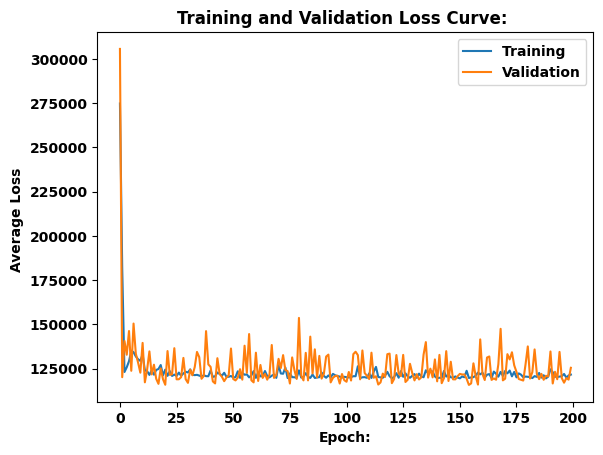

Best epoch:  154  and loss value is  115762.34697614398


In [71]:
main(CSV_FILE)